In [1]:
'''
TODO: 
    MOVER EL BUSCAR CENTROIDES EXACTOS DE LA FUNCION DE PLOTEAR A LA FUNCION DE CREAR CLUSTERS. 
        -HACER UNA LISTA CON LOS CENTROIDES EXACTOS DE LOS CLUSTERS, Y LOS CENTROIDES EN LAS POSICIONES EXISTENTES 
    Reiniciar el kernel y ejecutar funciones para saber si esta tomando los valores de las variables de fuera de las funciones
    Quitar warning #para quitar el warning, pero truena el plot(del C1 sigue el C10)
    
    - cambiar de grupos a series de tiempo

-un bug que hace que el subcentroide del grupo 11 sea el del 10 y viceversa en la grafica despues de filtrado basico

'''
'''
OTRAS NOTAS:

    Referente a pandas y a leer archivos de excel:
        Since December 2020 xlrd no longer supports xlsx-Files as explained in the official (https://stackoverflow.com/questions/48066517/python-pandas-pd-read-excel-giving-importerror-install-xlrd-0-9-0-for-excel)
'''


'\nOTRAS NOTAS:\n\n    Referente a pandas y a leer archivos de excel:\n        Since December 2020 xlrd no longer supports xlsx-Files as explained in the official (https://stackoverflow.com/questions/48066517/python-pandas-pd-read-excel-giving-importerror-install-xlrd-0-9-0-for-excel)\n'

# 0. Imports

In [2]:
#%matplotlib tk #popup
%matplotlib inline
# para hacer el grafico animado
#%matplotlib notebook
import os
import warnings
import datetime
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.transforms as mtransforms

from sklearn import cluster, datasets

from itertools import cycle
from cycler import cycler
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn import mixture
from scipy import spatial
from scipy import optimize
from sklearn.neighbors import KDTree
import sklearn as sk
from scipy.spatial.distance import cdist

import matplotlib.dates as mdates
import matplotlib.colors as colors
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import EngFormatter
import matplotlib.patheffects as path_effects #efectos de texto
from matplotlib import rc, font_manager
import matplotlib.lines as mlines# para crear las leyendas manuales (markers)

import seaborn as sns
sns.set()
plt.style.use('seaborn-white')
sns.set_style("whitegrid")
#mpl.use('TkAgg')#popup


from matplotlib.widgets import RadioButtons, TextBox
from IPython.display import display as wgdisplay
import ipywidgets as widgets
from ipywidgets import Layout
from ipywidgets import interact, interactive, fixed, interact_manual


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# fecha en espanol
import locale
locale.setlocale(locale.LC_ALL, "")
##### ANIMACION #####
import matplotlib.animation as manimation
#ubicacion de ffmpeg.exe
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\mungu\\Anaconda3\\Library\\bin\\ffmpeg.exe'
#plt.rcParams['animation.ffmpeg_path'] = 'C:\\Users\\ernesto\\Anaconda3\\pkgs\\ffmpeg-4.3.1-ha925a31_0\\Library\\bin\\ffmpeg.exe'

#FFMpegWriter = manimation.writers['ffmpeg']

plt.rcParams.update({'figure.max_open_warning': 0})

# 1. Clases y funciones

## Crear plot interactivo para cluster y subcluster

In [3]:
'''
TODO:
    -Eliminar datavp
    -Dibujar subcluster en vviento y clusters en potencia(antes busqueda con kdtree)
    -arreglar mapa de colores
    -quitar selfs innecesarios
    -quite el boton guardar porque savefig solo funciona antes del .show(), por lo que solo
        puedo guardar cuando creo el plot y no cuando lo actualizo
    -diferente al script v2, este es el v3

'''

class plotSubClusterInt:
    '''
    Descripcion:
    Clase para dibujar dos subplots, uno vx vs vy y otro vviento vs Pw.

    Metodos:
        createPlot: Construye el plot de matplotlib.
            self.dfclvv: dataframe multiindice con dos columnas vx y vy agrupadas por cluster 
            dfclpw: dataframe multiindice con dos columnas vviento y Pw agrupadas por cluster
            cl_method: string que almacena el metodo usado para hacer el cluster
                     |   C1    |   C2   |...
                    ----------------------
            Timestamp|  vx vy  |  vx vy |...            datavp: dataframe original de los datos de 

        updatePlot: actuliza el plot en "tiempo real" segun los valores de los controles

        onClick: Es el la funcion que esta ligada al click en el plot. Solo ejecuta annotatePlot.

        annotatePlot: Crea una anotacion en el plot que indica donde el nombre del cluster mas cercano al conjunto de
              coordenadas donde se hizo click en el plot VP. Ademas muestra el cluster en el plot VV.

        blinkCluster: Resalta el cluster al que se hace referencia.

    Argumentos:
        cl_scl_order: el orden en que se hicieron los clusters (viento,viento), (viento,potencia),
            (potencia,viento),(potencia,potencia)
    '''

    def __init__(self):
        from colorsys import hls_to_rgb
#         try:
#             self.fignum = plt.gcf().number +1
#         except Exception as e: 
#             print(e)
#             warnings.warn('¿La libreria de matplotlib esta definida como plt?')
#             self.fignum=999
        self.fignum=999
        self.fisize = (5, 5)
        self.fontsize = 11
        self.n_subclu = 0
        colors1 = plt.cm.tab20(np.linspace(0., 1, 20))
        colors2 = plt.cm.Spectral(np.linspace(0, 1, 10))
        colorstab = np.vstack((colors1, colors2))
        self.mapa_colores=colorstab        

    def createPlot(self, dfclvv, dfclvp,datavp,figsize=(5, 5), cl_scl_order=('viento', 'viento'), 
                   idx_centroids=[],idx_centroids_sc=[],fign=999, savepath='', showCent =True,
                  showlBetz = True,showCFab=True, showOpt = 'Magnitud'):
        self.fisize = figsize
        self.dfclvv = dfclvv
        self.datavp = datavp
        self.cl_scl_order = cl_scl_order
        self.n_clusters = len(self.dfclvv.columns.levels[0])
        self.dfclvp =dfclvp
        self.n_tot_clusters =self.n_clusters 
        self.fignum =fign
        self.idx_centroids =idx_centroids
        self.idx_centroids_sc= idx_centroids_sc
        self.savepath = savepath
        self.showlBetz = showlBetz # show Betz's limit
        self.showCent = showCent # show clusters centroids
        self.showCFab = showCFab #show manufacturer's curve
        #which value is shown in the plot magnitude,cluster number,cluster name, none
        self.showOpts = showOpt 
        ######  limite de betz
        A=np.pi*45**2
        Cp = 0.59 #limite de Betz
        rho = 1.1349
        self.vvento = np.unique(datavp.vViento.values)
        self.PMaxViento = 1/2*rho*A*self.vvento**3*Cp
        

########## CREAR NOMBRE DE COLUMNAS
        
        if len(self.dfclvp.columns.levshape) == 3:  # existen subclusters , sino seria 2

            self.n_subclu = len(self.dfclvv.columns.levels[1])
            #numero total de clusters incluidos los subclusters
            self.n_tot_clusters = self.n_subclu*self.n_clusters 
            # solo aplica cuando hay subclusters
            lev0 = self.dfclvv.columns.get_level_values(0)
            lev1 = self.dfclvp.columns.get_level_values(1)
            namcl = [(lev0[i],lev1[i]) for i in range(len(lev0))]
            #self.clnames_all = sorted(namcl[::2]) #todos los clusters y subclusters disponibles
            self.clnames_all = namcl[::2] #todos los clusters y subclusters disponibles
            #ordenar
            vv = [self.idx_centroids_sc.loc[c].vViento for c in self.clnames_all]
            idx = np.argsort(vv)
            x=[self.clnames_all[i] for i in idx]
            self.clnames_all=x.copy()
            del(x)
            #nombre de los clusters disponibles sin el nombre de los subclusters
            #self.cl_avail =sorted(set(item[0] for item in self.clnames_all))
            self.cl_avail =set(item[0] for item in self.clnames_all)

        else:  # no hay subcluster
           #lista ordenada con numeros y letras
            self.clnames_all=sorted(dfclvv.columns.levels[0], key=lambda x: int("".join([i for i in x if i.isdigit()])))  
            #self.cl_avail =sorted(set(item for item in self.clnames_all))
            self.cl_avail =set(item for item in self.clnames_all)
        

        #### BUSCAR MINIMOS Y MAXIMOS GLOBALES  (hacerlo más elegante)
        l=[self.dfclvv[cl].min() for cl in self.clnames_all]
        self.vxminGlob,self.vyminGlob =   np.amin(l,axis=0)
        l=[self.dfclvv[cl].max() for cl in self.clnames_all]
        self.vxmaxGlob,self.vymaxGlob =   np.amax(l,axis=0)
        l=[self.dfclvp[cl].min() for cl in self.clnames_all]
        self.vvminGlob,self.pminGlob =   np.amin(l,axis=0)
        l=[self.dfclvp[cl].max() for cl in self.clnames_all]
        self.vvmaxGlob,self.pmaxGlob =   np.amax(l,axis=0)
        
        # ############### WIDGETS #################
        self.btnUpdate = widgets.Button(description='Actualizar')
        self.btnUpdate.on_click(self.updatePlot)
        self.btnSelAllChk = widgets.Button(description='Sel. todo')
        self.btnSelAllChk.on_click(self.selAllChk)
        self.btnSelNoneChk = widgets.Button(description='Des. todo')
        self.btnSelNoneChk.on_click(self.selNoneChk)
        self.wdgPSize = widgets.IntSlider(
            value=2,
            min=1,
            max=20,
            step=1,
            description='Point size:',
            continuous_update=False)
        self.chkLimGlob = widgets.Checkbox(
            value=True, description='Límites Globales')
        self.chkShowCnt = widgets.Checkbox(
            value=self.showCent, description='Mostrar centroides')
        self.chkShowBetz = widgets.Checkbox(
            value=self.showlBetz, description='Mostrar línea Betz')
        self.chkShowCPotFab = widgets.Checkbox(
            value=self.showCFab, description='Mostrar curva Fab.')
        self.tbreta = widgets.IntText(
            value=0, description='Retardo:', layout=Layout(width='90%', height='80px'))
        self.wradText = widgets.RadioButtons(
            options=['Magnitud', 'Numero', 'Clusters', 'Ninguno'],
            description='Mostrar texto:')
        self.wradText.value='Numero'
        figsavepath = self.savepath
        figsavename = 'VVVPCl'+str(self.n_clusters)+'SCl'+str(self.n_subclu)+'_'
        figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
        self.tbFilePath = widgets.Text(
            value=figsavepath+figsavename+figsavetime+'.png',
            description='Save path:', layout=Layout(width='90%', height='80px'))
        #self.chkShowCnt.observe(self.updatePlot, 'value')
        #self.wdgPSize.observe(self.updatePlot, 'value')
        #self.wradText.observe(self.updatePlot, 'value')
        #self.chkShowBetz.observe(self.updatePlot, 'value')
        #self.chkShowCPotFab.observe(self.updatePlot, 'value')

      
        self.wchkcls=[] #lista de checbox con los nombresde los clusters
        n=1#para numerar la lista de clusters
        for i in range(len(self.clnames_all)):
            self.wchkcls.append(widgets.Checkbox(
                    value=True, description=str(n) +'-' +str(self.clnames_all[i])))
            n+=1
        box_layout = Layout(display='flex',
                            flex_flow='column',
                            align_items='stretch',
                            height='200px',
                            )    
        vbchkcls = widgets.VBox(self.wchkcls, layout=box_layout)
        

        # WIDGETS EN CAJAS ----------------------
        vbopt1 = widgets.VBox([self.chkShowCnt,self.chkShowBetz, self.chkShowCPotFab,self.chkLimGlob, self.tbreta])
        vbopt2 = widgets.VBox([self.wradText, self.wdgPSize ])
        vbButtons = widgets.VBox([self.btnSelAllChk,self.btnSelNoneChk, self.btnUpdate, self.tbFilePath])
        items = [vbButtons, vbchkcls,vbopt1,vbopt2 ]
        hb = widgets.HBox(items)
        wgdisplay(hb)
        #para que la potencia quede como 1, 1k, 1M
        self.formatterPw = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009

        plt.ion()
        self.fig = plt.figure(self.fignum, figsize=self.fisize)

        self.axvv = self.fig.add_subplot(121)
        self.axvp = self.fig.add_subplot(122)
        self.axvp.yaxis.set_major_formatter(self.formatterPw)

        self.updatePlot(1)
    
    def selAllChk(self,val):
        for item in self.wchkcls:
            item.value=True
    def selNoneChk(self,val):
        for item in self.wchkcls:
            item.value=False       
    def savePlot(self,val):
        figsavepath = self.savepath
        figsavename = 'VVVPCl'+str(self.n_clusters)+'SCl'+str(self.n_subclu)+'_'
        figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
        self.tbFilePath.value=figsavepath+figsavename+figsavetime+'.png'
        plt.savefig(  self.tbFilePath.value, bbox_inches='tight', pad_inches=0.1)
        print('Saved in ' +  self.tbFilePath.value)
    
    def updatePlot(self, val):
        pSize = self.wdgPSize.value
        self.axvv.axes.clear()
        self.axvp.axes.clear()
        if len(self.dfclvp.columns.levshape) == 3:  # existen subclusters , sino seria 2
            clnames= [eval(el.description.split('-')[1]) for el in self.wchkcls if el.value==True]
            #ordenar subclusters por velocidad
            #los subclusters se ordenan dentro de cada grupo de clusters en idx_centrods_sc
            #hay que ordenarlos tambien globalmente y no solo localmente
            #self.cl_avail =sorted(set(item[0] for item in clnames))
            vv = [self.idx_centroids_sc.loc[c].vViento for c in clnames]
            idx = np.argsort(vv)
            x=[clnames[i] for i in idx]
            clnames=x.copy()
            del(x)
            #self.clnames_all =clnames# REV: SE OCUPA CLNAMES_ALL???
            self.cl_avail =set(item[0] for item in clnames)

        else :
            clnames=[el.description.split('-')[1] for el in self.wchkcls if el.value==True]
            #aqui tambien va por si se eliminan todos los subclusters del mismo cluster. Solo lista los clusters
            #self.cl_avail =sorted(set(item for item in clnames))
            self.cl_avail =set(item for item in clnames)
        
        
        # DEFINIR LIMITES DE PLOT

        #buscar los minimos y maximos de los clusters
        #debede haber una forma mas elegante de hacerlo. Como hago sliced elmultiindex con tuplas

        lvxmin=np.empty(self.n_tot_clusters)
        lvxmin.fill(np.nan)
        lvymin=np.empty(self.n_tot_clusters)
        lvymin.fill(np.nan)
        lvxmax=np.empty(self.n_tot_clusters)
        lvxmax.fill(np.nan)
        lvymax=np.empty(self.n_tot_clusters)
        lvymax.fill(np.nan)
        lvvmin=np.empty(self.n_tot_clusters)
        lvvmin.fill(np.nan)
        lvvmax=np.empty(self.n_tot_clusters)
        lvvmax.fill(np.nan)
        lpmin =np.empty(self.n_tot_clusters)
        lpmin.fill(np.nan)
        lpmax= np.empty(self.n_tot_clusters)
        lpmax.fill(np.nan)
        n=0
        for cl in clnames:

            lvxmin[n],lvymin[n]= self.dfclvv[cl].min()
            lvxmax[n],lvymax[n] = self.dfclvv[cl].max()
            lvvmin[n],lpmin[n] = self.dfclvp[cl].min()
            lvvmax[n],lpmax[n] = self.dfclvp[cl].max()           
            n+=1
        vxmin=np.nanmin(lvxmin)
        if np.isnan(vxmin):
            vxmin=0
        vymin = np.nanmin(lvymin)
        if np.isnan(vymin):
            vymin =0
        vxmax = np.nanmax(lvxmax)
        if np.isnan(vxmax):
            vxmax=1
        vymax = np.nanmax(lvymax)
        if np.isnan(vymax):
            vymax=1
        vvmin = np.nanmin(lvvmin)
        if np.isnan(vvmin):
            vvmin=0
        vvmax = np.nanmax(lvvmax)
        if np.isnan(vvmax):
            vvmax=1
        pmin= np.nanmin(lpmin)
        if np.isnan(pmin):
            pmin=0
        pmax = np.nanmax(lpmax)
        if np.isnan(pmax):
            pmax=1
        if self.chkLimGlob.value:#plotear con limites globales o con los limites del cluster
            self.axvv.set_xlim((self.vxminGlob, self.vxmaxGlob))
            self.axvv.set_ylim((self.vyminGlob, self.vymaxGlob))
            self.axvp.set_xlim((self.vvminGlob, self.vvmaxGlob))
            self.axvp.set_ylim((self.pminGlob, self.pmaxGlob))
        else:    
            self.axvv.set_xlim((vxmin, vxmax))
            self.axvv.set_ylim((vymin, vymax))
            self.axvp.set_xlim((vvmin, vvmax))
            self.axvp.set_ylim((pmin, pmax))


# ########################## PLOTEAR ########################
        

        for item in clnames:
            #busca el cluster actual y devuelve el indice dentro de la lista de clusters donde lo encuentra
            #es decir, asocia un numero unico a un nombre de cluster
            #es para que el color de los clusters sea el mismo siempre
            idxClName = [ncl_ for ncl_, clname_ in enumerate(self.clnames_all) if clname_ == item]
            #self.fig.suptitle('Grupos de velocidad de viento y potencia', y=1)
            # magnitud del vector

            magni = round(
                np.mean(
                    np.sqrt(self.dfclvv[item].vx**2 +
                            self.dfclvv[item].vy**2)),
                1)  # magnitud de la vv

            self.axvv.scatter(
                self.dfclvv[item].vx,
                self.dfclvv[item].vy,
                s=pSize,
                c=self.mapa_colores[idxClName],
                alpha=1)

            self.axvp.scatter(
                self.dfclvp[item].vViento,
                self.dfclvp[item].Pw,
                s=pSize,
                c=self.mapa_colores[idxClName])
            #para que el label de la potencia quede como 1,1k,1M
            self.axvp.yaxis.set_major_formatter(self.formatterPw)
            
#             self.axvp.ticklabel_format(
#                 style='sci', axis='y', scilimits=(0, 0), useMathText=True)
          
        ####### MOSTRAR TEXTO ################################################################
            if self.wradText.index == 0: #magnitud
                
                text = self.axvv.text(
                    self.dfclvv[item].vx.mean(),
                    self.dfclvv[item].vy.mean(),
                    magni,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100,
                )
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                       path_effects.Normal()])

                text = self.axvp.text(
                    self.dfclvp[item].vViento.mean(),
                    self.dfclvp[item].Pw.mean(),
                    magni,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100)
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                       path_effects.Normal()])
                
            elif self.wradText.index == 1: #numero
                text = self.axvv.text(
                    self.dfclvv[item].vx.mean(),
                    self.dfclvv[item].vy.mean(),
                    idxClName[0]+1,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100)
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                       path_effects.Normal()])


                text = self.axvp.text(
                    self.dfclvp[item].vViento.mean(),
                    self.dfclvp[item].Pw.mean(),
                    idxClName[0]+1,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100)
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                       path_effects.Normal()])
            
            elif self.wradText.index == 2:
                text = self.axvv.text(
                    self.dfclvv[item].vx.mean(),
                    self.dfclvv[item].vy.mean(),
                    item,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100)
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                       path_effects.Normal()])


                text = self.axvp.text(
                    self.dfclvp[item].vViento.mean(),
                    self.dfclvp[item].Pw.mean(),
                    item,
                    fontsize=self.fontsize,
                    weight='bold',
                    color='w',
                    alpha=1,
                    zorder=100)
                text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='k'),
                       path_effects.Normal()])
            self.fig.canvas.draw()
            
        
######### MOSTRAR CENTROIDES#######################
        if self.chkShowCnt.value == True:
            for cl in self.cl_avail:
                
                #el nombred el cluster esta en el indice
                #le quito la letra con cl[1:] y dejo solo el numero como
                #esta en el dataframe
                numcl = int(cl[1:])
                self.axvv.scatter(
                        self.idx_centroids.loc[numcl].vx,
                        self.idx_centroids.loc[numcl].vy,
                        marker='X',
                        edgecolor='black',
                        linewidth=1,
                        facecolor='yellow',
                        s=60)
                self.axvp.scatter(
                    self.idx_centroids.loc[numcl].vViento,
                    self.idx_centroids.loc[numcl].Pw,
                    marker='X',
                    edgecolor='black',
                    linewidth=1,
                    facecolor='yellow',
                    s=60)
                temp = str(self.idx_centroids.loc[numcl].vViento)+'-'+str(self.idx_centroids.loc[numcl].Pw)
                print(temp)
                
####### MOSTRAR CENTROIDES SUBCLUSTERS
            if self.n_subclu > 0:               
                for el in clnames:
                    self.axvv.scatter(
                        self.idx_centroids_sc.loc[el].vx,
                        self.idx_centroids_sc.loc[el].vy,
                        marker='h',
                        edgecolor='black',
                        linewidth=1,
                        facecolor='aqua',
                        s=30)
                    self.axvp.scatter(
                        self.idx_centroids_sc.loc[el].vViento,
                        self.idx_centroids_sc.loc[el].Pw,
                        marker='h',
                        edgecolor='black',
                        linewidth=1,
                        facecolor='aqua',
                        s=30)
### MOSTRAR OTRAS REFERENCIAS
#MOSTRAR LEYENDA
    #no programado    
    #self.axvv.legend(scatterpoints=1)
#MOSTRAR CURVA DEL FABRICANTE
        if self.chkShowCPotFab.value==True:
            self.axvp.plot(dfCPot.index, dfCPot.pw, c='red', label='Fabricante')

#MOSTRAR LIMITE DE BETZ
        if self.chkShowBetz.value==True:
            self.axvp.plot(self.vvento,self.PMaxViento,label='Betz',c='y')
        
        #self.fig.legend(loc=best)
        self.axvp.set_xlabel('Velocidad [m/s]')
        self.axvp.set_ylabel('Potencia [W]')
        self.axvv.set_xlabel('vx [m/s]')
        self.axvv.set_ylabel('vy [m/s]')
        
        
        self.fig.canvas.flush_events()
        plt.gcf()
        self.savePlot(val)
        self.fig.canvas.draw()
        plt.tight_layout()
        #imprimir a consola
        os.write(1, b"Plot actualizado\n")

            

## Clusters-subclusters to dataframe con direccion

In [4]:
'''TO DO: en el idx_centroids los numeros de los clusters no llevan la C, en el idx_centroids_sc si
la llevan, o cambiar todo a que la lleven o que no la lleven'''
#crear dataframes a partir de clusters
#def cluster2DataFrame(dfvxvy, dfVP, n_clusters, labels, n_subclu=0, clusters='viento',subclusters='viento'):
def cluster2DataFrame(dfvxvy, dfVP, n_clusters, n_subclu=0, clusters='viento',subclusters='viento',datadir=[]):
    '''
        Descripcion: 
        Esta funcion toma diferentes dataframes de entrada agrupa los datos por cluster.
        
        Argumento:
        dfvxvy: dataframe con columnas vx y vy
        dfVP: dataframe con columnas de magnitud de viento y potencia
        n_clusters: numero de clusters
        labels: etiquetas del metodo de clusterizacion
        n_subclu: Número de suclusters a calcular a partir de los n clusters calculados en un principio.
                  Si n_subclu=0 no se calcula ningun subcluster. Por defecto n_sub=0
        
        Devuelve:
        cl_ord: un array que contiene el número de cluster n ordenado de menor a mayor
            de las magnitudes de la velocidad de viento sin tomar en cuenta la direccion
        dfclvv: dataframe donde las componentes de velocidad de viento vx y vy estan
            agrupadas por cluster
        dfclpw: dataframe donde la potencia esta agrupada por cluster
        dfclvp: dataframe donde la potencia y la magnitud de viento esta agrupada por
            cluster
    '''
#'''- KMEANS -----------------------------------------------------------------------------------------'''
    if clusters=='viento':
        kmeans = cluster.KMeans(n_clusters=n_clusters,random_state=0).fit(dfvxvy)
        cl_centroids = kmeans.cluster_centers_
        cl_labels=kmeans.labels_ 
        clusassign=cl_labels#si nos e usa untrained data
        ncentroids = len(cl_centroids)
        #buscar centroides en dataframes
        #https://stackoverflow.com/questions/42583995/get-the-centroid-row-index-from-k-means-clustering-using-sklearn
        #clusassign = kmeans.fit_predict(dfvxvy.values)#solo se si utiliza untrained data
        min_dist = np.min(cdist(dfvxvy.values, kmeans.cluster_centers_, 'euclidean'), axis=1)#distancia minima a cada centroide
        Y = pd.DataFrame(min_dist, index=dfvxvy.index, columns=['PCTimeStamp'])
        Z = pd.DataFrame(clusassign, index=dfvxvy.index, columns=['cluster_ID'])
        #crea el dataframe
        PAP = pd.concat([Y,Z], axis=1)
        
    elif clusters=='potencia':
        kmeans = cluster.KMeans(n_clusters=n_clusters,random_state=0).fit(dfVP)
        cl_centroids = kmeans.cluster_centers_
        cl_labels=kmeans.labels_ 
        ncentroids = len(cl_centroids)
        #clusassign=cl_labels
        #buscar centroides en dataframes
        #clusassign = kmeans.fit_predict(dfVP.values)
        min_dist = np.min(cdist(dfVP.values, kmeans.cluster_centers_, 'euclidean'), axis=1)
        Y = pd.DataFrame(min_dist, index=dfVP.index, columns=['PCTimeStamp'])
        Z = pd.DataFrame(clusassign, index=dfVP.index, columns=['cluster_ID'])
        PAP = pd.concat([Y,Z], axis=1)
    elif clusters=='direccion':
        kmeans = cluster.KMeans(n_clusters=n_clusters,random_state=0).fit(datadir)
        cl_centroids = kmeans.cluster_centers_
        cl_labels=kmeans.labels_ 
        #clusassign=cl_labels
        ncentroids = len(cl_centroids)
        #buscar centroides en dataframes
        #clusassign = kmeans.fit_predict(dfVP.values)
        min_dist = np.min(cdist(dfVP.values, kmeans.cluster_centers_, 'euclidean'), axis=1)
        Y = pd.DataFrame(min_dist, index=dfVP.index, columns=['PCTimeStamp'])
        Z = pd.DataFrame(clusassign, index=dfVP.index, columns=['cluster_ID'])
        PAP = pd.concat([Y,Z], axis=1)
    
    #ordend e los cluster por magnitud de vv
    cl_magni = np.zeros(n_clusters)
    for i in range(n_clusters):
        vx = dfvxvy.vx.values[cl_labels == i]
        vy = dfvxvy.vy.values[cl_labels == i]
        cl_magni[i] = np.mean(np.sqrt(vx**2 + vy**2))  #magnitud de la vv
    cl_ord = np.argsort(cl_magni.argsort()) #ver https://github.com/numpy/numpy/issues/8757

  
    
    
    grouped = PAP.groupby(['cluster_ID'])#agrupa por numero de clusters las distancias minimas
    idx_centroids = grouped.idxmin()#encuentra el indice de la distanciam minima
    #agregando columnas de velocidadd de viento y potencia al dataframe de los centroides
    vxvy=dfvxvy.loc[idx_centroids.PCTimeStamp].values
    vvpot = dfVP.loc[idx_centroids.PCTimeStamp].values
     
    idx_centroids=idx_centroids.assign(vx=vxvy[:,0],vy=vxvy[:,1],vViento=vvpot[:,0],Pw=vvpot[:,1]) 
    idx_centroids.sort_values(by='vViento',inplace=True)# ordenar por velocidad de viento
    idx_centroids.reset_index(inplace=True) #que ya no sea el cluster id el indice
    idx_centroids.index.set_names('cluster_ID_ord',inplace=True)  #ponerle el nombre al indice ordenado
    idx_centroids.index+=1 #paraque el indice empieze en uno y no exista cluster 0
    if clusters=='direccion':
        
        #SUSTITUIR CENTRODS DE DIRECCION POR VELOCIDAD
        lc =[]
        
        for labcl in np.unique(cl_labels):
        
            lc.append(centeroidpython(dfvxvy.values[cl_labels==labcl]))
        
        cl_centroids=np.array([[i[0],i[1]]for i in cl_centroids])
        #ordenar centroides
        #cl_cenroids=cl_centroids[cl_centroids[:,0].argsort()]



## CREAR MULTIINDICE ---------------------------------------------------------------'''
    #CLUSTER VX,VY:
    #https://stackoverflow.com/questions/37835508/how-to-do-multi-column-from-tuples
    #nombre de las columnas del dataframe
    colheadvv = []
    colheadpw = []
    for i in range(n_clusters):
        colheadvv.append(('C' + str(i + 1), 'vx'))
        colheadvv.append(('C' + str(i + 1), 'vy'))
        colheadpw.append('C' + str(i + 1))
    dfclvv = pd.DataFrame()
        
    for i in range(n_clusters):
        dfclvv = pd.concat([
            dfclvv, dfvxvy.vx[cl_labels ==np.where(cl_ord ==i)[0][0]],
            dfvxvy.vy[cl_labels == np.where(cl_ord ==i)[0][0]]
        ],
                           axis=1,
                           ignore_index=True)
    #crear multiindice
    dfclvv.columns = pd.MultiIndex.from_tuples(colheadvv)

    #CLUSTER POTENCIA:
    dfclpw = pd.DataFrame()
    for i in range(n_clusters):
        dfclpw = pd.concat([dfclpw, dfVP.Pw[cl_labels == np.where(cl_ord ==i)[0][0]]],
                           ignore_index=True,
                           axis=1)
    dfclpw.columns = colheadpw

    #CLUSTER VIENTO POTENCIA:
    colheadvp = []
    for i in range(n_clusters):
        colheadvp.append(('C' + str(i + 1), 'vViento'))
        colheadvp.append(('C' + str(i + 1), 'Pw'))
    dfclvp = pd.DataFrame()
    for i in range(n_clusters):
        dfclvp = pd.concat([
            dfclvp, dfVP.vViento[cl_labels == np.where(cl_ord ==i)[0][0]],
            dfVP.Pw[cl_labels ==np.where(cl_ord ==i)[0][0]]] ,
                           axis=1,
                           ignore_index=True)
    #crear multiindice
    dfclvp.columns = pd.MultiIndex.from_tuples(colheadvp)
    
    if clusters=='direccion':
        #CLUSTER direccion viento
        colheadvp = []
        for i in range(n_clusters):
            colheadvp.append(('C' + str(i + 1), 'Dir'))
            colheadvp.append(('C' + str(i + 1), 'vViento'))
        dfcldv = pd.DataFrame()
        for i in range(n_clusters):
            dfcldv = pd.concat([
                dfcldv, datadir.vViento[cl_labels ==( cl_ord ==i)],
                datadir.Dir[cl_labels == (cl_ord ==i)]],                               
                axis=1,ignore_index=True)
        #crear multiindice
        dfcldv.columns = pd.MultiIndex.from_tuples(colheadvp)
    '''- CALCULAR SUBCLUSTERS ------------------------------------------------------------------- '''

    
    if n_subclu > 0:
        scl_centroids = []
        scl_labels = []
        scl_ncentroids =[]
        idx_centroids_sc= pd.DataFrame() #va almacenar los centroides de los subclusters
        #obtener los resultados del clusterizado
        for i in range(n_clusters):
            if subclusters=='viento':
                dfclvvnoNA=dfclvv['C'+str(i+1)].dropna()
                #buscando centroides con los subclusters
                kmeans_sc = cluster.KMeans(n_clusters=n_subclu, random_state=0).fit(dfclvvnoNA)
                min_dist_sc = np.min(cdist(dfclvvnoNA.values, kmeans_sc.cluster_centers_, 'euclidean'), axis=1)
                Y_sc = pd.DataFrame(min_dist_sc, index=dfclvvnoNA.index, columns=['PCTimeStamp'])
                Z_sc = pd.DataFrame(kmeans_sc.labels_, index=dfclvvnoNA.index, columns=['subcluster_ID'])
    
            elif subclusters=='potencia':
                dfclvpnoNA=dfclvp['C'+str(i+1)].dropna()
                #buscando centroides con los subclusters
                kmeans_sc = cluster.KMeans(n_clusters=n_subclu, random_state=0).fit(dfclvpnoNA)
                min_dist_sc = np.min(cdist(dfclvpnoNA.values, kmeans_sc.cluster_centers_, 'euclidean'), axis=1)
                Y_sc = pd.DataFrame(min_dist_sc, index=dfclvpnoNA.index, columns=['PCTimeStamp'])
                Z_sc = pd.DataFrame(kmeans_sc.labels_, index=dfclvpnoNA.index, columns=['subcluster_ID'])
            else:
                print('Todavía no programado, haciendo subclusters en potencia')
                kmeans_sc = cluster.KMeans(n_clusters=n_subclu, random_state=0).fit(dfclvp['C'+str(i+1)].dropna())
                
            scl_centroids.append(kmeans_sc.cluster_centers_)
            scl_labels.append(kmeans_sc.labels_)
            scl_ncentroids.append(len(scl_centroids[i]))
            
            
            PAP_sc = pd.concat([Y_sc,Z_sc], axis=1)  
            #poniendo index a los centroides de los subclusters
            grouped_sc = PAP_sc.groupby(['subcluster_ID'])
            idx_cent_sc = grouped_sc.idxmin()
            idx_cent_sc.index +=1
            #agregando columnas de velocidadd de viento y potencia al dataframe de los centroides
            vxvy_sc=dfvxvy.loc[idx_cent_sc.PCTimeStamp].values
            vvpot_sc = dfVP.loc[idx_cent_sc.PCTimeStamp].values
            idx_centroids_sc=pd.concat([idx_centroids_sc, idx_cent_sc.assign(vx=vxvy_sc[:,0],vy=vxvy_sc[:,1],vViento=vvpot_sc[:,0],
                                                     Pw=vvpot_sc[:,1], cluster_ID='C'+str(i+1))] )
        #creando el multiindex fuera del ciclo for
       # idx_centroids_sc.set_index(['cluster_ID',idx_centroids_sc.index],inplace=True)
        
        idx_centroids_sc.reset_index(inplace=True)
        idx_centroids_sc.sort_values(['cluster_ID','vViento'], ascending=[1,1],inplace=True)
        lst_num_sc=list(range(1,n_subclu+1))*n_clusters#crea una lista de numeros para el subcluster [1,2,3..1,2,3]
        sc_idx_list =list(map(lambda x:'SC'+str(x),lst_num_sc))#le pone las letras SC [SC1,SC2,SC3...SC1,SC2,SC3]
        idx_centroids_sc=idx_centroids_sc.assign(subcluster_ID_ord=sc_idx_list)
        idx_centroids_sc.set_index(['cluster_ID','subcluster_ID_ord'],inplace=True)
            
            
############  ORDENAR CENTROIDES:  ordenar el orden de aparicion segun la magnitud de la vv
        scl_magni = np.zeros([n_clusters,n_subclu])
        scl_ord = []
        
        for i in range(n_clusters):
            
            for j in range(n_subclu):
                
                vx = dfclvv['C' + str(i+1)].vx.dropna().values[scl_labels[i] == j]
                vy = dfclvv['C' + str(i+1)].vy.dropna().values[scl_labels[i] == j]
                scl_magni[i][j] = np.mean(np.sqrt(vx**2 + vy**2))  #magnitud de la vv
                
            scl_ord.append( scl_magni[i].argsort())# ver https://github.com/numpy/numpy/issues/8757
        
        #ORDENAR CENTROIDES
        for i in range(len(scl_centroids)):
            scl_centroids[i] = scl_centroids[i][scl_ord[i]]   

            

        #CLUSTER VIENTO POTENCIA:
        colheadvp = []
        for i in range(n_clusters):
            for j in range(n_subclu):
                colheadvp.append(('C' + str(i + 1),'SC' + str(j + 1), 'vViento'))
                colheadvp.append(('C' + str(i + 1),'SC' + str(j + 1), 'Pw'))
        dfsclvp = pd.DataFrame()

        for i in range(n_clusters):
            for j in range(n_subclu):
                dfsclvp = pd.concat([
                    dfsclvp, dfclvp['C'+str(i+1)].dropna().vViento[scl_labels[i]  == scl_ord[i][j]],
                    dfclvp['C'+str(i+1)].dropna().Pw[scl_labels[i] == scl_ord[i][j]]
                ],
                                   axis=1,
                                   ignore_index=True)
        #crear multiindice
        dfsclvp.columns = pd.MultiIndex.from_tuples(colheadvp)
       
        #CLUSTER VX,VY:####################################################
        colheadvv = []
        for i in range(n_clusters):
            for j in range(n_subclu):
                colheadvv.append(('C' + str(i + 1),'SC' + str(j + 1), 'vx'))
                colheadvv.append(('C' + str(i + 1),'SC' + str(j + 1), 'vy'))
        dfsclvv = pd.DataFrame()

        for i in range(n_clusters):
            for j in range(n_subclu):
                dfsclvv = pd.concat([
                    dfsclvv, dfclvv['C'+str(i+1)].dropna().vx[scl_labels[i]  == scl_ord[i][j]],
                    dfclvv['C'+str(i+1)].dropna().vy[scl_labels[i] == scl_ord[i][j]]
                ],
                                   axis=1,
                                   ignore_index=True)
        #crear multiindice
        dfsclvv.columns = pd.MultiIndex.from_tuples(colheadvv)
        
        #CLUSTER POTENCIA:
        dfsclpw = pd.DataFrame()
        colheadpw =[]
        for i in range(n_clusters):
            for j in range(n_subclu):
                colheadpw.append(('C' + str(i + 1),'SC' + str(j + 1)))
       
        for i in range(n_clusters):
            for j in range(n_subclu):
                dfsclpw = pd.concat([dfsclpw, dfclvp['C'+str(i+1)].Pw.dropna()[scl_labels[i] == scl_ord[i][j]]],
                               ignore_index=True,
                               axis=1)
        dfsclpw.columns = pd.MultiIndex.from_tuples(colheadpw)
        
        #### buscar centroides para la grafica vv
        #obtener nombre de niveles
        n_subclu = len(dfsclvv.columns.levels[1])
        #numero total de clusters incluidos los subclusters
        n_tot_clusters = n_subclu*n_clusters 
        # solo aplica cuando hay subclusters
        lev0 = dfsclvv.columns.get_level_values(0)
        lev1 = dfsclvv.columns.get_level_values(1)
        namcl = [(lev0[i],lev1[i]) for i in range(len(lev0))]
        colnames = namcl[::2]

        
        '''TODO: QUE EL RETURN TENGA ESTA FUNCIONALIDAD'''
        #return  dfsclvv,dfsclpw,dfsclvp,cl_ord,cl_centroids, idx_centroids,scl_ord,scl_centroids,idx_scl_centroids
        if clusters=='direccion':
            return  dfsclvv,dfsclpw,dfsclvp,dfclvp,cl_ord,cl_centroids, idx_centroids,scl_ord,scl_centroids,

        else:
            return  dfsclvv,dfsclpw,dfsclvp,cl_ord,cl_centroids, idx_centroids,scl_ord,scl_centroids,idx_centroids_sc
    
    else:# sin subclusters
        if clusters=='direccion':
            print('NO PROGRAMADO')
            return dfclvv, dfclpw, dfclvp,dfcldv,cl_ord, cl_centroids,idx_centroids
        else:
            scl_ord=[]
            scl_centroids=[]
            idx_centroids_sc=[]
            return dfclvv,dfclpw,dfclvp,cl_ord,cl_centroids,idx_centroids,scl_ord,scl_centroids,idx_centroids_sc

## Eliminar clusters

In [5]:
''' FUNCION ACTUALIZADA A AGOSTO VER: https://pandas-docs.github.io/pandas-docs-travis/user_guide/advanced.html
La palabra labels cambio a codes
Changed in version 0.24.0: MultiIndex.labels has been renamed to MultiIndex.codes and MultiIndex.set_labels to MultiIndex.set_codes.
'''
'''TODO: POR ALGUNA RAZON NO PUEDO EJECUTAR LA MISMA FUNCION DOS VECES. ES COMO SI AFECTARA MIS VARIABLES ORIGINALES'''
def delClusters(data,cltodel,idx_cent,idx_cent_sc=[],scl_ord=[],cl_type='cluster'):
    '''
    Elimina clusters, subclusters, centroides de clusters o centroides de subclusters.
        Argumentos:
            dataf: dataframes a los que se eliminaran los clusters o subclusters.
            cltodel: lista o listas de clusters o subclusters a eliminar
            sc_centroids: ista que contiene los centroides. De esta lista se eliminaran los centroides a partir de cltodel.
    '''    
    dflist =[]
    for df in data:
        dflist.append(df.drop(cltodel,axis=1))
    #cambiar nombre por numero de centroides
    n_cl=len(df.columns.levels[0])
    n_subcl = len(df.columns.levels[1])
    #numero total de clusters incluidos los subclusters
    #sn_tot_clusters = (n_subcl*n_cl) -(len(df.columns.labels[0])-len(dflist[0].columns.labels[0]))/2
    sn_tot_clusters = (n_subcl*n_cl) -(len(df.columns.codes[0])-len(dflist[0].columns.codes[0]))/2
    #eliminar centroides de clusters
    clnames = pd.unique(df.columns.get_level_values(0))
    lev0 = data[0].columns.get_level_values(0)
    lev1 = data[0].columns.get_level_values(1)
    namcl = [(lev0[i],lev1[i]) for i in range(len(lev0))]
    cl_sc_names = namcl[::2]
    #convertir a conjuntos
    a =set(cltodel)# clusters a eliminar
    b=set(cl_sc_names)#nombre de todos los clusters
    c=(b-a)#a b lequito a
    cent_restantes =set(sorted(set(int(item[0][1:]) for item in c)))#quito la letra C
    idx_cent_reales = set(idx_cent.index.values)
    idx_cent_todel = list(idx_cent_reales-cent_restantes)
    idx_centroids_clean=idx_cent.drop(idx_cent_todel)

    #eliminar centroides de los subclusters    
    idx_centroidssc_clean = idx_cent_sc.drop(cltodel)
  
    return dflist,idx_centroids_clean,idx_centroidssc_clean


## clusters a datos

In [6]:
def clust2data(dfv,dfvp):
    '''
    Convierte el dataframe de los datos de vx,vy y potencia separados en clusters (C1-SC1-vx,vy) a datos con 
    con tres columnas time,vx,vy o time,vv,pw.
    To-do:   Sigue perdiendo miles de registros, ¿porque hay registros na en el original?
    hay filas con solo nan en el original, en una prueba fueron como 4000'''
    dfv= dfv.copy()#para que no afecte el original, si lo afecta el que esta como argumento
    dfvp= dfvp.copy()
    #Quitar multiindex
    dfv.columns = dfv.columns.map(''.join)
    dfv.reset_index(inplace=True)
    #list comprehension
    lvv=[
       dfv.iloc[i].dropna().values
       for i in range(len(dfv) )      
      ]
    dfvxvy_clean=pd.DataFrame(lvv,columns=['PCTimeStamp','vx','vy'])
    dfvxvy_clean.dropna(inplace=True)#hay filas de nan y se pierden miles de datos, revisar
    
    #Quitar multiindex
    dfvp.columns = dfvp.columns.map(''.join)
    dfvp.reset_index(inplace=True)
    #list comprehension
    lvp=[
       dfvp.iloc[i].dropna().values
       for i in range(len(dfvp) )      
      ]
    dfvp_clean=pd.DataFrame(lvp,columns=['PCTimeStamp','vViento','Pw'])
    dfvp_clean.dropna(inplace=True)#hay filas de nan y se pierden miles de datos, revisar
    
    return dfvxvy_clean,dfvp_clean

# 2. Procesamiento de datos

In [7]:
flagsaveim =False #flag para indicar si se guardan las imagenes (no quiero que se sobreescriban)

In [8]:
rutaxls = 'C:/Users/mungu/Documents/DatosWTG.xlsx'
#rutaxls = 'C:\\Users\\ernesto\\Dropbox\\Doctorado\\datos\\DatosWTG.xlsx'
rutaxlsCPot = 'C:/Users/mungu/Dropbox/Doctorado/Python/aero/Curva de potencia vestas 90.xlsx'

#dataVPxls = pd.read_excel(rutaxls,usecols=[0,1,2],index_col=0,names=['vViento','Pacw'])
dataVPxls = pd.read_excel(rutaxls,usecols=[0,1,2],index_col=0, engine='openpyxl')
dataVPxls.columns =['vViento','Pacw']
#agrego la columna de potencia instantanea sin filtrar
#dataVPxls['Pw']= (dataVPxls.iloc[1:,1].values-dataVPxls.iloc[0:-1,1]) * np.pi*45**2
print(len(dataVPxls))
#dfCPot = pd.read_excel(rutaxlsCPot,usecols=[0,2],index_col=0,names=['pw'])#cambio esto en la nueva version
dfCPot = pd.read_excel(rutaxlsCPot,usecols=[0,2],index_col=0, engine='openpyxl')
dfCPot.columns = ['pw']
#marcando los datos faltantes asignando un nan a la fila completa
datamk = dataVPxls
datamk.loc[datamk.isnull().any(axis=1), :] = np.nan
#numero de filas sin datos
print('Numero de filas sin datos')
print(datamk.loc[datamk.isnull().any(axis=1), :].isnull().sum())

#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
cleanData = datamk.dropna()

###calculando la potencia
#la pontencia del archivo de excel es la densidad de potencia acumulada.
#Se tiene que hacer la resta de la potencia siguiente a la anterio y multiplicar por pi*r^2
#el radio es 45m
#si se hace la resta con un array de numpy (values) si se puede restar 
#pues se hace elemento por elemento
dataVP = cleanData.drop('Pacw',axis=1)
dataVP['Pw']= (cleanData.iloc[1:,1].values-cleanData.iloc[0:-1,1]) * np.pi*45**2

#eliminar el ultimo valor pues es NaN
dataVP.drop(dataVP.tail(1).index,inplace=True) 

#Eliminando outliers
dataVP.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)
#agregado para el reporte
dataVP.drop([pd.to_datetime('2016-03-08 09:00:00')],inplace=True)
dataVP.drop([pd.to_datetime('2016-01-02 06:40:00')],inplace=True)
dataVP.drop([pd.to_datetime('2016-05-05 07:20:00')],inplace=True)
dataVP.drop([pd.to_datetime('2016-05-23 23:00:00')],inplace=True)


#leyendo la direccion del viento
#dataDirVxls = pd.read_excel(rutaxls,sheet_name=1, usecols=[0,1],index_col=0,names=['Dir'])
dataDirVxls = pd.read_excel(rutaxls,sheet_name=1, usecols=[0,1],index_col=0, engine='openpyxl')
dataDirVxls.columns =['Dir']
#limpiando datos
#marcando los datos faltantes asignando un nan a la fila completa
datamkdir = dataDirVxls
datamkdir.loc[datamkdir.isnull().any(axis=1), :] = np.nan
#eliminando filas con NaN. Si busco la fecha anterior debe aparecer error.
#tambien elimino el ultimo valor como lo hice en los datos de v y p
#el copy es para que no me de la copy warning
dataDir = datamkdir.dropna().copy()
dataDir.drop(dataDir.tail(1).index,inplace=True) 
#eliminando del outlier de viento misma fecha que el de la pontencia
dataDir.drop([pd.to_datetime('2016-03-07 09:50:00')],inplace=True)
#agregado para el reporte
dataDir.drop([pd.to_datetime('2016-03-08 09:00:00')],inplace=True)
dataDir.drop([pd.to_datetime('2016-01-02 06:40:00')],inplace=True)
dataDir.drop([pd.to_datetime('2016-05-05 07:20:00')],inplace=True)
dataDir.drop([pd.to_datetime('2016-05-23 23:00:00')],inplace=True)

direcvrad= np.deg2rad(dataDir['Dir'].values)
velocidades = dataVP.iloc[:]['vViento'].values
vecVel = [-np.sin(direcvrad)*velocidades,np.cos(direcvrad)*velocidades]
vecVelnp=np.array(vecVel).transpose()
#original sin timestamp
#dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy']
#con timestamp
dfVecVel = pd.DataFrame(data=vecVelnp,columns=['vx','vy'],index=dataVP.index)

#datos direccion velocidad
print(len(dataVP))
print(len(dataDir))
dataDV = pd.concat([dataDir,dataVP.vViento],axis=1)
dataDVP = pd.concat([dataDir,dataVP.Pw,dataVP.vViento],axis=1)
dataVcD =pd.concat([dataDir,dfVecVel],axis=1)
#Datos en p.u.. Divido todos los datos entre el máximo del conjunto de datos


#OPERATIONAL DATA	
# Rated power
# 2,000 kW/2,200 kW
# Cut-in wind speed	4 m/s
# Cut-out wind speed	25 m/s
# Re cut-in wind speed	23 m/s

cutin_speed = 4
cutoff_speed = 25#segun el datasheet
recutin_speed= 23

52848
Numero de filas sin datos
vViento    312
Pacw       312
dtype: int64
52530
52530


In [9]:

#import sys 
#sys.path.append('C:\Users\mungu\Anaconda3\pkgs\openpyxl-2.5.3-py36_0\Lib\site-packages\openpyxl')
#import openpyxl


In [10]:
dataVP_pu=dataVP.copy()
dataVP_pu.Pw= dataVP.Pw.apply(lambda x : x/dataVP.Pw.max())


In [11]:
dataVP_pu.Pw.head()

PCTimeStamp
2016-01-01 00:00:00    0.902941
2016-01-01 00:10:00    0.955882
2016-01-01 00:20:00    0.947059
2016-01-01 00:30:00    0.961765
2016-01-01 00:40:00    0.958824
Name: Pw, dtype: float64

In [12]:
dataVP.head()

,vViento,Pw
PCTimeStamp,,
2016-01-01 00:00:00,12.7,1.953050e+06
2016-01-01 00:10:00,14.8,2.067561e+06
2016-01-01 00:20:00,16.2,2.048475e+06
2016-01-01 00:30:00,14.9,2.080284e+06
2016-01-01 00:40:00,16.2,2.073922e+06


# Análisis básico

##  Curva de potencia del fabricante y nube de puntos

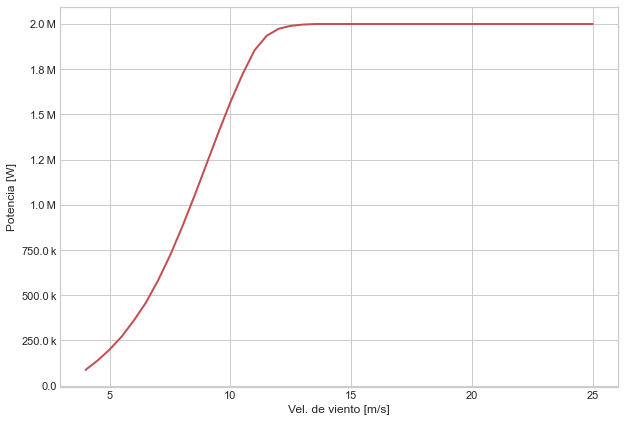

In [13]:
%matplotlib inline
fwidth = 10
fheigth = 7
plt.figure(100,figsize=(fwidth,fheigth))
plt.plot(dfCPot.index,dfCPot.pw,linewidth=2,c='r')
ax1=  plt.gca()
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
ax1.set_ylabel('Potencia [W]')
ax1.set_xlabel('Vel. de viento [m/s]')
ax1.yaxis.set_major_formatter(formatter1)
plt.plot()

if flagsaveim:
    plt.savefig('reporte/figuras/curvpfab.png')



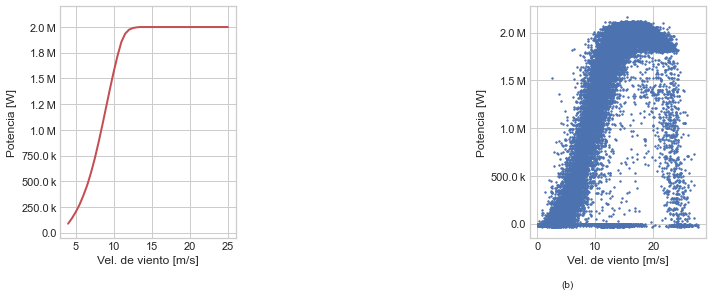

In [14]:
%matplotlib inline
fwidth = 10
fheigth = 7
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
plt.figure(101,figsize=(fwidth,4))
plt.subplot(121)
plt.plot(dfCPot.index,dfCPot.pw,linewidth=2,c='r')
ax1=  plt.gca()
ax1.set_ylabel('Potencia [W]')
ax1.set_xlabel('Vel. de viento [m/s]')
ax1.yaxis.set_major_formatter(formatter1)
plt.ylim([-50e3,2.2e6])
ax1.annotate('(b)',xy=(0.78,0.01),xycoords='figure fraction'  )

plt.subplot(122)
plt.scatter(dataVP.vViento,dataVP.Pw,s=2)
ax2=  plt.gca()
ax2.set_ylabel('Potencia [W]')
ax2.set_xlabel('Vel. de viento [m/s]')
ax2.yaxis.set_major_formatter(formatter1)
plt.tight_layout()

if flagsaveim:
    plt.savefig('reporte/figuras/crvFabReal.png')




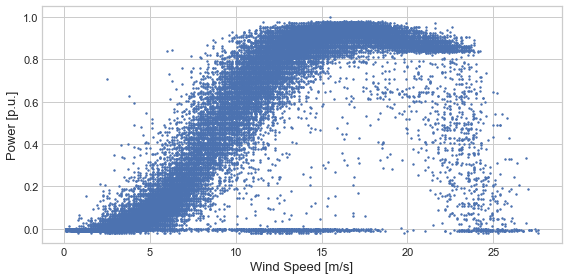

In [15]:
%matplotlib inline
# nube de puntos dividida entre max pot
fwidth = 8
fheigth = 11
#formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
plt.figure(102,figsize=(fwidth,4))

plt.scatter(dataVP.vViento,dataVP.Pw/dataVP.Pw.max(),s=2)
ax=  plt.gca()
ax.set_ylabel('Power [p.u.]',fontsize=13)
ax.set_xlabel('Wind Speed [m/s]',fontsize=13)
#ax.yaxis.set_major_formatter(formatter1)

plt.tight_layout()

if flagsaveim:
    plt.savefig('fig_art/crvNubePts.png')
plt.savefig('fig_art/crvNubePts.png')



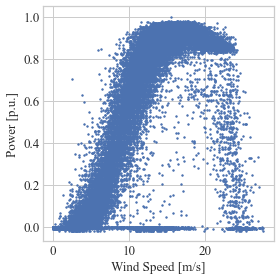

In [16]:
fontsize = 13
labelFontSize = 13
tickFontSize = 12
markerSize = 100
fontNameLabel = {'fontname':'Times New Roman'}
fontNameCluster = {'fontname':'Arial'}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
        size=labelFontSize, weight='normal', stretch='normal')   

# nube de puntos dividida entre max pot
fwidth = 8
fheigth = 11
#formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
plt.figure(102,figsize=(4,4))

plt.scatter(dataVP.vViento,dataVP.Pw/dataVP.Pw.max(),s=2)
ax=  plt.gca()
ax.set_ylabel('Power [p.u.]',fontsize=13,**fontNameLabel)
ax.set_xlabel('Wind Speed [m/s]',fontsize=13,**fontNameLabel)
#ax.yaxis.set_major_formatter(formatter1)

for label in plt.gca().get_xticklabels():
        label.set_fontproperties(ticks_font)
for label in plt.gca().get_yticklabels():
        label.set_fontproperties(ticks_font)
plt.tight_layout()

if flagsaveim:
    plt.savefig('fig_art/crvNubePts.png')
plt.savefig('fig_art/curv_pot_real.png')


In [17]:
dataVP.vViento/dataVP.vViento.max()

PCTimeStamp
2016-01-01 00:00:00    0.460145
2016-01-01 00:10:00    0.536232
2016-01-01 00:20:00    0.586957
2016-01-01 00:30:00    0.539855
2016-01-01 00:40:00    0.586957
                         ...   
2017-01-01 23:00:00    0.028986
2017-01-01 23:10:00    0.036232
2017-01-01 23:20:00    0.043478
2017-01-01 23:30:00    0.039855
2017-01-01 23:40:00    0.021739
Name: vViento, Length: 52530, dtype: float64

##  Histograma

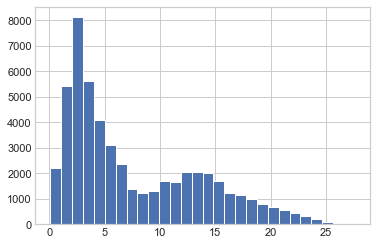

In [18]:
#histograma de velocidades
bins = int(np.around(dataVP.vViento.max()))
plt.figure()
plt.hist(dataVP.vViento,bins=bins)
plt.show()


## Histograma 3D

Bbox(x0=0.125, y0=0.125, x1=0.4068181818181818, y1=0.88)


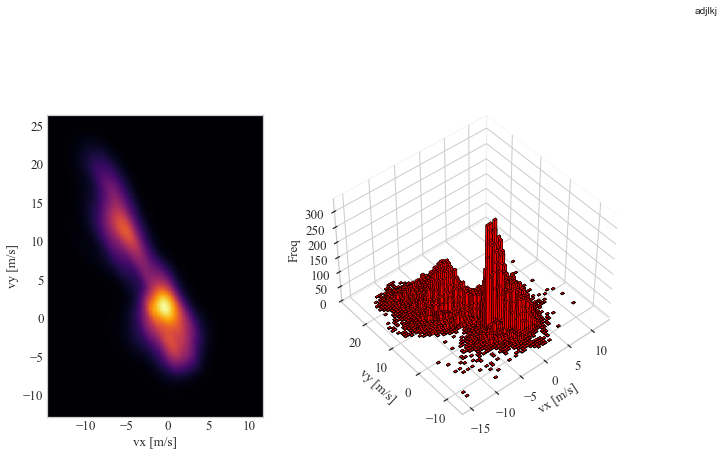

In [19]:
#en esta celda se usa gridspec para cambiar el tamaño de subplots individuales
%matplotlib inline
from scipy.stats import kde

pltfstitle =10 #tamaño de fuente
pltfslbl =13
nbins =60

H, xedges, yedges = np.histogram2d(dfVecVel.vx.values, dfVecVel.vy.values,bins=nbins )
H=H.T;
#
# Create an X-Y mesh of the same dimension as the 2D data. You can
# think of this as the floor of the plot.
#

x_data, y_data = np.meshgrid( xedges[:-1],yedges[:-1])
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = H.flatten()

# Create a figure for plotting the data as a 3D histogram.
#
fig = plt.figure(figsize=(10,7))

# eliminar elementos con frecuencia zero
a = z_data[z_data != 0]
idx=np.where(z_data == 0)[0]
b=np.delete(x_data,idx)
c=np.delete(y_data,idx)
z_data=a
x_data=b
y_data=c

# tres graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')
#grid = plt.GridSpec(2,2, wspace=0.3, hspace=0.1)
#axScatter=fig.add_subplot(grid[0, 0])
#axDensity= fig.add_subplot(grid[0, 1])
#axHist2d =fig.add_subplot(grid[1,0: ], projection='3d')

# dos graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')

grid = plt.GridSpec(1, 2,width_ratios=[1,1.5])
#axScatter=fig.add_subplot(grid[0, 0])
axDensity= fig.add_subplot(grid[0, 0])
axHist2d =fig.add_subplot(grid[0,1 ], projection='3d')

# axDensity = plt.subplot2grid(shape=(1, 3), loc=(0, 0), colspan=1)
# axHist2d = plt.subplot2grid(shape=(1, 3), loc=(0, 1), colspan=2, projection='3d')


#SCATTER
#axScatter.scatter(dfVecVel.vx,dfVecVel.vy,s=0.6)
#axScatter.set_ylabel('vy [m/s]', fontsize = pltfslbl) 
#axScatter.set_xlabel('vx [m/s]', fontsize = pltfslbl) 
##axScatter.set_aspect('equal')
#axScatter.set_xticks(np.arange(np.around(dfVecVel.vx.min()),dfVecVel.vx.max(),5))

#DENSITY PLOT
data = np.array(dfVecVel.values.tolist())
x, y = data.T
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

axDensity.set_ylabel('vy [m/s]', fontsize = pltfslbl,fontname='Times New Roman') 
axDensity.set_xlabel('vx [m/s]', fontsize = pltfslbl,fontname='Times New Roman') 
axDensity.tick_params(axis='both', labelsize = pltfslbl)
axDensity.set_aspect('auto')
axDensity.set_xticks(np.arange(np.around(dfVecVel.vx.min()),dfVecVel.vx.max(),5))


#guardo el objeto pcolormesh para obtener su cmap
axDensity.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.inferno)

#HIST2D

axHist2d.tick_params(axis='both', labelsize = pltfslbl)
ancho_barra =0.5
largo_barra = 0.5
axHist2d.bar3d( x_data,
          y_data,
          np.zeros_like(z_data),
          ancho_barra, largo_barra, z_data, shade=False,
         color = 'red',edgecolors='black', linewidth=0.5)
axHist2d.xaxis.pane.fill = False
axHist2d.yaxis.pane.fill = False
axHist2d.zaxis.pane.fill = False
#axHist2d.set_aspect('auto')

#Vista del histograma 3d
axHist2d.view_init(45,-130)
axHist2d.set_ylabel('vy [m/s]', fontsize = pltfslbl,fontname='Times New Roman') 
axHist2d.set_xlabel('vx [m/s]', fontsize = pltfslbl,fontname='Times New Roman') 
axHist2d.set_zlabel('Freq', fontsize = pltfslbl, rotation= 90,fontname='Times New Roman') 

for label in axDensity.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in axDensity.get_yticklabels():
    label.set_fontproperties(ticks_font)        
    
for label in axHist2d.get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in axHist2d.get_yticklabels():
    label.set_fontproperties(ticks_font)        
for label in axHist2d.get_zticklabels():
    label.set_fontproperties(ticks_font)

print(axDensity.get_position())
axDensity.set_position(mtransforms.Bbox.from_bounds(0.1,0.2,0.3,0.6))
#plt.tight_layout(w_pad=15)
axDensity.text(1,1,'adjlkj',transform=fig.transSubfigure)
#plt.ion()
if flagsaveim:
    figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
    #plt.savefig('fig_art/scatter_pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)
    plt.savefig('fig_art/pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)
figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
plt.savefig('fig_art/pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)


plt.show()



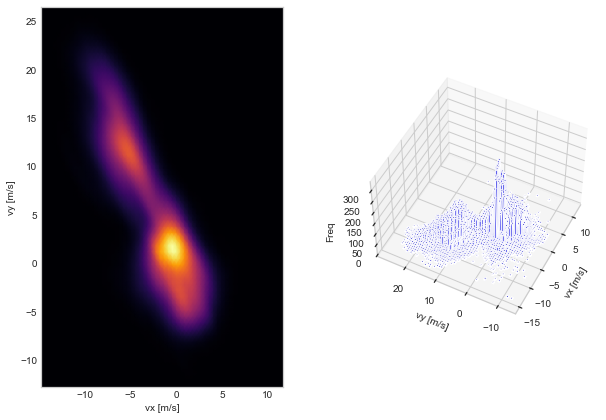

In [20]:
%matplotlib inline
from scipy.stats import kde

pltfstitle =10 #tamaño de fuente
pltfslbl =10
nbins =60

H, xedges, yedges = np.histogram2d(dfVecVel.vx.values, dfVecVel.vy.values,bins=nbins )
H=H.T;
#
# Create an X-Y mesh of the same dimension as the 2D data. You can
# think of this as the floor of the plot.
#

x_data, y_data = np.meshgrid( xedges[:-1],yedges[:-1])
# Flatten out the arrays so that they may be passed to "ax.bar3d".
# Basically, ax.bar3d expects three one-dimensional arrays:
# x_data, y_data, z_data. The following call boils down to picking
# one entry from each array and plotting a bar to from
# (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
#
x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = H.flatten()

# Create a figure for plotting the data as a 3D histogram.
#
fig = plt.figure(figsize=(10,7))

# eliminar elementos con frecuencia zero
a = z_data[z_data != 0]
idx=np.where(z_data == 0)[0]
b=np.delete(x_data,idx)
c=np.delete(y_data,idx)
z_data=a
x_data=b
y_data=c

# tres graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')
#grid = plt.GridSpec(2,2, wspace=0.3, hspace=0.1)
#axScatter=fig.add_subplot(grid[0, 0])
#axDensity= fig.add_subplot(grid[0, 1])
#axHist2d =fig.add_subplot(grid[1,0: ], projection='3d')

# dos graficas
#cmap del histograma2d. Es un array de nx 4 elementos (rgba)
#histograma 3d
#ax = fig.add_subplot(121, projection='3d')

grid = plt.GridSpec(1,2, wspace=0.3, hspace=0.1)
#axScatter=fig.add_subplot(grid[0, 0])
axDensity= fig.add_subplot(grid[0, 0])
axHist2d =fig.add_subplot(grid[0,1 ], projection='3d')

#SCATTER
#axScatter.scatter(dfVecVel.vx,dfVecVel.vy,s=0.6)
#axScatter.set_ylabel('vy [m/s]', fontsize = pltfslbl) 
#axScatter.set_xlabel('vx [m/s]', fontsize = pltfslbl) 
##axScatter.set_aspect('equal')
#axScatter.set_xticks(np.arange(np.around(dfVecVel.vx.min()),dfVecVel.vx.max(),5))

#DENSITY PLOT
data = np.array(dfVecVel.values.tolist())
x, y = data.T
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

axDensity.set_ylabel('vy [m/s]', fontsize = pltfslbl) 
axDensity.set_xlabel('vx [m/s]', fontsize = pltfslbl) 
axDensity.tick_params(axis='both', labelsize = pltfslbl)
axDensity.set_aspect('auto')
axDensity.set_xticks(np.arange(np.around(dfVecVel.vx.min()),dfVecVel.vx.max(),5))


#guardo el objeto pcolormesh para obtener su cmap
axDensity.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.inferno)

#HIST2D

axHist2d.tick_params(axis='both', labelsize = pltfslbl)
ancho_barra =0.5
largo_barra = 0.5
axHist2d.bar3d( x_data,
          y_data,
          np.zeros_like(z_data),
          ancho_barra, largo_barra, z_data, shade=True,
         color = 'blue', )
axHist2d.xaxis.pane.fill = True
axHist2d.yaxis.pane.fill = True
axHist2d.zaxis.pane.fill = True
axHist2d.set_aspect('auto')

#Vista del histograma 3d
axHist2d.view_init(50,-153)
axHist2d.set_ylabel('vy [m/s]', fontsize = pltfslbl) 
axHist2d.set_xlabel('vx [m/s]', fontsize = pltfslbl) 
axHist2d.set_zlabel('Freq', fontsize = pltfslbl, rotation= 90) 


#plt.ion()
if flagsaveim:
    figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
    #plt.savefig('fig_art/scatter_pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)
    plt.savefig('fig_art/pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)
#figsavetime = datetime.datetime.now().strftime("%d-%m-%Y_%H_%M_%S_%f")
#plt.savefig('fig_art/pdf_hist2d_'+ figsavetime +'.png', bbox_inches='tight', pad_inches=0.1)

    
plt.show()



## Series de tiempo

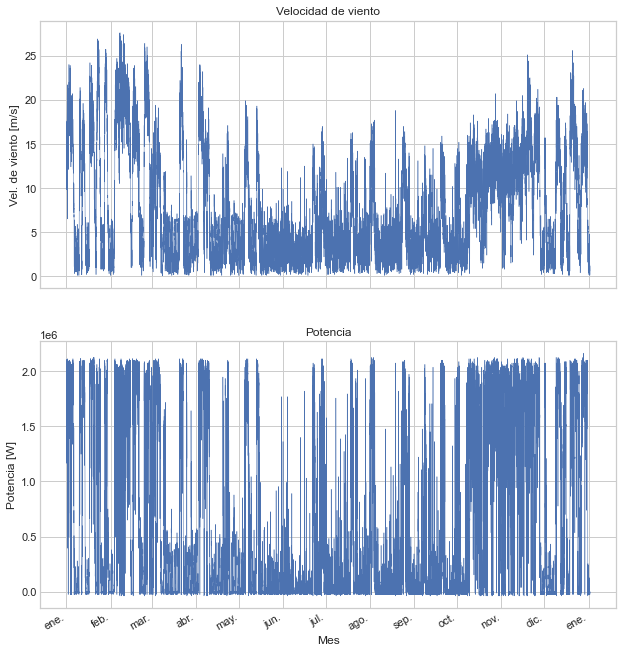

In [21]:
fwidth = 10
fheigth = 12

uniqMonths =dataVP.index.strftime("%m/%y").unique().tolist()

fig,(axvv,axvp)=plt.subplots(nrows=2,sharex=True,figsize=(fwidth,fheigth),frameon=False)
#plot de la velocidad de viento
# axvv=plt.subplot(211,sharex=axvv)
axvv.plot(dataVP.index,dataVP.vViento,linewidth=0.5)
axvv.set_ylabel('Vel. de viento [m/s]')
axvv.set_title('Velocidad de viento')
# axvp = plt.subplot(212,sharex=axvv)
axvp.plot(dataVP.index,dataVP.Pw,linewidth=0.5)
fig.autofmt_xdate()

axvp.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axvp.xaxis.set_major_locator(mdates.MonthLocator(range(1,len(uniqMonths))))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axvp.set_ylabel('Potencia [W]')
axvp.set_xlabel('Mes')
axvp.set_title('Potencia')
fig.subplots_adjust(top=0.88,left=0.1)
if flagsaveim:
    plt.savefig('reporte/figuras/seriesvvvp.png')


## Scatter con colores

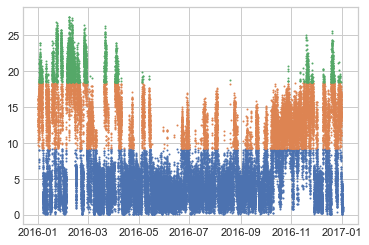

In [22]:
tercio = dataVP.vViento.max()/3
d1 =dataVP[dataVP.vViento<=tercio]
d2 =dataVP[(dataVP.vViento>tercio) & (dataVP.vViento<tercio*2)]
d3= dataVP[dataVP.vViento>tercio*2]
plt.figure()
plt.scatter(d1.index,d1.vViento,s=1)
plt.scatter(d2.index,d2.vViento,s=1)
plt.scatter(d3.index,d3.vViento,s=1)


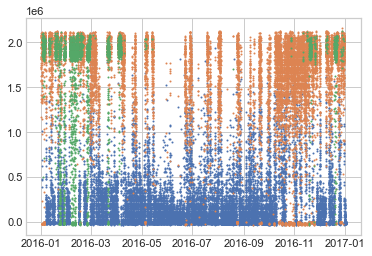

In [23]:
plt.figure()
plt.scatter(d1.index,d1.Pw,s=1)
plt.scatter(d2.index,d2.Pw,s=1)
plt.scatter(d3.index,d3.Pw,s=1)

## Plot velocidad de viento vxvy y potencia

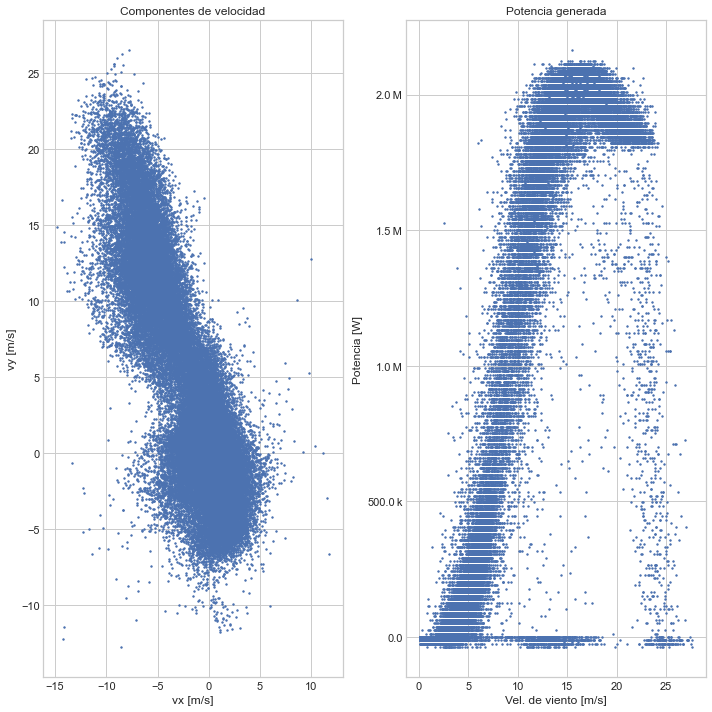

In [24]:

formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
fig,(axvv,axvp)=plt.subplots(ncols=2,figsize=(fwidth,fheigth-2))
axvv.scatter(dfVecVel.vx,dfVecVel.vy,s=2)
axvv.set_ylabel('vy [m/s]')
axvv.set_xlabel('vx [m/s]')
axvv.set_title('Componentes de velocidad')
axvp.scatter(dataVP.vViento,dataVP.Pw,s=2)
axvp.yaxis.set_major_formatter(formatter1)
#plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axvp.set_ylabel('Potencia [W]')
axvp.set_xlabel('Vel. de viento [m/s]')
axvp.set_title('Potencia generada')
fig.subplots_adjust(top=0.88,left=0.1)
plt.tight_layout()
if flagsaveim:
    plt.savefig('reporte/figuras/plotvvp.png')
    #falta agregar la rosa de los vientos al p lot
       

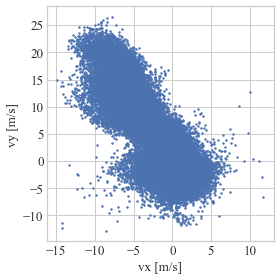

In [25]:
fontsize = 13
labelFontSize = 13
tickFontSize = 12
markerSize = 100
fontNameLabel = {'fontname':'Times New Roman'}
fontNameCluster = {'fontname':'Arial'}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
        size=labelFontSize, weight='normal', stretch='normal')        

formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
plt.figure(figsize=(4,4))
plt.scatter(dfVecVel.vx,dfVecVel.vy,s=2)
plt.ylabel('vy [m/s]',fontsize = labelFontSize, **fontNameLabel)
plt.xlabel('vx [m/s]',fontsize = labelFontSize, **fontNameLabel)
for label in plt.gca().get_xticklabels():
        label.set_fontproperties(ticks_font)
for label in plt.gca().get_yticklabels():
        label.set_fontproperties(ticks_font)
plt.tight_layout()
if flagsaveim:
    plt.savefig('reporte/figuras/plotvvp.png')
plt.savefig('fig_art/scatterwindvel.png')

    #falta agregar la rosa de los vientos al p lot

## Varias gráficas en una

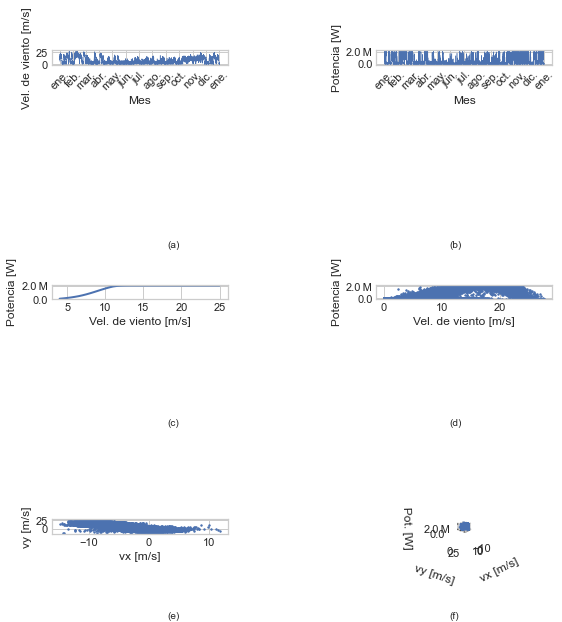

In [26]:
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009

fig = plt.figure(figsize=(8,8))
axsv= plt.subplot2grid((3, 4), (0, 0), colspan=2)
axsp = plt.subplot2grid((3, 4), (0, 2), colspan=2)
axfab = plt.subplot2grid((3, 4), (1, 0), colspan=2)
axreal= plt.subplot2grid((3, 4), (1, 2), colspan=2)
axvxvy =plt.subplot2grid((3, 4), (2, 0), colspan=2)
ax3d =plt.subplot2grid((3, 4), (2, 2), colspan=2, projection='3d')
fig = plt.gcf()




#plot de la velocidad de viento
# axvv=plt.subplot(211,sharex=axvv)
axsv.plot(dataVP.index,dataVP.vViento,linewidth=0.5)
axsv.set_ylabel('Vel. de viento [m/s]')
#axvv.set_title('Velocidad de viento')
axsv.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axsv.xaxis.set_major_locator(mdates.MonthLocator(range(1,len(uniqMonths))))
axsv.set_xlabel('Mes')

plt.setp(axsv.xaxis.get_majorticklabels(), rotation=45)

# axvp = plt.subplot(212,sharex=axvv)
axsp.plot(dataVP.index,dataVP.Pw,linewidth=0.5)
#fig.autofmt_xdate()
axsp.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axsp.xaxis.set_major_locator(mdates.MonthLocator(range(1,len(uniqMonths))))
axsp.set_ylabel('Potencia [W]')
axsp.set_xlabel('Mes')
#axvp.set_title('Potencia')
axsp.yaxis.set_major_formatter(formatter1)
plt.setp(axsp.xaxis.get_majorticklabels(), rotation=45)

axfab.plot(dfCPot.index,dfCPot.pw,linewidth=2)
axfab.set_ylabel('Potencia [W]')
axfab.set_xlabel('Vel. de viento [m/s]')
axfab.yaxis.set_major_formatter(formatter1)

axreal.scatter(dataVP.vViento,dataVP.Pw,s=2)
axreal.yaxis.set_major_formatter(formatter1)
axreal.set_ylabel('Potencia [W]')
axreal.set_xlabel('Vel. de viento [m/s]')

axvxvy.scatter(dfVecVel.vx,dfVecVel.vy,s=2)
axvxvy.set_ylabel('vy [m/s]')
axvxvy.set_xlabel('vx [m/s]')


ax3d.scatter(dfVecVel.vx, dfVecVel.vy, dataVP.Pw,s=1)
ax3d.zaxis.set_major_formatter(formatter1)

ax3d.view_init(elev=20, azim=40)
ax3d.set_xlabel('\n' +'vx [m/s]', linespacing=1)
ax3d.set_ylabel('\n' +'vy [m/s]', linespacing=1)
ax3d.set_zlabel('\n' +'Pot. [W]', linespacing=1)
ax3d.xaxis.pane.fill = False
ax3d.yaxis.pane.fill = False
ax3d.zaxis.pane.fill = False
# Now set color to white (or whatever is "invisible")
ax3d.xaxis.pane.set_edgecolor('w')
ax3d.yaxis.pane.set_edgecolor('w')
ax3d.zaxis.pane.set_edgecolor('w')

plt.annotate('(a)',xy=(0.29,0.65),xycoords='figure fraction'  )
plt.annotate('(b)',xy=(0.78,0.65),xycoords='figure fraction'  )
plt.annotate('(c)',xy=(0.29,0.34),xycoords='figure fraction'  )
plt.annotate('(d)',xy=(0.78,0.34),xycoords='figure fraction'  )
plt.annotate('(e)',xy=(0.29,0.005),xycoords='figure fraction'  )
plt.annotate('(f)',xy=(0.78,0.005),xycoords='figure fraction'  )
plt.tight_layout()
if flagsaveim:
    plt.savefig('reporte/figuras/figDatos.png')


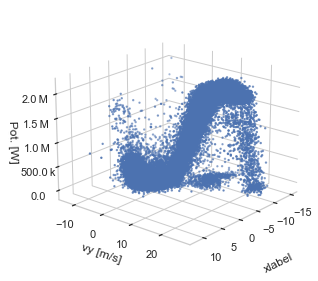

In [27]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import





fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

ax3d.scatter(dfVecVel.vx, dfVecVel.vy, dataVP.Pw,s=2)
ax3d.zaxis.set_major_formatter(formatter1)

ax3d.set_xlabel('vx [m/s]')
ax3d.set_ylabel('vy [m/s]')
ax3d.set_zlabel('Pot. [W]')
ax3d.view_init(elev=20, azim=40)
ax3d.set_xlabel('\n' + 'xlabel', linespacing=4)
ax3d.xaxis.pane.fill = False
ax3d.yaxis.pane.fill = False
ax3d.zaxis.pane.fill = False
# Now set color to white (or whatever is "invisible")
ax3d.xaxis.pane.set_edgecolor('w')
ax3d.yaxis.pane.set_edgecolor('w')
ax3d.zaxis.pane.set_edgecolor('w')
plt.tight_layout()
plt.show()

## Ejemplo de grupos

In [28]:
# from sklearn.datasets.samples_generator import make_blobs
# X, y_true = make_blobs(n_samples=10, centers=3,
#                        cluster_std=0.9, random_state=2,center_box=(1,2))
# plt.figure()
# plt.scatter(X[:, 0], X[:, 1], s=50);


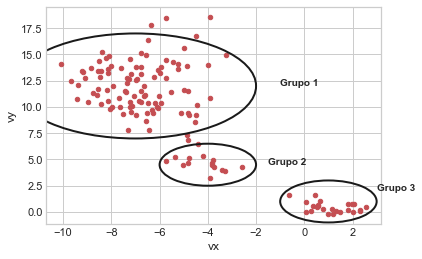

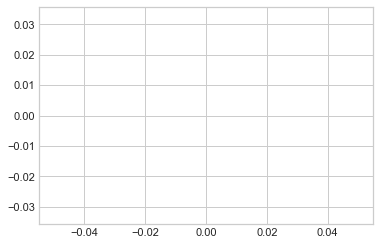

In [30]:
dfejemgrp = dfVecVel.loc[pd.to_datetime('2016-05-13 00:00'):pd.to_datetime('2016-05-13 23:00')]
plt.figure()
plt.scatter(dfejemgrp.vx,dfejemgrp.vy,s=20,c='r')
plt.xlabel('vx',fontsize=12)
plt.ylabel('vy',fontsize=12)
circg1= plt.Circle((-7,12),5,color='k',fill=False,linewidth=2)
circg2= plt.Circle((-4,4.5),2,color='k',fill=False,linewidth=2)
circg3= plt.Circle((1,1),2,color='k',fill=False,linewidth=2)

ax=plt.gca()
ax.add_artist(circg1)
ax.add_artist(circg2)
ax.add_artist(circg3)
ax.text(-1,12,'Grupo 1',fontweight='bold')
ax.text(-1.5,4.5,'Grupo 2',fontweight='bold')
ax.text(3,2,'Grupo 3',fontweight='bold')

plt.show()
plt.axis('equal')
if flagsaveim:
    plt.savefig('reporte/figuras/gruposvv.png')


## Potencias cero y negativas

In [31]:
dataVP_Neg =dataVP[dataVP.Pw<=0]
deltaT = 1/6 #10 minutos es un 
#buscando limits de potencias negativas
npwmin = 5
lpwmin = []
lpwmin.append( dataVP_Neg.Pw.min())

for i in range(1,npwmin):
    lpwmin.append( dataVP_Neg.Pw[dataVP_Neg.Pw>lpwmin[i-1]].min())

locurre = []
llabels =[]
lnhrpotneg =[]
for i in range(npwmin):
    n = len(dataVP_Neg[dataVP_Neg.Pw==lpwmin[i]])
    locurre.append(n)
    llabels.append('{:3.4f}kW'.format(lpwmin[i]/1e3))
    lnhrpotneg.append(n*10/60)
    print('{:d}-Potencia {:3.4f}kW- Ocurrencias: {:d} - Horas: {:.4f}-Consumo:{:.2f}kW'
          .format(i+1,lpwmin[i]/1e3,n,n*10/60,locurre[i]*lpwmin[i]*deltaT/1e3))
print('Total consumido:{:0.4f} kWh'.format(dataVP_Neg.Pw.sum()*deltaT/1e3))

idx =np.argsort(locurre)
llabelssort =[llabels[i] for i in idx]
lpwminsort = [lpwmin[i] for i in idx]
lnhrpotnegsort =[lnhrpotneg[i] for i in idx]
locurresort = [locurre[i] for i in idx]



1-Potencia -38.1704kW- Ocurrencias: 77 - Horas: 12.8333-Consumo:-489.85kW
2-Potencia -25.4469kW- Ocurrencias: 1194 - Horas: 199.0000-Consumo:-5063.93kW
3-Potencia -19.0852kW- Ocurrencias: 3 - Horas: 0.5000-Consumo:-9.54kW
4-Potencia -12.7235kW- Ocurrencias: 10012 - Horas: 1668.6667-Consumo:-21231.20kW
5-Potencia 0.0000kW- Ocurrencias: 7419 - Horas: 1236.5000-Consumo:0.00kW
Total consumido:-26794.5259 kWh


### Stem potencias cero y negativas

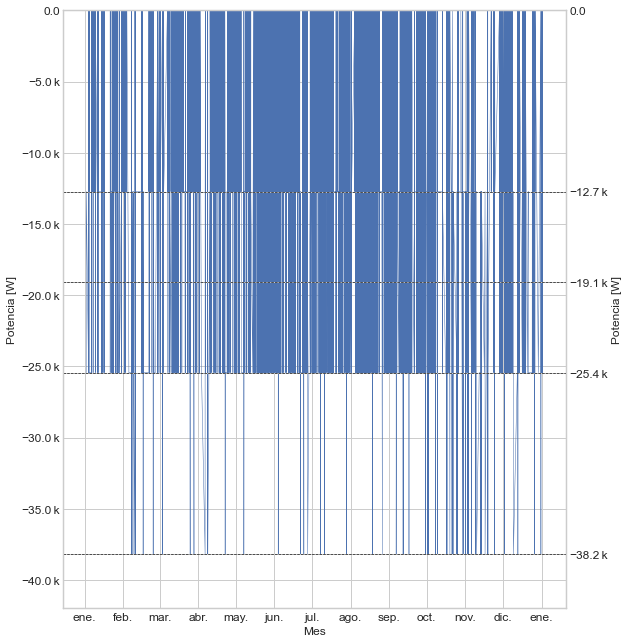

In [32]:
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
plt.figure(figsize=(fwidth-1,fheigth-1))
plt.plot(dataVP_Neg.index,dataVP_Neg.Pw,linewidth=.5)
# _, stemlines, _ =plt.stem(dataVP_Neg.index,dataVP_Neg.Pw, markerfmt=" ")
# plt.setp(stemlines, 'linewidth', 0.5)
plt.ylim([dataVP_Neg.Pw.min()*1.1,0])
ax1=  plt.gca()
ax1.set_ylabel('Potencia [W]',fontsize=12)
ax1.set_xlabel('Mes',fontsize=12)
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(range(1,len(uniqMonths))))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.yaxis.set_major_formatter(formatter1)
ax2.set_ylabel('Potencia [W]',fontsize=12)
ax2.tick_params(labelsize=12)

for i in range(len(lpwmin)):
    plt.axhline(y=lpwmin[i],linestyle='--',linewidth=0.7,c='k')

plt.yticks(lpwmin)
ax2.yaxis.set_major_formatter(formatter1)
plt.ylim([dataVP_Neg.Pw.min()*1.1,0])

#anotaciones de potencias negativas (NO SE USAN)
bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.7)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=100, va="center",fontsize=10)
horizontalalignment = {-1: "center", 1: "center"}
connectionstyle = "angle,angleA=0,angleB=90"
kw["arrowprops"].update({"connectionstyle": connectionstyle,'color':'black','linewidth':0.9})


for p in list(dataVP_Neg.Pw.unique()):
    temp = dataVP[dataVP.Pw==p]
    if len(temp)==1:#una sola potencia
        fecha  = temp.index.strftime( '%d/%B/%y').format()[0]
        hora = temp.index.strftime( '%H:%M').format()[0]
        x = temp.index 
        y= temp.Pw
        
        plt.annotate(fecha + '\n'+hora,xy=(x,y), xytext=(x+ pd.DateOffset(months=1), y*1.07),ha='center',**kw)

plt.show()
if flagsaveim:
    plt.savefig('reporte/figuras/stempotneg.png')


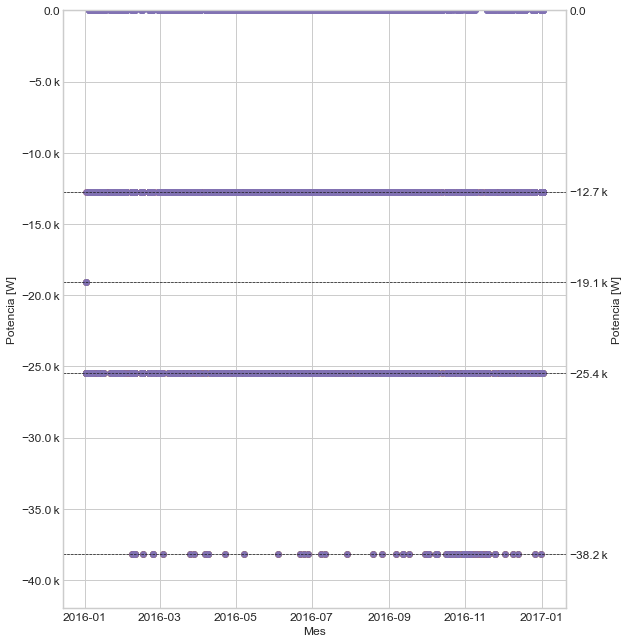

In [33]:
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
plt.figure(figsize=(fwidth-1,fheigth-1))
# _, stemlines, _ =plt.stem(dataVP_Neg.index,dataVP_Neg.Pw, markerfmt=" ")
# plt.setp(stemlines, 'linewidth', 0.5)
plt.ylim([dataVP_Neg.Pw.min()*1.1,0])
ax1=  plt.gca()
ax1.set_ylabel('Potencia [W]',fontsize=12)
ax1.set_xlabel('Mes',fontsize=12)
ax1.tick_params(labelsize=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator(range(1,len(uniqMonths))))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1.yaxis.set_major_formatter(formatter1)
ax2.set_ylabel('Potencia [W]',fontsize=12)
ax2.tick_params(labelsize=12)

for i in range(len(lpwmin)):
    temp =dataVP_Neg[dataVP_Neg.Pw<=lpwmin[i]]
    plt.scatter(temp.index,temp.Pw,linewidth=.5)
    plt.axhline(y=lpwmin[i],linestyle='--',linewidth=0.7,c='k')


plt.yticks(lpwmin)
ax2.yaxis.set_major_formatter(formatter1)
plt.ylim([dataVP_Neg.Pw.min()*1.1,0])
#anotaciones de potencias negativas
bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.7)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=100, va="center",fontsize=10)
horizontalalignment = {-1: "center", 1: "center"}
connectionstyle = "angle,angleA=0,angleB=90"
kw["arrowprops"].update({"connectionstyle": connectionstyle,'color':'black','linewidth':0.9})


for p in list(dataVP_Neg.Pw.unique()):
    temp = dataVP[dataVP.Pw==p]
    if len(temp)==1:#una sola potencia
        fecha  = temp.index.strftime( '%d/%B/%y').format()[0]
        hora = temp.index.strftime( '%H:%M').format()[0]
        x = temp.index 
        y= temp.Pw
        
        plt.annotate(fecha + '\n'+hora,xy=(x,y), xytext=(x+ pd.DateOffset(months=1), y*1.07),ha='center',**kw)

plt.show()
if flagsaveim:
    plt.savefig('reporte/figuras/stempotneg.png')
#plt.savefig('reporte/figuras/stempotneg.png')


###  Inicio pie charts


In [34]:
# NO SE OCUPA PUES SON SOLO 4 POTENCIAS NEGATIVAS Y UN CERO
#agrupar eventos menores 
mena=12 #menor a n ocurrencias
cotro = 0 #contador de otros
potro=0 #suma de potencias otro
locred =[]#locurre reducido
llabred=[]
lpwminred =[]

for i in range(len(locurre)):
    if locurre[i] <= mena:
        cotro =cotro+locurre[i]
        potro = potro+lpwmin[i]*locurre[i]
    else:
        locred.append(locurre[i])
        llabred.append(llabels[i])
        lpwminred.append(lpwmin[i])
#añadiendo el "otro"        
locred.append(cotro)
llabred.append('Otro')
lpwminred.append(potro)
idx =np.argsort(locred)
llabredsort =[llabred[i] for i in idx]
lpwminredsort = [lpwminred[i] for i in idx]
lnhrpotnegsort =[lnhrpotneg[i] for i in idx]
locredsort = [locred[i] for i in idx]

lsumpot = []# potencias multiplicadas por sus ocurrencias
lsumpot.append(lpwminredsort[0])
for i in range(1,len(lpwminredsort)):
    lsumpot.append(lpwminredsort[i]*locredsort[i])


### Pie chart normal (potencia)

In [35]:
len(locredsort
)

5

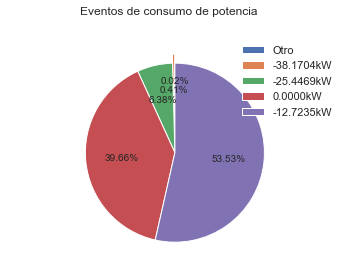

No. de eventos: 3 - Pot. consumida: Otro - Total -57.256kW
No. de eventos: 77 - Pot. consumida: -38.1704kW - Total -2939.117kW
No. de eventos: 1194 - Pot. consumida: -25.4469kW - Total -30383.599kW
No. de eventos: 7419 - Pot. consumida: 0.0000kW - Total 0.000kW
No. de eventos: 10012 - Pot. consumida: -12.7235kW - Total -127387.184kW
Potencia total consumida: -160767.156kW
Potencia total consumida (datos): -160767.156kW


In [36]:

explode = (0.2,0.1, 0, 0,0)  # explode 1st slice

plt.figure()
plt.suptitle('Eventos de consumo de potencia')
plt. pie(locredsort, autopct='%1.2f%%',explode=explode,
        shadow=False, startangle=90)
plt.gca().axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(labels=llabredsort)
plt.show()    

sumpotneg=lpwminredsort[0]/1e3
print('No. de eventos: %d - Pot. consumida: %s - Total %0.3fkW'%(locredsort[0],llabredsort[0],
                                                                     lpwminredsort[0]/1e3))
for i in range(1,len(locred)):
    print('No. de eventos: %d - Pot. consumida: %s - Total %0.3fkW'%(locredsort[i],llabredsort[i],
                                                                     lpwminredsort[i]*locredsort[i]/1e3))
    sumpotneg+= lpwminredsort[i]*locredsort[i]/1e3
print('Potencia total consumida: %0.3fkW'%(sumpotneg))
print('Potencia total consumida (datos): %0.3fkW'%(dataVP_Neg.Pw.sum()/1e3))

### Pie chart (potencia)

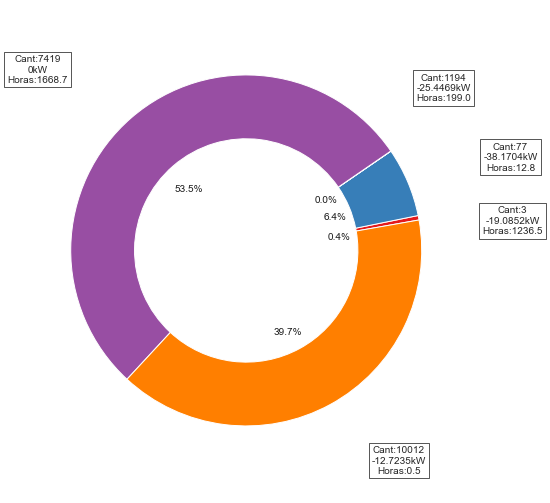

In [37]:
#pie chart
from matplotlib.text import OffsetFrom


cmap = plt.get_cmap("Set1")
colors = cmap(range(cmap.N))


fig, ax = plt.subplots(figsize=(fwidth-3, fheigth-3), subplot_kw=dict(aspect="equal"))
data = locurre
explode = (0,0, 0, 0,0)  
wedges, texts,textspct = ax.pie(data, wedgeprops=dict(width=0.4), startangle=10, autopct='%1.1f%%',
                         textprops={'color':"k",'fontsize': 10,'va':'top'}, 
                         pctdistance=1,colors=colors,explode=explode,radius=1.1)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center",fontsize=10)

#lista que enumera (numero de elemento,objeto wedge)
lwedges =[(i, j) for i, j in enumerate(wedges)]
lwedges=[]
n=len(wedges)-1
for w in wedges:
    lwedges.append((n,w))
    n=n-1
#inviertiendo el orden de las listas para que el gráfico se dibuje mejor
rlocurresort = list(reversed(locurresort))
rlpwminsort=list(reversed(lpwminsort))
rlnhrpotnegsort=list(reversed(lnhrpotnegsort))

boxxy=[(2,1.5),(2,1.5),(1.5,1.8),(1.8,1.5),(1.7,1)]#posicion xy de las cajas
for i,p in (lwedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    #connectionstyle = "angle,angleA=,angleB=90"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
    ax.annotate('Cant:' +str(rlocurresort[i]) + '\n' 
                +'{:n}kW'.format(rlpwminsort[i]/1e3) +
                '\nHoras:{:.1f}'.format(rlnhrpotnegsort[i]), 
             xy=(x, y), xytext=(boxxy[i][0]*x,boxxy[i][1]*y),
             horizontalalignment=horizontalalignment, **kw)

#acomodando los textos de los porcentajes a mono
pctdists = [0.54, 0.55, 0.55, 0.5,0.5]

for t,d in zip(textspct, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))    

    plt.axis('equal')
plt.show()
if flagsaveim:
    plt.savefig('reporte/figuras/pieEvConsEner.png')


### Pie chart (Energía)

1-Potencia -38.1704kW- Ocurrencias: 77 - Horas: 12.8333-Consumo:-489.85kW
2-Potencia -25.4469kW- Ocurrencias: 1194 - Horas: 199.0000-Consumo:-5063.93kW
3-Potencia -19.0852kW- Ocurrencias: 3 - Horas: 0.5000-Consumo:-9.54kW
4-Potencia -12.7235kW- Ocurrencias: 10012 - Horas: 1668.6667-Consumo:-21231.20kW
Total consumido:-26794.5259 kWh


C:\Users\mungu\AppData\Local\Temp/ipykernel_50132/2606462098.py:70: DeprecationWarning: This method will be removed in a future version of Python. Use 'locale.format_string()' instead.
  '\n%s kWh'%locale.format("%.2f", rlsumpot[i]*deltaT/1e3, grouping=True) +


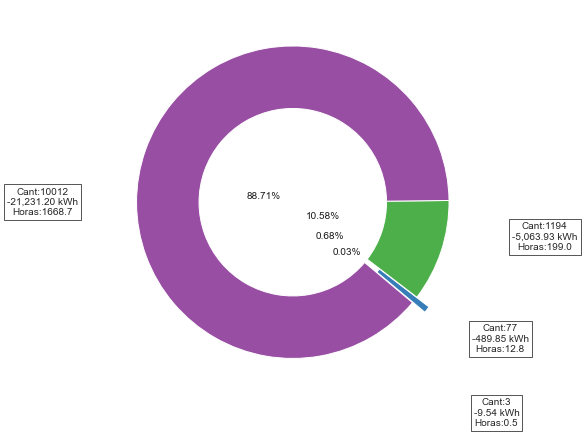

In [38]:
#este pie chart no incluye el cero pues es de consumos
dataVP_Neg =dataVP[dataVP.Pw<0]
deltaT = 1/6 #10 minutos es un sexto de hora
#buscando limits de potencias negativas
npwmin = 4
lpwmin = []
lpwmin.append( dataVP_Neg.Pw.min())

for i in range(1,npwmin):
    lpwmin.append( dataVP_Neg.Pw[dataVP_Neg.Pw>lpwmin[i-1]].min())

locurre = []
llabels =[]
lnhrpotneg =[]
for i in range(npwmin):
    n = len(dataVP_Neg[dataVP_Neg.Pw==lpwmin[i]])
    locurre.append(n)
    llabels.append('{:3.4f}kW'.format(lpwmin[i]/1e3))
    lnhrpotneg.append(n*10/60)
    print('{:d}-Potencia {:3.4f}kW- Ocurrencias: {:d} - Horas: {:.4f}-Consumo:{:.2f}kW'
          .format(i+1,lpwmin[i]/1e3,n,n*10/60,locurre[i]*lpwmin[i]*deltaT/1e3))
print('Total consumido:{:0.4f} kWh'.format(dataVP_Neg.Pw.sum()*deltaT/1e3))

idx =np.argsort(locurre)
llabelssort =[llabels[i] for i in idx]
lpwminsort = [lpwmin[i] for i in idx]
lnhrpotnegsort =[lnhrpotneg[i] for i in idx]
locurresort = [locurre[i] for i in idx]
#inviertiendo el orden de las listas para que el gráfico se dibuje mejor
rlocurresort = list(reversed(locurresort))
rlpwminsort=list(reversed(lpwminsort))
rlnhrpotnegsort=list(reversed(lnhrpotnegsort))

lsumpot = []# potencias multiplicadas por sus ocurrencias
for i in range(len(lpwminsort)):
    lsumpot.append(lpwminsort[i]*locurresort[i])
rlsumpot=list(reversed(lsumpot))

data = locurresort
explode = (0.25,0.1, 0,0)  
fig, ax = plt.subplots(figsize=(fwidth-3, fheigth-3), subplot_kw=dict(aspect="equal"))
cmap = plt.get_cmap("Set1")
colors = cmap(range(cmap.N))
wedges, texts,textspct = ax.pie(data, wedgeprops=dict(width=0.4), startangle=-40, autopct='%1.2f%%',
                         textprops={'color':"k",'fontsize': 10,'va':'top'}, 
                         pctdistance=0.2,colors=colors,explode=explode)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center",fontsize=10)

#lista que enumera (numero de elemento,objeto wedge)
lwedges =[(i, j) for i, j in enumerate(wedges)]
lwedges=[]
n=len(wedges)-1
for w in wedges:
    lwedges.append((n,w))
    n=n-1

for i,p in (lwedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    #connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    connectionstyle = "angle,angleA=0,angleB=90"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    
    ax.annotate('Cant:' +str(rlocurresort[i])+
                '\n%s kWh'%locale.format("%.2f", rlsumpot[i]*deltaT/1e3, grouping=True) +
                '\nHoras:{:.1f}'.format(rlnhrpotnegsort[i]), 
             xy=(x, y), xytext=(x*1.7,y*0.7*i),
             horizontalalignment=horizontalalignment, **kw)
plt.show()
if flagsaveim:
    plt.savefig('reporte/figuras/pieEvConsEner.png')


In [39]:
lnhrpotnegsort

[0.5, 12.833333333333334, 199.0, 1668.6666666666667]

## Estaciones

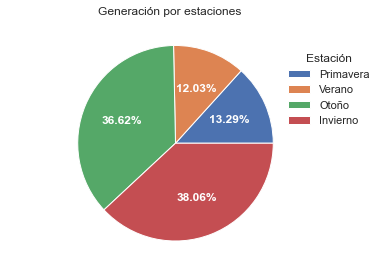


---ESTACIONES----
Potencia producida en primavera 4739.6MW
Potencia producida en verano 4290.5MW
Potencia producida en otoño 13063.9MW
Potencia producida en invierno 13576.9MW
Potencia total producida (estaciones) 35670.963 MW
Potencia total producida (datos) 35670.963 MW


In [40]:
#estaciones
primavera_inicio = pd.to_datetime('21-03-2016')
verano_inicio = pd.to_datetime('21-06-2016')
otonio_inicio = pd.to_datetime('21-09-2016') 
invierno_inicio = pd.to_datetime('21-12-2016')

maskPrim = ( (dataVP.index >=primavera_inicio ) &(dataVP.index <verano_inicio ))
potPrim = dataVP.loc[maskPrim].Pw.sum()

maskVer = ( (dataVP.index >=verano_inicio  ) &(dataVP.index <otonio_inicio ))
potVer = dataVP.loc[maskVer].Pw.sum()

maskOtonio= ( (dataVP.index >=otonio_inicio ) &(dataVP.index <invierno_inicio ))
potOtonio = dataVP.loc[maskOtonio].Pw.sum()

maskInv = ( (dataVP.index< primavera_inicio) | (dataVP.index >=invierno_inicio ))
potInv = dataVP.loc[maskInv].Pw.sum()
#energia por hora
potprimehr =  potPrim/60

lpotest=[potPrim,potVer,potOtonio,potInv]
lpotestlab = ['Primavera','Verano','Otoño','Invierno']
#pie chart

plt.figure()
plt.suptitle('Generación por estaciones')
explode= (0,0,0,0)
wedges, texts, autotexts = plt. pie(lpotest, autopct='%1.2f%%',explode=explode, textprops=dict(color="w"),
        shadow=False, startangle=0)
plt.gca().axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt .legend(wedges, lpotestlab,
          title="Estación",
          loc="center left",
          bbox_to_anchor=(0.81, 0, 0, 1.5))
plt.setp(autotexts, size=12, weight="bold")


plt.show()    




print('\n---ESTACIONES----')
print('Potencia producida en primavera {:3.1f}MW'.format(potPrim/1e6))
print('Potencia producida en verano {:3.1f}MW'.format(potVer/1e6))
print('Potencia producida en otoño {:3.1f}MW'.format(potOtonio/1e6))
print('Potencia producida en invierno {:3.1f}MW'.format(potInv/1e6))
print('Potencia total producida (estaciones) %0.3f MW'%((potInv+potOtonio+potPrim+potVer)/1e6))
print('Potencia total producida (datos) %0.3f MW'%((dataVP.Pw.sum())/1e6))




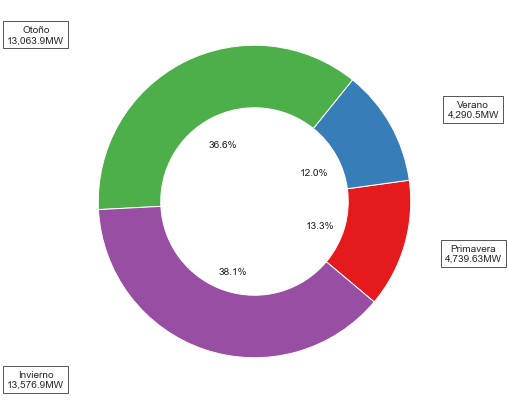


---ESTACIONES----
Potencia producida en primavera 4739.6MW
Potencia producida en verano 4290.5MW
Potencia producida en otoño 13063.9MW
Potencia producida en invierno 13576.9MW
Potencia total producida (estaciones) 35670.963 MW
Potencia total producida (datos) 35670.963 MW


In [41]:
#estaciones Potencia 
primavera_inicio = pd.to_datetime('21-03-2016')
verano_inicio = pd.to_datetime('21-06-2016')
otonio_inicio = pd.to_datetime('21-09-2016') 
invierno_inicio = pd.to_datetime('21-12-2016')

maskPrim = ( (dataVP.index >=primavera_inicio ) &(dataVP.index <verano_inicio ))
potPrim = dataVP.loc[maskPrim].Pw.sum()
enerPrim = potPrim*1/6 #cada 10 minutos es 1/6 de hora

maskVer = ( (dataVP.index >=verano_inicio  ) &(dataVP.index <otonio_inicio ))
potVer = dataVP.loc[maskVer].Pw.sum()
enerVer = potVer *1/6

maskOtonio= ( (dataVP.index >=otonio_inicio ) &(dataVP.index <invierno_inicio ))
potOtonio = dataVP.loc[maskOtonio].Pw.sum()
enerOtonio = potOtonio*1/6

maskInv = ( (dataVP.index< primavera_inicio) | (dataVP.index >=invierno_inicio ))
potInv = dataVP.loc[maskInv].Pw.sum()
enerInv = potInv*1/6

lpotest=[potPrim,potVer,potOtonio,potInv]
lenerest=[enerPrim,enerVer,enerOtonio,enerInv]
lpotestlab = ['Primavera','Verano','Otoño','Invierno']

#pie chart
cmap = plt.get_cmap("Set1")
colors = cmap(range(cmap.N))

fig, ax = plt.subplots(figsize=(fwidth-3, fheigth-3), subplot_kw=dict(aspect="equal"))


data = lpotest

wedges, texts,textspct = ax.pie(data, wedgeprops=dict(width=0.4), startangle=-40, autopct='%1.1f%%',
                         textprops={'color':"k",'fontsize': 10,'va':'top'}, 
                         pctdistance=0.44,colors=colors)

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center",fontsize=10)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(lpotestlab[i]+str('\n')+str('{:n}MW').format(lpotest[i]/1e6), 
                 xy=(x, y), xytext=(1.4*np.sign(x), 1.2*y),
                 horizontalalignment=horizontalalignment, **kw)


plt.show()
if flagsaveim:
    plt.savefig('reporte/figuras/pieGenEst.png')

print('\n---ESTACIONES----')
print('Potencia producida en primavera {:3.1f}MW'.format(potPrim/1e6))
print('Potencia producida en verano {:3.1f}MW'.format(potVer/1e6))
print('Potencia producida en otoño {:3.1f}MW'.format(potOtonio/1e6))
print('Potencia producida en invierno {:3.1f}MW'.format(potInv/1e6))
print('Potencia total producida (estaciones) %0.3f MW'%((potInv+potOtonio+potPrim+potVer)/1e6))
print('Potencia total producida (datos) %0.3f MW'%((dataVP.Pw.sum())/1e6))



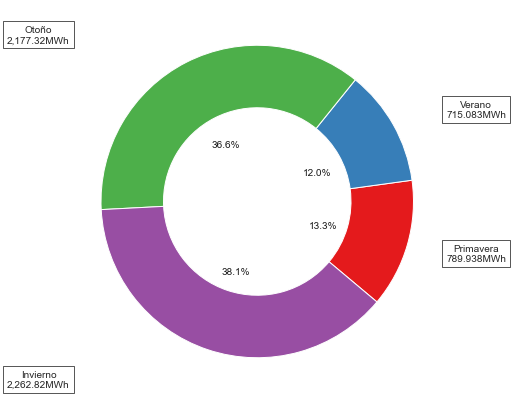


---ESTACIONES----
Energía producida en primavera 789.9MWh
Energía producida en verano 715.1MWh
Energía producida en otoño 2177.3MWh
Energía producida en invierno 2262.8MWh
Energía total producida (estaciones): 5945.160 MWh
Energía total producida (datos): 5945.160 MWh


In [42]:
#estaciones energía

#pie chart
cmap = plt.get_cmap("Set1")
colors = cmap(range(cmap.N))

fig, ax = plt.subplots(figsize=(fwidth-3, fheigth-3), subplot_kw=dict(aspect="equal"))


data = lenerest

wedges, texts,textspct = ax.pie(data, wedgeprops=dict(width=0.4), startangle=-40, autopct='%1.1f%%',
                         textprops={'color':"k",'fontsize': 10,'va':'top'}, 
                         pctdistance=0.44,colors=colors)

bbox_props = dict(boxstyle="square,pad=0.4", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center",fontsize=10)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "center", 1: "center"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(lpotestlab[i]+str('\n')+str('{:n}MWh').format(lenerest[i]/1e6), 
                 xy=(x, y), xytext=(1.4*np.sign(x), 1.2*y),
                 horizontalalignment=horizontalalignment, **kw)


plt.show()
if flagsaveim:
    plt.savefig('reporte/figuras/pieGenEstEner.png')
print('\n---ESTACIONES----')
print('Energía producida en primavera {:3.1f}MWh'.format(enerPrim/1e6))
print('Energía producida en verano {:3.1f}MWh'.format(enerVer/1e6))
print('Energía producida en otoño {:3.1f}MWh'.format(enerOtonio/1e6))
print('Energía producida en invierno {:3.1f}MWh'.format(enerInv/1e6))
print('Energía total producida (estaciones): %0.3f MWh'%((enerInv+enerOtonio+enerPrim+enerVer)/1e6))
print('Energía total producida (datos): %0.3f MWh'%((dataVP.Pw.sum())*(1/6)/1e6))



## Resumen de datos

In [43]:
print('\n------- DATOS DE VIENTO -------\n' )
print('Valores de velocidad de viento unicos: %i' % len(dataVP.vViento.unique()))
a = set(dataVP.vViento.unique())
b = set(np.arange(10,276)/10)
a = set(dataVP.vViento.unique())
b = set(np.arange(10,276)/10)
c =list(b-a)
print('Valores de velocidad de viento que faltan: %0.1f, %0.1f'%(c[0],c[1]))
#redondear los datos de direccion y velocidad 
dataDVP_redond =dataDVP.round({'Dir': 0, 'vViento': 0})
#pares vviento Dir unicos
unique_rows = np.unique(dataDVP_redond[['vViento','Dir']], axis=0)
n =len(unique_rows)
print('Pares unicos direccion de viento y velocidad redondeados: %d '%(n))
#combinaciones posibles de valores de vviento y direccion unicos
temp = len(np.unique(dataDVP_redond.Dir.values))*len(np.unique(dataDVP_redond.vViento.values))
print('Posiblesc ombinaciones de valores de vel. y direción: %i'%temp)

print('\n------- DATOS DE POTENCIA ------\n')
print('Valores de poencia unicos: %i'% len(dataVP.Pw.unique()))
#valores unicos de potencia
potarr =dataVP.Pw.values
val,cont = np.unique(potarr,return_counts = True) 
arr = np.array([val,cont]).T
dfuniPot = pd.DataFrame(arr,columns=['potencia','conteo'])
print('Conteo de valores únicosde potencia (5 primeros)')
print(dfuniPot.head())



------- DATOS DE VIENTO -------

Valores de velocidad de viento unicos: 274
Valores de velocidad de viento que faltan: 26.8, 27.3
Pares unicos direccion de viento y velocidad redondeados: 3615 
Posiblesc ombinaciones de valores de vel. y direción: 10440

------- DATOS DE POTENCIA ------

Valores de poencia unicos: 216
Conteo de valores únicosde potencia (5 primeros)
       potencia   conteo
0 -38170.350741     77.0
1 -25446.900494   1194.0
2 -19085.175371      3.0
3 -12723.450247  10012.0
4      0.000000   7419.0


In [44]:


print('\n--- POTENCIAS CERO Y NEGATIVAS ---')
pcero = len(dataVP[dataVP.Pw==0])
print('Potencias igual a cero: %i - Horas: %f' % (pcero,pcero*10/60))
print('Potencia total consumida {:3.1f}kW'.format(np.sum(lpwmin)/1e3))
print('Potencias negativas unicas:')
for p in list(dataVP_Neg.Pw.unique()):
    temp = dataVP[dataVP.Pw==p]
    if len(temp)==1:
        print('        Fecha del evento: %s -> Potencia: %0.1fkW'%
              (temp.index.strftime( '%d-%B-%Y %H:%M:%S').format()[0],temp.Pw))
    
#estaciones
primavera_inicio = pd.to_datetime('21-03-2016')
verano_inicio = pd.to_datetime('21-06-2016')
otonio_inicio = pd.to_datetime('21-09-2016') 
invierno_inicio = pd.to_datetime('21-12-2016')

maskPrim = ( (dataVP.index >=primavera_inicio ) &(dataVP.index <verano_inicio ))
potPrim = dataVP.loc[maskPrim].Pw.sum()

maskVer = ( (dataVP.index >=verano_inicio  ) &(dataVP.index <otonio_inicio ))
potVer = dataVP.loc[maskVer].Pw.sum()

maskOtonio= ( (dataVP.index >=otonio_inicio ) &(dataVP.index <invierno_inicio ))
potOtonio = dataVP.loc[maskOtonio].Pw.sum()

maskInv = ( (dataVP.index< primavera_inicio) | (dataVP.index >=invierno_inicio ))
potInv = dataVP.loc[maskInv].Pw.sum()

pctPotOtInv = (potInv+potOtonio)/dataVP.Pw.sum() *100
pctPotPrimVer = (potVer+potPrim)/dataVP.Pw.sum() *100
razonPotEst = (potInv+potOtonio)/(potVer+potPrim)
print('\n--- ESTACIONES ---')
print('Potencia producida en primavera {:3.1f}MW'.format(potPrim/1e6))
print('Potencia producida en verano {:3.1f}MW'.format(potVer/1e6))
print('Potencia producida en otoño {:3.1f}MW'.format(potOtonio/1e6))
print('Potencia producida en invierno {:3.1f}MW'.format(potInv/1e6))
print('Potencia total producida (estaciones) %0.3f MW'%((potInv+potOtonio+potPrim+potVer)/1e6))
print('Potencia total producida (datos) %0.3f MW'%((dataVP.Pw.sum())/1e6))
print('Porcentaje de potencia, OtInv= %0.1f%% PrimVer=%0.1f%% '%(pctPotOtInv,pctPotPrimVer))
print('Razon de producción de potencia por estaciones OI-PV:%0.1f'%razonPotEst)



--- POTENCIAS CERO Y NEGATIVAS ---
Potencias igual a cero: 7419 - Horas: 1236.500000
Potencia total consumida -95.4kW
Potencias negativas unicas:

--- ESTACIONES ---
Potencia producida en primavera 4739.6MW
Potencia producida en verano 4290.5MW
Potencia producida en otoño 13063.9MW
Potencia producida en invierno 13576.9MW
Potencia total producida (estaciones) 35670.963 MW
Potencia total producida (datos) 35670.963 MW
Porcentaje de potencia, OtInv= 74.7% PrimVer=25.3% 
Razon de producción de potencia por estaciones OI-PV:3.0


### Potencias negativas

In [45]:
ldf = []
vmin=[]
vmax=[]
moda =[]
conteo=[]
pot = []
for p in list(dataVP_Neg.Pw.unique()):
    vmin.append( dataVP[dataVP.Pw==p].vViento.min())
    vmax.append(dataVP[dataVP.Pw==p].vViento.max())
    moda.append(dataVP[dataVP.Pw==p].mode().vViento[0])
    conteo.append( len(dataVP[dataVP.Pw==p]))
    pot.append(p)
data = [pot, conteo , vmin, vmax, moda]
data = list(map(list, zip(*data)))#Transpuesta de lista
dfcontpotneg = pd.DataFrame(data,columns=['potencia','conteo','vmin','vmax','moda'])
dfcontpotneg

,potencia,conteo,vmin,vmax,moda
0,-25446.900494,1194,0.1,27.5,2.6
1,-19085.175371,3,14.7,16.1,14.7
2,-12723.450247,10012,0.1,27.6,2.6
3,-38170.350741,77,0.8,27.6,11.5


# 4. Factor de planta

In [46]:
dataVP.head()

,vViento,Pw
PCTimeStamp,,
2016-01-01 00:00:00,12.7,1.953050e+06
2016-01-01 00:10:00,14.8,2.067561e+06
2016-01-01 00:20:00,16.2,2.048475e+06
2016-01-01 00:30:00,14.9,2.080284e+06
2016-01-01 00:40:00,16.2,2.073922e+06


In [47]:
#factor de planta = potencia producida/(potencia nominal*numero de horas)
td = dataVP.index[-1]- dataVP.index[0] #timedelta que resta la ultima fecha a la primera
tdrd =td.round('H') #redondea a horas. Son 366 23:40, redondea a 367
horasTotal = tdrd/pd.Timedelta(hours=1) #numero horas del total de mediciones
potNom = 2e6
#divido toda la columna de potencias entre 6 porque son mediciones a 10 minutos 0 1/6 de hora
#por loque son watts hora
dfdeltat = dataVP.Pw.apply(lambda x: x/6)
potProd_Wh= dfdeltat.sum()
facPlanta= (potProd_Wh)/(potNom*24*365)*100
print('Potencia total producida:%0.4f GWh'%(potProd_Wh/1e9))
print('Factor de planta %.2f%%' %(facPlanta))


Potencia total producida:5.9452 GWh
Factor de planta 33.93%


In [48]:
dataVP.Pw.sum()*((1/6))/1e9

5.945160422718805

In [49]:
horasTotal

8808.0

In [50]:
365*24

8760

In [51]:
(potNom*24*365)/1e6

17520.0

In [52]:
potgen = dataVP.Pw.sum()
Ndelta =10*len(dataVP) /60
potwh = potgen*Ndelta
potwh/1e6

312299277.0054189

# Otras estadísticas

In [53]:
#valores unicos de potencia
potarr =dataVP.Pw.values
val,cont = np.unique(potarr,return_counts = True) 
arr = np.array([val,cont]).T
dfuniPot = pd.DataFrame(arr,columns=['potencia','conteo'])
del arr
dfuniPot.head()

,potencia,conteo
0,-38170.350741,77.0
1,-25446.900494,1194.0
2,-19085.175371,3.0
3,-12723.450247,10012.0
4,0.000000,7419.0


In [54]:
#otros valores unicos
a = len(np.unique(dataVP.vViento.values))
b = len(np.unique(dataDir.Dir.values))
unique_rows = np.unique(dataDV, axis=0)
c=len(unique_rows)
d = len(np.unique(dataVP.Pw.values))
print('Magnitudes de viento unicas: %d' %(a))
print('Direcciones de viento unicas: %d' %(b))
print('Par magnitud,direccion unicos %d'%(c))
print('Valores de potencia unicas %d'%(d))

Magnitudes de viento unicas: 274
Direcciones de viento unicas: 3577
Par magnitud,direccion unicos 44394
Valores de potencia unicas 216


In [55]:
#asociar magnitudes de viento unicas a potencias
_,idx_VVUniq =np.unique(dataVP.vViento.values,return_index=True)
dataVP.iloc[idx_VVUniq].head()

,vViento,Pw
PCTimeStamp,,
2016-01-08 21:20:00,0.1,0.000000
2016-01-09 01:10:00,0.2,-12723.450247
2016-01-06 20:50:00,0.3,0.000000
2016-01-06 21:00:00,0.4,-12723.450247
2016-01-07 09:30:00,0.5,0.000000


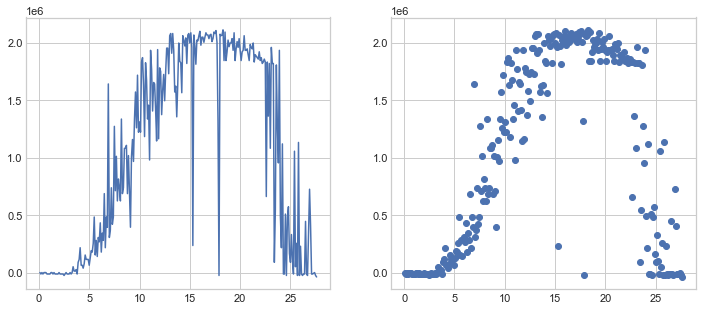

In [56]:
fig = plt.figure(figsize=(12,5))
axplot = fig.add_subplot(121)
axscat = fig.add_subplot(122)
axplot.plot(dataVP.vViento.iloc[idx_VVUniq],dataVP.Pw.iloc[idx_VVUniq])
axscat.scatter(dataVP.vViento.iloc[idx_VVUniq],dataVP.Pw.iloc[idx_VVUniq])

In [57]:
print('Numero de pares magnitud,potencia unicos %d'%(dataVP.iloc[idx_VVUniq].shape[0]))

Numero de pares magnitud,potencia unicos 274


In [58]:
#valores mayor a curva de potencia
nmayor= 0
nmenor =0
nigual=0
nigualred=0
#son menos valores, pues las velocidades de viento del fabricante van en intervalos de 0.5
for v in np.unique(dataVP.vViento[dataVP.vViento.isin(dfCPot.index)].values):
    nmayor =nmayor+(dataVP[dataVP.vViento==v].Pw.values > dfCPot.loc[v].values).sum()    
    nmenor =nmenor+(dataVP[dataVP.vViento==v].Pw.values < dfCPot.loc[v].values).sum()    
    nigual =nigual+(dataVP[dataVP.vViento==v].Pw.values == dfCPot.loc[v].values).sum()    
    #REDONDEO
    for r in [10,10000,100000,1000000]:
        nigualred =nigualred +((dataVP[dataVP.vViento==v].Pw.values/r).round()*r == dfCPot.loc[v].values).sum()  
print('Número de valores arriba de la curva del fabricante: %d'%(nmayor) )
print('Número de valores abajo de la curva del fabricante: %d'%(nmenor) )
print('Número de valores iguales a la curva del fabricante: %d'%(nigual) )
print('Número de valores iguales a la curva del fabricante (redondeados): %d'%(nigualred) )

Número de valores arriba de la curva del fabricante: 1549
Número de valores abajo de la curva del fabricante: 4774
Número de valores iguales a la curva del fabricante: 0
Número de valores iguales a la curva del fabricante (redondeados): 3012


In [59]:
#redondear los datos de direccion y velocidad 
dataDVP_redond =dataDVP.round({'Dir': 0, 'vViento': 0})
#pares vviento Dir unicos
unique_rows = np.unique(dataDVP_redond[['vViento','Dir']], axis=0)
n =len(unique_rows)
print('Pares unicos direccion de viento y velocidad redondeados: %d '%(n))

Pares unicos direccion de viento y velocidad redondeados: 3615 


In [60]:
#combinaciones posibles de valores de vviento y direccion unicos
len(np.unique(dataDVP_redond.Dir.values))*len(np.unique(dataDVP_redond.vViento.values))

10440

# (9) Filtrado,Clusters, regresion

## Resumen

- Eliminar datos con potencia cero (la maquina esta apagada y no es consecuencia de un estado de viento). O sí es consecuencia (video desplomenodir2).
- Eliminar puntos que aparententemente superen el limite de Betz(Rafaga oculta tras el promedio?)
- Eliminar valores negativos menores a -30kw


## Grupos sin filtrar

In [61]:
#solo clusters sin subclusters
ncl = 5   # numero de clusters
nsubcl =0  #numero de subclusters
#subclusters
clsclord=('viento','potencia') #orden de clusterizado
# crear los dataframes agrupados en clusters
dfclvv, dfclpw, dfclvp, cl_ord,cl_cent,idx_centroids,scl_ord,scl_cent,idx_centroids_sc = cluster2DataFrame(
    dfVecVel, dataVP, n_clusters=ncl,n_subclu =nsubcl,clusters=clsclord[0],subclusters=clsclord[1])


13.3-1883070.636561722
1.5--12723.450247038661
3.5-101787.60197630929
19.6-1933964.4375498765
7.5-839747.7163045517
Saved in fig_art/VVVPCl5SCl0_13-12-2021_02_36_31_155473.png


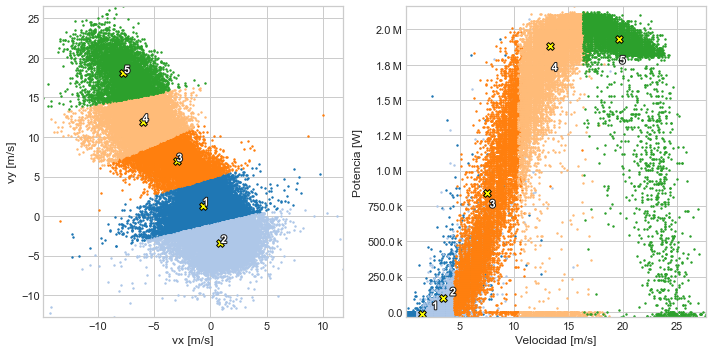

In [62]:
ploti = plotSubClusterInt()
ploti.createPlot(dfclvv, dfclvp, dataVP, figsize=(
    10, 5), cl_scl_order=clsclord, idx_centroids=idx_centroids,idx_centroids_sc=idx_centroids_sc,fign=201,
                savepath='fig_art/', showlBetz=False, showCFab= False, showCent= True, showOpt= 'Numero')

In [63]:
for i in range(len(cl_cent)):
    print(str(i+1) + ' - '+ str( np.sqrt( cl_cent[i][0]**2 + cl_cent[i][1]**2)) )

1 - 3.5411162026535803
2 - 13.327253931710448
3 - 1.4662656490182335
4 - 19.620577837366067
5 - 7.518181674216893


In [64]:
for i in range(len(cl_cent)):
    print(cl_cent[i][1]**2)

11.676729945699943
141.33279240613567
1.706404991792225
326.0670003515666
47.55673275053273


In [65]:
cl_cent

array([[ 0.92885629, -3.41712305],
       [-6.02352928, 11.88834692],
       [-0.66598045,  1.30629437],
       [-7.67463838, 18.05732539],
       [-2.9943819 ,  6.89613897]])

In [66]:
ncl = 25   # numero de clusters
nsubcl =0  #numero de subclusters
#subclusters
clsclord=('viento','potencia') #orden de clusterizado
# crear los dataframes agrupados en clusters
dfclvv, dfclpw, dfclvp, cl_ord,cl_cent,idx_centroids,scl_ord,scl_cent,idx_centroids_sc = cluster2DataFrame(
    dfVecVel, dataVP, n_clusters=ncl,n_subclu =nsubcl,clusters=clsclord[0],subclusters=clsclord[1])

2.6--12723.450247038661
5.3-279915.90543485055
2.7-25446.900494077323
6.1-203575.20395261858
5.4-178128.30345854128
5.7-458044.2088933918
10.7-1526814.0296446392
18.6-1946687.8877969154
2.5-0.0
17.7-1984858.2385380312
2.9--12723.450247038661
0.5--12723.450247038661
10.0-827024.266057513
23.8-1781283.0345854126
13.2-2048475.4897732246
2.8-0.0
14.7-2073922.3902673018
12.4-1564984.3803857553
1.9-0.0
16.0-2086645.8405143404
21.0-1984858.2385380312
14.8-1870347.1863146834
4.0-63617.25123519331
5.4-50893.800988154646
8.2-814300.8158104743
Saved in VVVPCl25SCl0_13-12-2021_02_36_55_873973.png


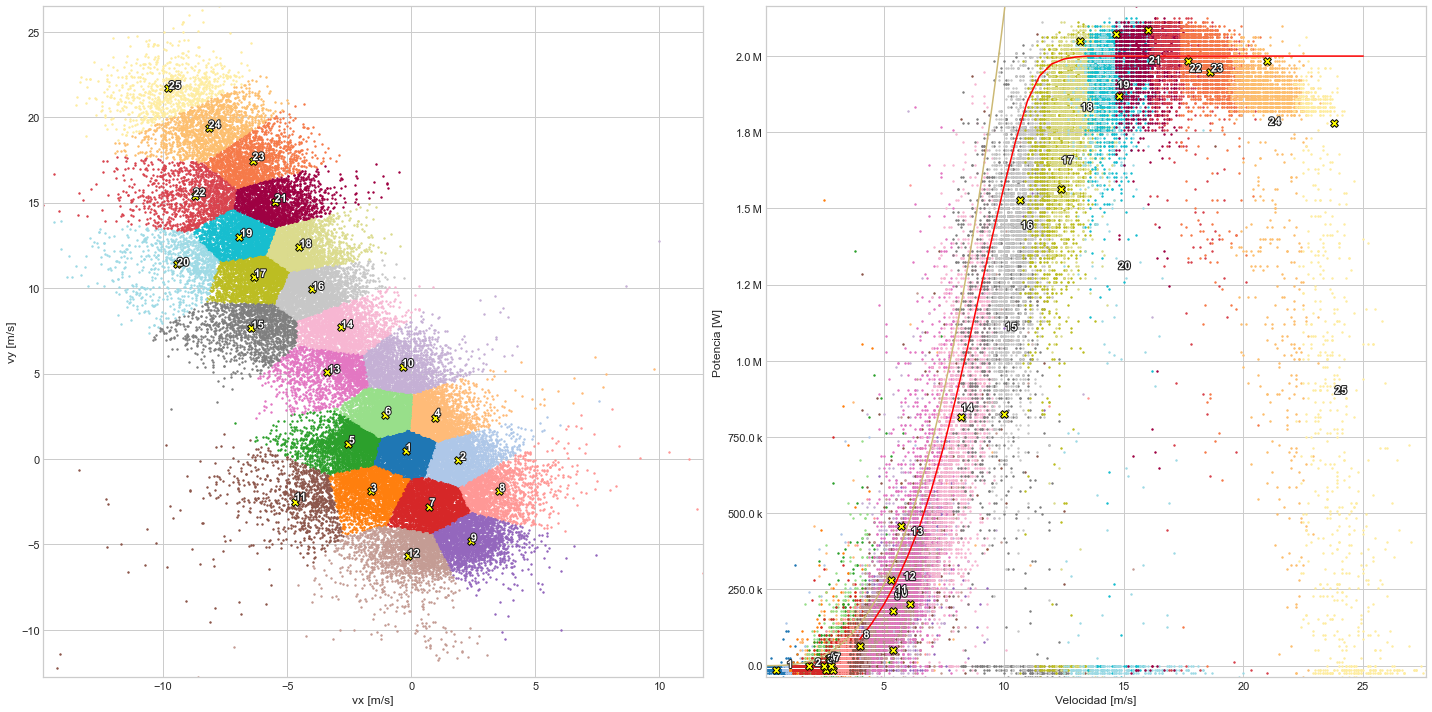

In [67]:
ploti = plotSubClusterInt()
ploti.createPlot(dfclvv, dfclvp, dataVP, figsize=(
    20, 10), cl_scl_order=clsclord, idx_centroids=idx_centroids,idx_centroids_sc=idx_centroids_sc,fign=93)

## Análisis grupo 11 Caída de potencia

### Ejemplo 1

In [68]:

# #video desplomedir_13
# #Creando un dataframe con el grupo 11
# dfg11 = dfclvp.C4.SC2.dropna()
# dfg11_DVP= dataDVP.loc[dfg11.index]
# dfg11_DVP= dataDVP.loc[pd.to_datetime('2016-10-30 02:00'):pd.to_datetime('2016-10-30 8:30')]
# formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009

# fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True,figsize =(9,7))

# ax1.plot(dfg11_DVP.index,dfg11_DVP.vViento, linestyle='-', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax1.set_title('Velocidad de viento',fontsize=13)
# ax1.set_ylabel('Vel. [m/s]',fontsize=13)
# ax1.grid(b=True,which='both',axis='both')
# ax1.set_yticks(np.arange(0,20, 3))
# ax1.xaxis.set_minor_locator( mdates.MinuteLocator(interval = 10))
# ax1.xaxis.set_minor_formatter( mdates.DateFormatter('%H:%M'))
# ax1.tick_params(axis='y',   labelsize=12)

# ax2.plot(dfg11_DVP.index,dfg11_DVP.Dir, linestyle='-', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax2.set_title('Dirección de viento',fontsize=13)
# ax2.set_ylabel('Dir. [°]',fontsize=13)
# ax2.set_yticks(np.arange(0,61, 10))
# ax2.grid(b=True,which='both',axis='both')
# ax2.tick_params(axis='y',   labelsize=12)

# ax3.plot(dfg11_DVP.index,dfg11_DVP.Pw, linestyle='-', marker='o', color='b',linewidth=0.5,
#         markersize=2)

# ax3.set_title('Potencia',fontsize=13)
# ax3.yaxis.set_major_formatter(formatter1)
# ax3.set_xlabel('Estampa de tiempo',fontsize=13)
# ax3.set_ylabel('Pot. [W]',fontsize=13)
# ax3.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='minor',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)# labels along the bottom edge are off
# ax3.tick_params(axis='y',   labelsize=12)

# #buscando minimos para pintar líneas (VER BIEN LOS RANGOS DEL RANGE)
# vel =0
# direc = 0
# n=0
# for i in range(1,len(dfg11_DVP)) : #REVISARE ESTOS RANGOS PARA SABER SI SON FECHAS COMPLETAS
#     if  dfg11_DVP.iloc[[i]].Pw.values[0] <1e6: 
#         if dfg11_DVP.iloc[[i]].Pw.values[0] < dfg11_DVP.iloc[[i-1]].Pw.values[0]:
#             ax1.axvline(x= dfg11_DVP.iloc[[i]].index,linewidth = 1,linestyle='--',c='r')
#             ax2.axvline(x= dfg11_DVP.iloc[[i]].index,linewidth = 1,linestyle='--',c='r')
#             ax3.axvline(x= dfg11_DVP.iloc[[i]].index,linewidth = 1,linestyle='--',c='r')
#             print('mag:%0.1f,ang:%0.1f-%s'%(float(dfg11_DVP.iloc[[i]].vViento),
#                                       float(dfg11_DVP.iloc[[i]].Dir),str(dfg11_DVP.iloc[[i]].index.format())))
#             vel+=float(dfg11_DVP.iloc[[i]].vViento)
#             direc+=float(dfg11_DVP.iloc[[i]].Dir)
#             n+=1
# print('vel. prom: %0.1f,dir. prom:%0.1f'%(vel/n,direc/n))
#         #cuandos se recupera lap otencia despues de una caida"
# #     if (dfg11_DVP.loc[fechas[i]].Pw > dfg11_DVP.loc[fechas[i-1]].Pw) and (dfg11_DVP.loc[fechas[i]].Pw > dfg11_DVP.loc[fechas[i+1]].Pw):
# #             ax1.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='g')
# #             ax2.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='g')
# #             ax3.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='g')
# plt.tight_layout()
# ax3.grid(b=True,which='both',axis='both')
# ax3.xaxis.set_major_locator(mdates.MinuteLocator(0))
# ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# # ax3.xaxis.set_minor_locator( mdates.MinuteLocator(interval = 10))
# # ax3.xaxis.set_minor_formatter( mdates.DateFormatter('%H:%M'))

# plt.setp(ax3.get_xmajorticklabels(), visible=True, rotation=0)
# plt.ylim([-1e5,2e6])
# plt.yticks(np.arange(0, 2.1e6, 5e5))

# if flagsaveim:
#     plt.savefig('reporte/figuras/subpltg11.png')



### Ejemplo 2

In [69]:
# #Creando un dataframe con el grupo 11
# dfg11 = dfclvp.C4.SC2.dropna()
# dfg11_DVP= dataDVP.loc[dfg11.index]
# dfg11_DVP= dataDVP.loc[pd.to_datetime('2016-10-25 14:50'):pd.to_datetime('2016-10-26 10:10')]
# formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009

# plt.figure()

# plt.subplot(3, 1, 1)
# plt.plot(dfg11_DVP.index,dfg11_DVP.vViento, linestyle='--', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax1=plt.gca()
# ax1.xaxis.set_major_locator(mdates.DayLocator(30))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0 )
# ax1.set_title('Vel. de viento [m/s]')

# hours = mdates.HourLocator(interval = 5)  #
# h_fmt = mdates.DateFormatter('%H:%M')
# ax1.xaxis.set_minor_locator(hours)
# ax1.xaxis.set_minor_formatter(h_fmt)

# plt.subplot(3, 1, 2)
# plt.plot(dfg11_DVP.index,dfg11_DVP.Dir, linestyle='--', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax2=plt.gca()
# ax2.xaxis.set_major_locator(mdates.DayLocator(30))
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# plt.setp( ax2.xaxis.get_majorticklabels(), rotation=0 )
# ax2.set_title('Dirección de viento')

# hours = mdates.HourLocator(interval = 5)  #
# h_fmt = mdates.DateFormatter('%H:%M')
# ax2.xaxis.set_minor_locator(hours)
# ax2.xaxis.set_minor_formatter(h_fmt)

# plt.subplot(3, 1, 3)
# plt.plot(dfg11_DVP.index,dfg11_DVP.Pw, linestyle='--', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax3=plt.gca()
# ax3.xaxis.set_major_locator(mdates.DayLocator(30))
# ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# plt.setp( ax3.xaxis.get_majorticklabels(), rotation=0 )

# hours = mdates.HourLocator(interval = 5)  #
# h_fmt = mdates.DateFormatter('%H:%M')
# ax3.xaxis.set_minor_locator(hours)
# ax3.xaxis.set_minor_formatter(h_fmt)
# ax3.set_title('Potencia [W]')
# ax3.yaxis.set_major_formatter(formatter1)

# plt.tight_layout()
# #buscando minimos para pintar líneas
# fechas = (dfg11_DVP[dfg11_DVP.Pw<=0.5e6].index)
# for i in range(1,len(fechas)) :
#     if dfg11_DVP.loc[fechas[i]].Pw < dfg11_DVP.loc[fechas[i-1]].Pw:
#         ax1.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='r')
#         ax2.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='r')
#         ax3.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='r')
# plt.tight_layout()


###  Ejemplo 3

In [70]:
# #video desplomedir_13
# #Creando un dataframe con el grupo 11
# dfg11 = dfclvp.C4.SC2.dropna()
# dfg11_DVP= dataDVP.loc[dfg11.index]
# dfg11_DVP= dataDVP.loc[pd.to_datetime('2016-11-13 04:00'):pd.to_datetime('2016-11-13 16:10')]
# formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009

# plt.figure()

# plt.subplot(3, 1, 1)
# plt.plot(dfg11_DVP.index,dfg11_DVP.vViento, linestyle='--', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax1=plt.gca()
# ax1.xaxis.set_major_locator(mdates.DayLocator(30))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# plt.setp( ax1.xaxis.get_majorticklabels(), rotation=0 )
# ax1.set_title('Vel. de viento')
# ax1.set_ylabel('Vel. [m/s]')

# hours = mdates.HourLocator(interval = 5)  #
# h_fmt = mdates.DateFormatter('%H:%M')
# ax1.xaxis.set_minor_locator(hours)
# ax1.xaxis.set_minor_formatter(h_fmt)

# plt.subplot(3, 1, 2)
# plt.plot(dfg11_DVP.index,dfg11_DVP.Dir, linestyle='--', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax2=plt.gca()
# ax2.xaxis.set_major_locator(mdates.DayLocator(30))
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# plt.setp( ax2.xaxis.get_majorticklabels(), rotation=0 )
# ax2.set_title('Dirección de viento')
# ax2.set_ylabel('Dir. [°]')

# hours = mdates.HourLocator(interval = 5)  #
# h_fmt = mdates.DateFormatter('%H:%M')
# ax2.xaxis.set_minor_locator(hours)
# ax2.xaxis.set_minor_formatter(h_fmt)


# plt.subplot(3, 1, 3)
# plt.plot(dfg11_DVP.index,dfg11_DVP.Pw, linestyle='--', marker='o', color='b',linewidth=0.5,
#         markersize=2)
# ax3=plt.gca()
# ax3.xaxis.set_major_locator(mdates.DayLocator(30))
# ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%b'))
# plt.setp( ax3.xaxis.get_majorticklabels(), rotation=0 )

# hours = mdates.HourLocator(interval = 5)  #
# h_fmt = mdates.DateFormatter('%H:%M')
# ax3.xaxis.set_minor_locator(hours)
# ax3.xaxis.set_minor_formatter(h_fmt)
# ax3.set_title('Potencia')
# ax3.yaxis.set_major_formatter(formatter1)
# ax3.set_xlabel('Estampa de tiempo')
# ax3.set_ylabel('Pot. [W]')

# #buscando minimos para pintar líneas (VER BIEN LOS RANGOS DEL RANGE)
# fechas = (dfg11_DVP[dfg11_DVP.Pw<=0.5e6].index)
# for i in range(1,len(fechas)-1) : #REVISARE ESTOS RANGOS PARA SABER SI SON FECHAS COMPLETAS
#     if dfg11_DVP.loc[fechas[i]].Pw < dfg11_DVP.loc[fechas[i-1]].Pw:
#         ax1.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='r')
#         ax2.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='r')
#         ax3.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='r')
#         #cuandos se recupera lap otencia despues de una caida"
#     if (dfg11_DVP.loc[fechas[i]].Pw > dfg11_DVP.loc[fechas[i-1]].Pw) and (dfg11_DVP.loc[fechas[i]].Pw > dfg11_DVP.loc[fechas[i+1]].Pw):
#             ax1.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='g')
#             ax2.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='g')
#             ax3.axvline(x=fechas[i],linewidth = 0.5,linestyle='--',c='g')
# plt.tight_layout()



### Ejemplo 4

###  Ejemplo 5


### pie grupo 11

### ¿Qué significan los diferentes valores de potencia negativos?

https://www.quora.com/How-much-power-does-a-wind-turbine-need-to-consume-to-start-working-and-to-operate
So there are some myths here about wind turbines. Small scale turbines may be self starting but big ones are not and will vampire off the grid until the winds are high enough to spin fast enough. (Roughly about 4 to 6 mph winds) they drain about 6kwh (6 kilo watts hours so 6 kilo watts per hour) while waiting this is used to run the controller, electronics and keep everything warmed up. Turbines seek the wind and as the wind picks up they will yaw to face the wind and jump up to about 9kwh tell it’s in the wind, usually takes less than a min. After the winds are high enough this where the major drain comes. It’s drain jumps up to about 24kwh, this is to charge the converters, capacitiers, pitch the blades to the correct angle to catch as much wind as needed to spin at the right rpm for the generator. After about a min it’ll do verification tests to make sure it’s good. That the energy being produced is at the right hertz and such. It’ll then push the power to the grid. So after a min it’ll go from -20kwh up to making 1000kwh and at peak capacity 2000kwh.

So basically a down turbine will consume about 150kwh on stand by in a day and to make up for it only needs to run for much less than an hour.

Se supone que:
- cuando la potencia es cero, la turbina está completamente apagada o hay un problema del sensor, pero se pensaría que las filas en blanco son problemas del sensor.
- Una potencia espara mantener activos los sistemas.
- Una potencia es para arrancar.

## Filtrado

In [80]:
#calculo de la potencia maxima  a partir del limite de betz
A=np.pi*45**2
Cp = 0.59 #limite de Betz
rho = 1.1349
vvento = np.unique(dataVP.vViento.values)
PMaxViento = 1/2*rho*A*vvento**3*Cp


In [81]:
#eliminando valores que superen el limite de betz
dataVP_filt = dataVP.copy()#copia de dataVP hecha para eliminar valores que superen el limited betz
dfVecVel_filt = dfVecVel.copy()
for i in range(len(vvento)):
    idxd =dataVP[(dataVP.vViento==vvento[i])&(dataVP.Pw>PMaxViento[i])].index
    dataVP_filt.drop(idxd,inplace=True)
    dfVecVel_filt.drop(idxd,inplace=True)

In [82]:
# #eliminando valores de potencia negativos menores a 30kW
mask = dataVP[dataVP.Pw<-30E3].index
dataVP_filt.drop(mask,inplace=True)
dfVecVel_filt.drop(mask,inplace=True)


In [83]:
# # #eliminando potencias igual a cero
# mask = dataVP[dataVP.Pw==0].index
# dataVP_filt.drop(mask,inplace=True)
# dfVecVel_filt.drop(mask,inplace=True)

In [84]:
# NO VALE LA PENA FILTRAR ASI, SON POCOS PUNTOS Y NO MEJORAN LA POSICION DE LOS CENTROIDES
# secuencia de potencias cero 
# start_remove = pd.to_datetime('2016-05-23 23:00:00')
# end_remove=pd.to_datetime('2016-05-24 11:50:00')
# dataVP_filt=dataVP.loc[(dataVP.index < start_remove) | (dataVP.index > end_remove)]
# dfVecVel_filt=dfVecVel.loc[(dfVecVel.index < start_remove) | (dfVecVel.index > end_remove)]
# start_remove = pd.to_datetime('2016-09-02 8:00:00')
# end_remove=pd.to_datetime('2016-09-03 11:00:00')
# dataVP_filt=dataVP.loc[(dataVP.index < start_remove) | (dataVP.index > end_remove)]
# dfVecVel_filt=dfVecVel.loc[(dfVecVel.index < start_remove) | (dfVecVel.index > end_remove)]
# start_remove = pd.to_datetime('2016-10-13 12:10:00')
# end_remove=pd.to_datetime('2016-10-13 15:20:00')
# dataVP_filt=dataVP.loc[(dataVP.index < start_remove) | (dataVP.index > end_remove)]
# dfVecVel_filt=dfVecVel.loc[(dfVecVel.index < start_remove) | (dfVecVel.index > end_remove)]


## Clusters

In [85]:
#subclusters
clsclord=('viento','potencia') #orden de clusterizado
# crear los dataframes agrupados en clusters
dfclvv, dfclpw, dfclvp, cl_ord,cl_cent,idx_centroids,scl_ord,scl_cent,idx_centroids_sc = cluster2DataFrame(
    dfVecVel_filt, dataVP_filt, n_clusters=5,n_subclu = 3 ,clusters=clsclord[0],subclusters=clsclord[1])


13.7-1997581.6887850699
1.6--12723.450247038661
3.5-0.0
19.8-1883070.636561722
8.4-547108.3606226625
Saved in VVVPCl5SCl3_13-12-2021_02_38_55_284738.png


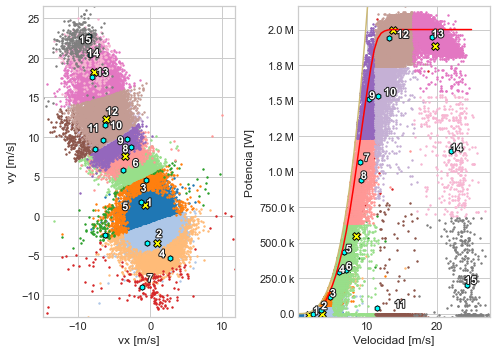

In [86]:
ploti_filt = plotSubClusterInt()
ploti_filt.createPlot(dfclvv, dfclvp, dataVP, figsize=(
    7, 5), cl_scl_order=clsclord, idx_centroids=idx_centroids,idx_centroids_sc=idx_centroids_sc,fign=92)

## Filtrando por estados (clusters)

Se quitan los estados no productores de potencia excluyendo el estado 0 (velocidades cercanas a 0)

In [87]:
cl_borrar = [('C1', 'SC3'), ('C2', 'SC3'), ('C4', 'SC1'),('C4', 'SC2'),('C5', 'SC2'),('C5', 'SC3')] #5cl y 3 scl
#[3,6,10,11,14,15]
#cl_borrar=[('C1','SC1'),('C1','SC2'),('C1','SC3'),('C2','SC1'),('C2','SC2'),('C2','SC3')]
dfs, idx_centroids_clean,idx_centroids_sc_clean = delClusters(
    [dfclvv, dfclvp], cl_borrar, idx_centroids,idx_centroids_sc, cl_type='cluster')
dvv = dfs[0]
dvp = dfs[1]


Saved in fig_art/VVVPCl5SCl3_13-12-2021_02_39_02_643025.png


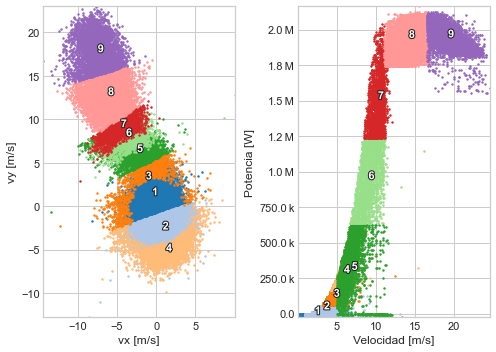

In [88]:
ploti_filt_2 = plotSubClusterInt()
ploti_filt_2.createPlot(dvv, dvp, dataVP, figsize=(
    7, 5), cl_scl_order=clsclord, idx_centroids=idx_centroids_clean,idx_centroids_sc=idx_centroids_sc_clean,fign=85,
                        savepath='fig_art/', showlBetz=False, showCFab= False, showCent= False, showOpt= 'Numero')



## Pasar de dataframe con clusters a dataframe normal

In [89]:
# dfVecVel_NCl: datos filtrados y sin clusters pasados a datos normales
dfVecVel_NCl,dataVP_NCl = clust2data(dvv,dvp)

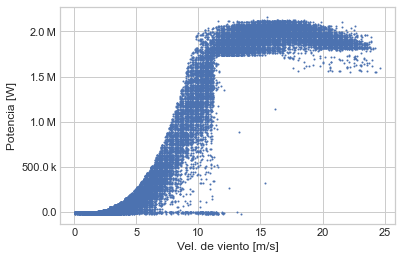

In [90]:
plt.figure(94)
a =plt.scatter(dataVP_NCl.vViento,dataVP_NCl.Pw,s=1)
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
ax1=plt.gca()
ax1.set_ylabel('Potencia [W]')
ax1.set_xlabel('Vel. de viento [m/s]')
ax1.yaxis.set_major_formatter(formatter1)
if flagsaveim:
    plt.savefig('reporte/figuras/curvpotrec.png')


## Desviaciones estandar de los datos filtrados (bins=0.5m/s)

In [91]:
#bins = np.arange(0,28,0.5)
#lp=[]
#for i in range(len(bins)-1):
#    lp.append(dataVP[(dataVP.vViento>=bins[i]) & (dataVP.vViento<=bins[i+1])].Pw.std())
#plt.figure(94)
#plt.bar(bins[:-1],lp,0.5,edgecolor ='k',label='Sin filtrar')
##datos filtrados
#df= dfcltodf.dropna()
#bins = np.arange(0,28,0.5)
#lp=[]
#for i in range(len(bins)-1):
#    lp.append(df[(df.vViento>=bins[i]) & (df.vViento<=bins[i+1])].Pw.std())
#plt.bar(bins[:-1],lp,0.5,edgecolor ='k',label='Filtrado')
#plt.title("Desviaciones estandar")
#plt.xlabel('Viento')
#plt.ylabel('Potencia')
#plt.legend()
#plt.show()
#print('Velocidad maxima en datos filtrados: %0.1f m/s'%df.vViento.max().max())

# Comparacion entre funciones de ajuste

##  Regresion por numpy (poly)
- Tiene potencias negativas para velocidades bajas



In [92]:
np.version.version


'1.20.3'

In [93]:
enerDatos=dataVP.Pw.sum()*1/6#deltat
#lo que hace esta celda es redondear las velocidades de viento a en intervalos de 0.5 para buscarlas en el dataframe 
#de la curva del fabricante para sumar las potencias de las velocidades d
#redondear
vViento_red =np.around(dataVP.vViento.values*2)/2
#quitando valores menores a 4 y mayores a 25
vViento_filt = vViento_red[(vViento_red >= 4) &(vViento_red <= 25)]
pwcpotfab = 0
for i in vViento_filt:
    pwcpotfab = pwcpotfab+ dfCPot.loc[i].pw
enerpotfab = pwcpotfab*1/6


In [94]:

#inicio
#Hacer una lista de centroides de subclusters
vviento = np.arange(0, 28, 0.1)

lcent=[]
for i in range(len(idx_centroids_sc_clean)):
    lcent.append([idx_centroids_sc_clean.iloc[i].vViento,idx_centroids_sc_clean.iloc[i].Pw])
lcent= np.array(lcent)
#ordenando centroides
lcent= lcent[lcent[:,0].argsort()]

In [95]:
xp = vviento.copy()
x =  lcent[:,0]
y = lcent[:,1]
z = np.polyfit(x, y, 3)
polyf = np.poly1d(z)
x_data=lcent[:,0]
y_data=lcent[:,1]
z
y_pred_poly= polyf(x) #predictec
y_pred_poly_vv =  polyf(xp)

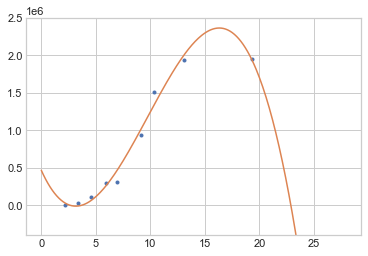

In [96]:
plt.figure(95)
xp = vviento
_ = plt.plot(x, y, '.', xp, polyf(xp), '-')
plt.ylim(-4E5,2.5E6)

plt.show()

In [97]:
residuals_poly = y- y_pred_poly
ss_res = np.sum(residuals_poly**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_poly = 1 - (ss_res / ss_tot)
meanAbsErr_poly = sk.metrics.mean_absolute_error(y,polyf(x))
rmse_poly = np.sqrt(((y - y_pred_poly) ** 2).mean())
for i in range(len(residuals_poly)):
    print('Residual %i: %0.4f'%(i+1,residuals_poly[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_poly)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_poly)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_poly)

Residual 1: -28886.9181
Residual 2: 34297.7859
Residual 3: 46733.8978
Residual 4: 37899.5413
Residual 5: -149948.8893
Residual 6: -62600.6204
Residual 7: 185742.5708
Residual 8: -67742.1339
Residual 9: 4504.7658
_____________________________________
Residual sum of squares: 7.11E+10
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 0.98672
MAE- Mean Absolute Error: 68706.35
RMSE- Root Mean Square Error: 88909.64


In [98]:
residuals_poly

array([ -28886.91806735,   34297.78589013,   46733.89780197,
         37899.54130041, -149948.88927354,  -62600.62036701,
        185742.57079537,  -67742.13390947,    4504.76582951])

In [99]:
#Calculo de la potencia 
deltaT = 1/6 #10 minutos es un sexto de hora

potPoly = np.sum(polyf(dataVP.vViento))
enerPoly =potPoly*deltaT
difPctPoly = ((enerPoly-enerDatos)*100)/enerDatos
difPctPoly_fab =  ((enerPoly-enerpotfab)*100)/enerpotfab


## Expresion algebraica  
$$f(v) = A(1-e^{-b(v)^{n}})$$
$$f(v) = A((1+y_s)-e^{-b(v-x_s)^{n}})$$



### Ajuste (Cambié  los parametros de optimización que me da un mejor ajuste)

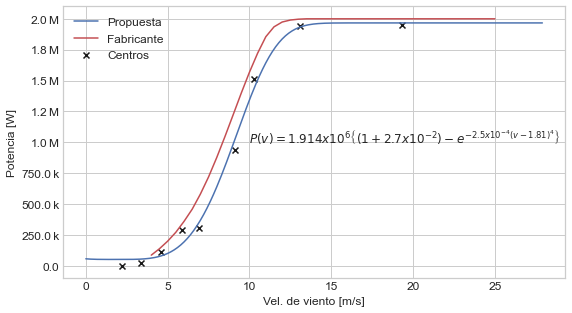

[2.49690861e-04 1.81165522e+00 2.72969362e-02 1.91443782e+06]


In [100]:
#Hacer una lista de centroides de subclusters
lcent=[]
for i in range(len(idx_centroids_sc_clean)):
    lcent.append([idx_centroids_sc_clean.iloc[i].vViento,idx_centroids_sc_clean.iloc[i].Pw])
lcent= np.array(lcent)
#ordenando centroides
lcent= lcent[lcent[:,0].argsort()]

#calculo de parametros
x_data = lcent[:,0]
y_data =lcent[:,1]

def test_func(vviento, b, xs,ys,A):
    n=4
    return A*((1.0+ys)-np.exp(-b * (vviento-xs)**n))

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[0.0001, 0.001,0,1.8e6],
                                               bounds=((-np.inf,-np.inf,-np.inf,1.7e6),(np.inf,np.inf,np.inf,2.0e6))                                              )


n=4
b= params[0]
xs= params[1]
ys= params[2]
A = params[3]

formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009

p =plt.figure(300,figsize=(9,5))
vviento = np.arange(0, 28, 0.1)
y_pred_alg_vv=A*((1.0+ys)-np.exp(-b * (vviento-xs)**n))# xshift yshift

plt.plot(vviento, y_pred_alg_vv,linestyle='-',label='Propuesta')
ax1 = plt.gca()
ax1.yaxis.set_major_formatter(formatter1)
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x',label='Centros')
plt.plot(dfCPot.index,dfCPot.pw,c='r',linestyle='-',label='Fabricante')
plt.ylabel('Potencia [W]',fontsize=12)
plt.xlabel('Vel. de viento [m/s]',fontsize=12)
plt.ylim(-1E5, 2.1E6)
#texto parametros

# plt.text(20,100E4,'b = %.4f'%b,size='large')
# plt.text(20,80E4,'n = %.4f'%n,size='large')
# plt.text(20,60E4,'xs = %.4f'%xs,size='large')
# plt.text(20,40E4,'ys = %.4f'%ys ,size='large')
# plt.text(20,20E4,'A = {:,}'.format( A),size='large')

#texto latex
# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if not exponent:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if not precision:
        precision = decimal_digits

    return r"${0:.{2}f}x10^{{{1:d}}}$".format(coeff, exponent, precision)
Asci = sci_notation(A,decimal_digits=3)[1:-1] #quito $ y me quedo solo con el string
yssci = sci_notation(ys)[1:-1]
bssci = sci_notation(b)[1:-1]

plt.text(10, 1e6, r'$P(v) = %s \left \{(1+%s)-e^{-%s( v-%s)^{%s}} \right \}$'
         %(Asci,yssci,bssci,'%.2f'%(xs),str(n)) ,fontsize=12)

#limix = range(31)
#plt.xticks(limix)
plt.tick_params(labelsize=12)
plt.legend()
plt.legend(fontsize=12)


plt.show()
y_pred_alg =test_func(x_data, params[0],params[1],params[2],params[3])
# if flagsaveim:
#     plt.savefig('reporte/figuras/curvaAjustada.png')
# plt.savefig('reporte/figuras/curvaAjustada.png')
print(params)


In [101]:
residuals_alg = y_data- y_pred_alg
ss_res = np.sum(residuals_alg**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_alg = 1 - (ss_res / ss_tot)
meanAbsErr_alg= sk.metrics.mean_absolute_error(y_data,y_pred_alg)
rmse_alg = np.sqrt(((y_data - y_pred_alg) ** 2).mean())
for i in range(len(residuals_alg)):
    print('Residual %i: %0.4f'%(i+1,residuals_alg[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_alg)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_alg)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_alg)

Residual 1: -52269.1590
Residual 2: -29851.4172
Residual 3: 33574.2658
Residual 4: 111385.6443
Residual 5: -41955.4918
Residual 6: -78804.7981
Residual 7: 71090.6075
Residual 8: 6838.5719
Residual 9: -20008.2145
_____________________________________
Residual sum of squares: 3.06E+10
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 0.99428
MAE- Mean Absolute Error: 49530.91
RMSE- Root Mean Square Error: 58336.76


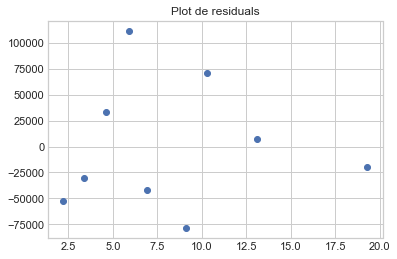

In [102]:
#plot der esiduals
plt.figure(99)
plt.scatter(x_data,residuals_alg)
plt.title('Plot de residuals')
plt.show()

### Calculo de potencia

In [103]:
#grupos filtrados
deltaT = 1/6 #10 minutos es un sexto de hora
dfg11 = dfclvp.C4.SC2.dropna()
dfg14 = dfclvp.C5.SC2.dropna()
dfg15 = dfclvp.C5.SC3.dropna()
dfg3 = dfclvp.C1.SC3.dropna()
dfg6 = dfclvp.C2.SC3.dropna()
dfg10 = dfclvp.C4.SC1.dropna()
potgruposfilt  =dfg11.Pw.sum()+dfg14.Pw.sum()+dfg15.Pw.sum() +dfg3.Pw.sum() +dfg6.Pw.sum() +dfg10.Pw.sum() 
potgruposNoprodpot= dfg11.Pw.sum()+dfg14.Pw.sum()+dfg15.Pw.sum()
potTotExpAlg=0
for vv in dataVP.vViento.values:
    potTotExpAlg+= A*((1.0+ys)-np.exp(-b * (vv-xs)**n))
potExpAlg =potTotExpAlg.copy()
enerExpAlg=potTotExpAlg*deltaT
enerDatos=dataVP.Pw.sum()*deltaT
difPctExpAlg = ((enerExpAlg-enerDatos)*100)/enerDatos

difPctExpAlg_fab = ((enerExpAlg-enerpotfab)*100)/enerpotfab


print('Potencia total con la expresión algebraica: %0.4f MW'%(potTotExpAlg/1e6))
print('Potencia total sumando los datos reales: %0.4f MW'%(dataVP.Pw.sum()/1e6))
print('Energía total con la expresión algebraica: %0.4f MWh'%(potTotExpAlg*deltaT/1e6))
print('Energía total sumando los datos reales: %0.4f MWh'%(dataVP.Pw.sum()*deltaT/1e6))
print('Diferencia en porcentaje [pot]: %0.2f%%' % (((potTotExpAlg-dataVP.Pw.sum())*100)/dataVP.Pw.sum()))
print('Diferencia en porcentaje [Ene]: %0.2f%%' % (difPctExpAlg))
print('Porcentaje de potencia del grupo 3,6,10,11,14 y 15: %0.2f%%'%((potgruposfilt*100)/dataVP.Pw.sum()) )
print('Porcentaje de potencia del grupo 11,14 y 15: %0.2f%%'%((potgruposNoprodpot*100)/dataVP.Pw.sum()) )
print('Potencia del grupo 11,14 y 15: %0.2f MW'%(potgruposNoprodpot/1e6))
print('Potencia del grupo 3,6,10,11,14 y 15: %0.2f MW'%(potgruposfilt/1e6))
print('Energía del grupo 11,14 y 15: %0.2f MWh'%(potgruposNoprodpot*deltaT/1e6))
print('Energía del grupo 3,6,10,11,14 y 15: %0.2f MWh'%(potgruposfilt*deltaT/1e6))
print('Diferencia entre la potencia producida menos la potencia calculada: %0.4f MW'%((dataVP.Pw.sum()- potTotExpAlg)/1e6))
print('Diferencia entre la energía producida menos la energía calculada: %0.4f MWh'%((dataVP.Pw.sum()- potTotExpAlg)*deltaT/1e6))

Potencia total con la expresión algebraica: 39045.2034 MW
Potencia total sumando los datos reales: 35670.9625 MW
Energía total con la expresión algebraica: 6507.5339 MWh
Energía total sumando los datos reales: 5945.1604 MWh
Diferencia en porcentaje [pot]: 9.46%
Diferencia en porcentaje [Ene]: 9.46%
Porcentaje de potencia del grupo 3,6,10,11,14 y 15: 12.08%
Porcentaje de potencia del grupo 11,14 y 15: 1.63%
Potencia del grupo 11,14 y 15: 579.87 MW
Potencia del grupo 3,6,10,11,14 y 15: 4307.92 MW
Energía del grupo 11,14 y 15: 96.65 MWh
Energía del grupo 3,6,10,11,14 y 15: 717.99 MWh
Diferencia entre la potencia producida menos la potencia calculada: -3374.2409 MW
Diferencia entre la energía producida menos la energía calculada: -562.3735 MWh


##  5 parameters logistic 5PL

$$
P = D+\frac{A-D}{\left(1+(v/C)^B\right)^G}
$$
A = minimum asymptote<br>
B = Hill slope<br>
C = inflection point (point of curve where the curvature changes direction)<br>
D = maximum asymptote<br>
G = asymmetry factor(parameters obtained by evolutionary techniques)<br>

[4.51518364e+00 6.39937825e+01 4.84669419e+03]
Coefficient of determination R^2: 0.99323


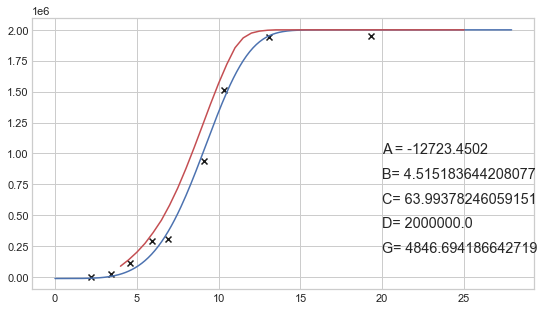

In [104]:
from scipy import optimize
x_data = lcent[:,0]
y_data =lcent[:,1]

def logistic5(x, B, C, G):
    """5PL lgoistic equation."""
    yoff =-1.27234502e+04 #potencia cuando elv iento es cero
    A = yoff #A  is the minimum asymptote
    D = 2E6 #D  is the maximum asymptote.
    return ((A-D)/(1.0+((x/C)**B))**G) + D 

#B= 5.000000 , C=11.722000, G=2.900000 calculado con gridsearch
# params, params_covariance = optimize.curve_fit(logistic5, x_data, y_data,
#                                                p0=[5,11,2],bounds=((5,11,2),(6,12,5)))
params, params_covariance = optimize.curve_fit(logistic5, x_data, y_data,                                               p0=[5,11,2],
                                                bounds=((-np.inf,-np.inf,-np.inf),(np.inf,np.inf,np.inf))                                              )



print(params)
yoff =-1.27234502e+04 #potencia cuando elv iento es cero
A_5PL = yoff #A  is the minimum asymptote
D_5PL = 2E6 #D  is the maximum asymptote.

B_5PL= params[0]
C_5PL= params[1]
G_5PL= params[2]
residuals = y_data- logistic5(x_data, params[0],params[1],params[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_logi5 = 1 - (ss_res / ss_tot)
print('Coefficient of determination R^2: %0.5f'%r_squared_logi5)
p =plt.figure(109,figsize=(9,5))
vviento = np.arange(0, 28, 0.1)
y_pred_logi5_vv= logistic5(vviento, B_5PL, C_5PL,G_5PL)
y_pred_logi5= logistic5(x_data, B_5PL, C_5PL,G_5PL)
plt.plot(vviento, y_pred_logi5_vv)
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.plot(dfCPot.index,dfCPot.pw,c='r')

plt.ylim(-1E5, 2.1E6)
plt.text(20,100E4,'A = ' + str(A_5PL),size='x-large')
plt.text(20,80E4,'B= ' + str(B_5PL),size='x-large')
plt.text(20,60E4,'C= ' + str(C_5PL),size='x-large')
plt.text(20,40E4,'D= ' + str(D_5PL),size='x-large')
plt.text(20,20E4,'G= ' + str(G_5PL),size='x-large')
plt.show()



In [105]:
residuals_logi5 = y_data-y_pred_logi5
ss_res = np.sum(residuals_logi5**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_logi5 = 1 - (ss_res / ss_tot)
meanAbsErr_logi5 = sk.metrics.mean_absolute_error(y_data,y_pred_logi5 )
rmse_logi5 = np.sqrt(((y_data - y_pred_logi5) ** 2).mean())
for i in range(len(residuals_logi5)):
    print('Residual %i: %0.4f'%(i+1,residuals_logi5[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_logi5)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_logi5)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_logi5)

Residual 1: 10324.4613
Residual 2: 21107.0501
Residual 3: 61250.3360
Residual 4: 109188.7391
Residual 5: -59800.4987
Residual 6: -84107.8977
Residual 7: 79843.8171
Residual 8: -12700.7579
Residual 9: -53312.1113
_____________________________________
Residual sum of squares: 3.63E+10
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 0.99323
MAE- Mean Absolute Error: 54626.19
RMSE- Root Mean Square Error: 63468.85


In [106]:
len(x_data)

9

In [107]:
len(residuals_logi5)

9

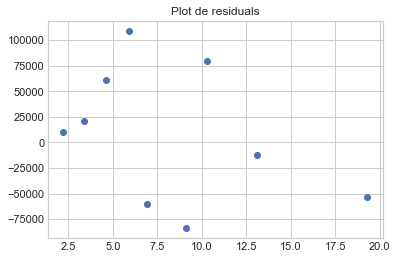

In [108]:
#error raro si no le pongo inline y lo dejo interactivo
%matplotlib inline
#plot der esiduals
plt.figure(110)
plt.scatter(x_data,residuals_logi5)
plt.title('Plot de residuals')
plt.show()

In [109]:
#Calculo de la potencia 
deltaT = 1/6 #10 minutos es un sexto de hora

pot5PL = np.sum( logistic5(dataVP.vViento, B_5PL, C_5PL,G_5PL))
ener5PL =pot5PL*deltaT
difPct5PL = ((ener5PL-enerDatos)*100)/enerDatos

difPct5PL_fab = ((ener5PL-enerpotfab)*100)/enerpotfab


## 4 parameter logistic (4PL)
$$
P = D+\frac{A-D}{1+(v/C)^B}
$$
A = minimum asymptote<br>
B = Hill slope<br>
C = inflection point (point of curve where the curvature changes direction)<br>
D = maximum asymptote<br>


[6.2457916  8.87406303]


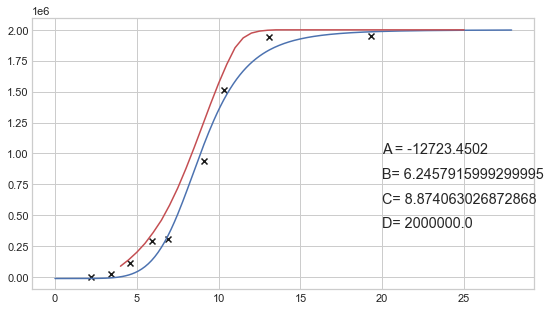

In [110]:
x_data = lcent[:,0]
y_data =lcent[:,1]

def logistic4(x, B, C):
    """4PL lgoistic equation."""
    yoff =-1.27234502e+04 #potencia cuando elv iento es cero
    A = yoff #A  is the minimum asymptote
    D = 2E6 #D  is the maximum asymptote.

    yoff =-1.27234502e+04 #potencia cuando elv iento es cero
    return ((A-D)/(1.0+((x/C)**B))) + D 


params, params_covariance = optimize.curve_fit(logistic4, x_data, y_data,
                                               p0=[5,8 ],bounds=((5,8),(10,10)))

print(params)
A_4PL = yoff #A  is the minimum asymptote
D_4PL = 2E6 #D  is the maximum asymptote.

B_4PL= params[0]
C_4PL= params[1]

p =plt.figure(106,figsize=(9,5))
vviento = np.arange(0, 28, 0.1)
y_pred_logi4_vv= logistic4(vviento, B_4PL, C_4PL)
y_pred_logi4= logistic4(x_data, B_4PL, C_4PL)
plt.plot(vviento, y_pred_logi4_vv)
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.plot(dfCPot.index,dfCPot.pw,c='r')

plt.ylim(-1E5, 2.1E6)
plt.text(20,100E4,'A = ' + str(A_4PL),size='x-large')
plt.text(20,80E4,'B= ' + str(B_4PL),size='x-large')
plt.text(20,60E4,'C= ' + str(C_4PL),size='x-large')
plt.text(20,40E4,'D= ' + str(D_4PL),size='x-large')
plt.show()


In [111]:
residuals_logi4 = y_data-y_pred_logi4
ss_res = np.sum(residuals_logi4**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_logi4 = 1 - (ss_res / ss_tot)
meanAbsErr_logi4 = sk.metrics.mean_absolute_error(y_data,y_pred_logi4 )
rmse_logi4 = np.sqrt(((y_data - y_pred_logi4) ** 2).mean())
for i in range(len(residuals_logi4)):
    print('Residual %i: %0.4f'%(i+1,residuals_logi4[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_logi4)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_logi4)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_logi4)

Residual 1: 12391.8325
Residual 2: 33153.4997
Residual 3: 94549.7371
Residual 4: 159508.4875
Residual 5: -28104.0865
Residual 6: -130955.2611
Residual 7: 83257.0449
Residual 8: 102792.7137
Residual 9: -37721.6302
_____________________________________
Residual sum of squares: 7.25E+10
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 0.98646
MAE- Mean Absolute Error: 75826.03
RMSE- Root Mean Square Error: 89749.93


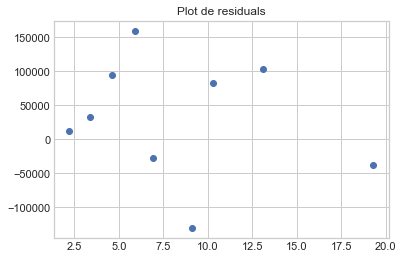

In [112]:
#plot de residuals
plt.figure(107)
plt.scatter(x_data,residuals_logi4)
plt.title('Plot de residuals')
plt.show()

In [113]:
#Calculo de la potencia 
deltaT = 1/6 #10 minutos es un sexto de hora

pot4PL = np.sum( logistic4(dataVP.vViento, B_4PL, C_4PL))
ener4PL =pot4PL*deltaT
difPct4PL = ((ener4PL-enerDatos)*100)/enerDatos
difPct4PL_fab = ((ener4PL-enerpotfab)*100)/enerpotfab



## Smoothing spline


In [114]:
ys

0.027296936219125916

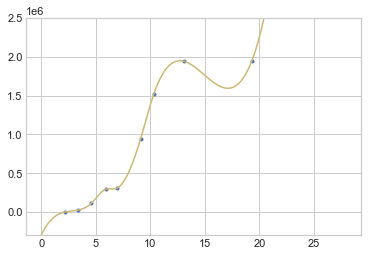

In [115]:
plt.figure(108)
from numpy import linspace,exp
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
x = lcent[:,0]#lista de centroides limpios
y = lcent[:,1]
s = UnivariateSpline(x, y,s=1,k=3)
xs = vviento
ys = s(xs)

plt.plot(x, y, '.')
plt.plot(xs, ys,c='y')
plt.ylim(-300000,2.5E6)
plt.show()

y_pred_smooSpline=s(x_data)
y_pred_smooSpline_vv =s(xs)

In [116]:
residuals_smooSpline = y_data-y_pred_smooSpline
ss_res = np.sum(residuals_smooSpline**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_smooSpline = 1 - (ss_res / ss_tot)
meanAbsErr_smooSpline = sk.metrics.mean_absolute_error(y_data,y_pred_smooSpline)
rmse_smooSpline = np.sqrt(((y_data - y_pred_smooSpline) ** 2).mean())
for i in range(len(residuals_smooSpline)):
    print('Residual %i: %0.4f'%(i+1,residuals_smooSpline[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_smooSpline)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_smooSpline)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_smooSpline)


Residual 1: -0.0348
Residual 2: 0.1997
Residual 3: -0.4825
Residual 4: 0.7104
Residual 5: -0.4649
Residual 6: 0.0735
Residual 7: 0.0070
Residual 8: -0.0088
Residual 9: 0.0004
_____________________________________
Residual sum of squares: 1.00E+00
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 1.00000
MAE- Mean Absolute Error: 0.22
RMSE- Root Mean Square Error: 0.33


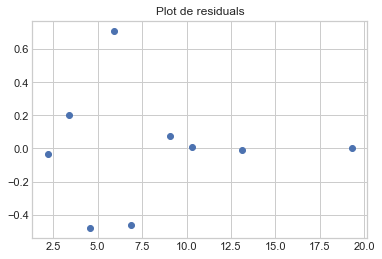

In [117]:
#plot der esiduals
plt.figure(109)
plt.scatter(x_data,residuals_smooSpline)
plt.title('Plot de residuals')
plt.show()

In [118]:
#Calculo de la potencia 
deltaT = 1/6 #10 minutos es un sexto de hora

potSP = np.sum( s(dataVP.vViento))
enerSP =potSP*deltaT
difPctSP = ((enerSP-enerDatos)*100)/enerDatos

difPctSP_fab = ((enerSP-enerpotfab)*100)/enerpotfab


## Smoothstep
$$smoothstep(x) = S_1(x)=
    \begin{cases}
      0 & \text{if $x\leq0$} \\
      3x^2-2x^3 & \text{if $0\leq x\leq 1$}\\
      1 & \text{if $1\leq x$}
    \end{cases}       
  $$
- Mejor R^2 =0.99183
- el primer valor (v=0) es 12723.4502 y se repite 21 veces al principio. No es -12723.4502Watts


[ 2.         16.19590178]


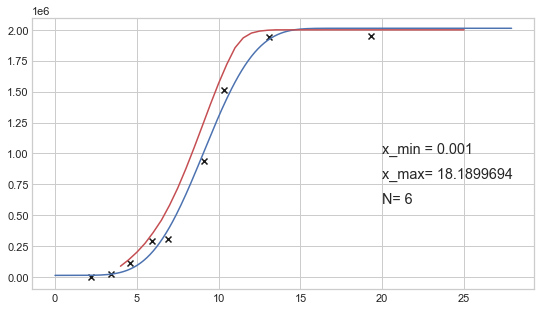

In [119]:
from scipy.special import comb

x_data = lcent[:,0]
y_data =lcent[:,1]

def smoothstep(x, x_min, x_max):
    x = np.clip((x - x_min) / (x_max - x_min), 0, 1)
    yoff =-1.27234502e+04 #potencia cuando elv iento es cero
    N=6
    result = 0
    for n in range(0, N + 1):
         result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n 
        
    result *= x ** (N + 1)

    return 2E6*result -yoff


params, params_covariance = optimize.curve_fit(smoothstep, x_data, y_data,
                                               p0=[2, 15],bounds=((2,15),(5,25)))

print(params)
x_min= 1.00000000e-03
x_max= 1.81899694e+01
N=6
p =plt.figure(110,figsize=(9,5))
vviento = np.arange(0, 28, 0.1)
y_pred_smooStep_vv=smoothstep(vviento, x_min, x_max)
y_pred_smooStep=smoothstep(x_data,x_min,x_max)
plt.plot(vviento, y_pred_smooStep_vv)
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.plot(dfCPot.index,dfCPot.pw,c='r')

plt.ylim(-1E5, 2.1E6)
plt.text(20,100E4,'x_min = ' + str(x_min),size='x-large')
plt.text(20,80E4,'x_max= ' + str(x_max),size='x-large')
plt.text(20,60E4,'N= ' + str(N),size='x-large')

plt.show()


In [120]:
residuals_smooStep = y_data-y_pred_smooStep 
ss_res = np.sum(residuals_smooStep**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_smooStep  = 1 - (ss_res / ss_tot)
meanAbsErr_smooStep  = sk.metrics.mean_absolute_error(y_data,y_pred_smooStep )
rmse_smooStep = np.sqrt(((y_data - y_pred_smooStep) ** 2).mean())
for i in range(len(residuals_smooStep)):
    print('Residual %i: %0.4f'%(i+1,residuals_smooStep[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_smooStep)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_smooStep)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_smooStep)

Residual 1: -13388.1162
Residual 2: 3277.9350
Residual 3: 50168.6647
Residual 4: 97868.8313
Residual 5: -75092.7476
Residual 6: -72644.1396
Residual 7: 126231.8448
Residual 8: 15440.8265
Residual 9: -66035.5624
_____________________________________
Residual sum of squares: 4.37E+10
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 0.99183
MAE- Mean Absolute Error: 57794.30
RMSE- Root Mean Square Error: 69709.62


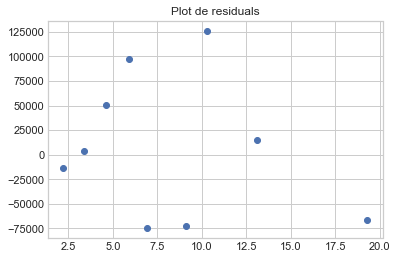

In [121]:
#plot der esiduals
plt.figure(111)
plt.scatter(x_data,residuals_smooStep)
plt.title('Plot de residuals')
plt.show()

In [122]:
#Calculo de la potencia 
deltaT = 1/6 #10 minutos es un sexto de hora

potSmoothStep = np.sum( smoothstep(dataVP.vViento, x_min, x_max))
enerSmoothStep=potSmoothStep*deltaT
difPctSmoothStep= ((enerSmoothStep-enerDatos)*100)/enerDatos

difPctSmoothStep_fab= ((enerSmoothStep-enerpotfab)*100)/enerpotfab


## Gompertz function
$$f(t)=ae^{-be^{-ct}}$$
- a is an asymptote, since $${\displaystyle \lim _{t\to \infty }a\mathrm {e} ^{-b\mathrm {e} ^{-ct}}=a\mathrm {e} ^{0}=a} {\displaystyle \lim _{t\to \infty }a\mathrm {e} ^{-b\mathrm {e} ^{-ct}}=a\mathrm {e} ^{0}=a}$$
- b, c are positive numbers
-b sets the displacement along the x-axis (translates the graph to the left or right)
- c sets the growth rate (y scaling)
- e is Euler's Number (e = 2.71828...)

[34.71087044  0.44030413  2.06235073]


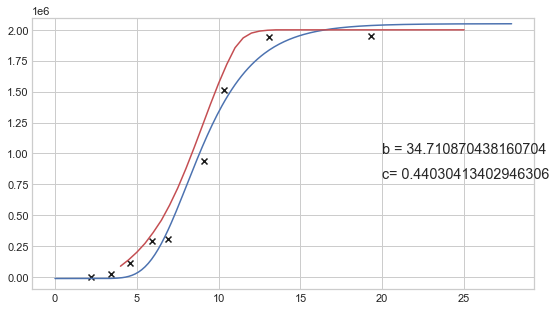

In [123]:
from scipy import optimize
x_data = lcent[:,0]
y_data =lcent[:,1]

def gompertz(vviento, b, c,a):
    #a=2E6  #asintota
    yoff =-1.27234502e+04 #potencia cuando elv iento es cero
    return a*1E6*np.exp(-b*np.exp(-c*vviento)) +yoff


params, params_covariance = optimize.curve_fit(gompertz, x_data, y_data,
                                               p0=[20, 0,0],bounds=((5,0,0),(100,10,4)))
yoff =-1.27234502e+04 #potencia cuando elv iento es cero

print(params)
b= params[0]
c= params[1]
a= params[2]

p =plt.figure(112,figsize=(9,5))
vviento = np.arange(0, 28, 0.1)
y_pred_gompertz_vv=a*1E6*np.exp(-b*np.exp(-c*vviento)) +yoff

plt.plot(vviento, y_pred_gompertz_vv)
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.plot(dfCPot.index,dfCPot.pw,c='r')

plt.ylim(-1E5, 2.1E6)
plt.text(20,100E4,'b = ' + str(b),size='x-large')
plt.text(20,80E4,'c= ' + str(c),size='x-large')
plt.show()
y_pred_gompertz = gompertz(x_data, params[0],params[1],params[2])


In [124]:
residuals_gompertz = y_data- y_pred_gompertz
ss_res = np.sum(residuals_gompertz**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_gompertz = 1 - (ss_res / ss_tot)
meanAbsErr_gompertz= sk.metrics.mean_absolute_error(y_data,y_pred_gompertz)
rmse_gompertz = np.sqrt(((y_data - y_pred_gompertz) ** 2).mean())
for i in range(len(residuals_gompertz)):
    print('Residual %i: %0.4f'%(i+1,residuals_gompertz[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_gompertz)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_gompertz)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_gompertz)

Residual 1: 12719.5402
Residual 2: 37297.8971
Residual 3: 106080.9399
Residual 4: 149681.8691
Residual 5: -72657.0729
Residual 6: -142525.7089
Residual 7: 105537.3473
Residual 8: 102766.8890
Residual 9: -88394.3831
_____________________________________
Residual sum of squares: 9.03E+10
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 0.98314
MAE- Mean Absolute Error: 90851.29
RMSE- Root Mean Square Error: 100175.46


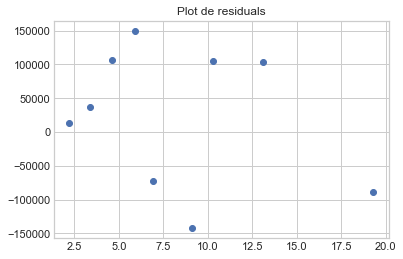

In [125]:
#plot der esiduals
plt.figure(113)
plt.scatter(x_data,residuals_gompertz)
plt.title('Plot de residuals')
plt.show()

In [126]:
#Calculo de la potencia 
deltaT = 1/6 #10 minutos es un sexto de hora

potGompertz = np.sum( a*1E6*np.exp(-b*np.exp(-c*dataVP.vViento)) +yoff)
enerGompertz=potGompertz*deltaT
difPctGompertz = ((enerGompertz-enerDatos)*100)/enerDatos


difPctGompertz_fab = ((enerGompertz-enerpotfab)*100)/enerpotfab


## Double exponential
$$
P= exp(-\tau_1exp(-v\tau_2))
$$

Coefficient of determination R^2: 0.98363


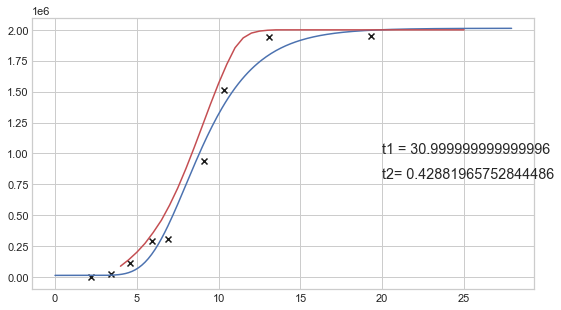

In [127]:
from scipy import optimize
x_data = lcent[:,0]
y_data =lcent[:,1]

def dobleExp(x, t1,t2):
    """Double exponential"""
    yoff =-1.27234502e+04 #potencia cuando elv iento es cero
    A=2E6
    return (np.exp(-t1*np.exp(-(x*t2)))*A)-yoff

#t1= 30.000000 , t2=0.421900 gridsearch
params, params_covariance = optimize.curve_fit(dobleExp, x_data, y_data,
                                               p0=[30,0.1],bounds=((30,0.1),(31,1)))

yoff =-1.27234502e+04 #potencia cuando elv iento es cero


t1= params[0]
t2= params[1]

residuals = y_data- dobleExp(x_data, params[0],params[1])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_dbexp = 1 - (ss_res / ss_tot)
print('Coefficient of determination R^2: %0.5f'%r_squared_dbexp)
p =plt.figure(114,figsize=(9,5))
vviento = np.arange(0, 28, 0.1)
y_pred_dbExp_vv= dobleExp(vviento, params[0],params[1])
y_pred_dbExp= dobleExp(x_data, params[0],params[1])

plt.plot(vviento, y_pred_dbExp_vv)
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.plot(dfCPot.index,dfCPot.pw,c='r')

plt.ylim(-1E5, 2.1E6)
plt.text(20,100E4,'t1 = ' + str(t1),size='x-large')
plt.text(20,80E4,'t2= ' + str(t2),size='x-large')

plt.show()



In [128]:
residuals_dbExp = y_data-y_pred_dbExp
ss_res = np.sum(residuals_dbExp**2)
ss_tot = np.sum((y_data-np.mean(y_data))**2)
r_squared_dbExp = 1 - (ss_res / ss_tot)
meanAbsErr_dbExp = sk.metrics.mean_absolute_error(y_data,y_pred_dbExp )
rmse_dbExp = np.sqrt(((y_data - y_pred_dbExp) ** 2).mean())
for i in range(len(residuals_dbExp)):
    print('Residual %i: %0.4f'%(i+1,residuals_dbExp[i]))
print('_____________________________________')
print('Residual sum of squares: %0.2E'%ss_res)
print('Total sum of squares: %0.2E'%ss_tot)
print('R^2- Coefficient of determination: %0.5f'%r_squared_dbExp)
print('MAE- Mean Absolute Error: %0.2f'%meanAbsErr_dbExp)
print('RMSE- Root Mean Square Error: %0.2f'%rmse_dbExp)

Residual 1: -12734.9271
Residual 2: 11250.7908
Residual 3: 74975.9114
Residual 4: 110634.6310
Residual 5: -107845.7937
Residual 6: -140551.8052
Residual 7: 125744.8890
Residual 8: 140659.8338
Residual 9: -50318.7946
_____________________________________
Residual sum of squares: 8.77E+10
Total sum of squares: 5.36E+12
R^2- Coefficient of determination: 0.98363
MAE- Mean Absolute Error: 86079.71
RMSE- Root Mean Square Error: 98694.05


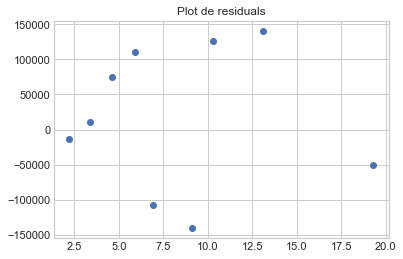

In [129]:
#plot der esiduals
plt.figure(115)
plt.scatter(x_data,residuals_dbExp)
plt.title('Plot de residuals')
plt.show()

In [130]:
#Calculo de la potencia 
deltaT = 1/6 #10 minutos es un sexto de hora

potDobleExp = np.sum( dobleExp(dataVP.vViento, t1,t2))
enerDobleExp=potDobleExp*deltaT
difPctDobleExp = ((enerDobleExp-enerDatos)*100)/enerDatos
difPctDobleExp_fab = ((enerDobleExp-enerpotfab)*100)/enerpotfab


# Resumen de resultados

In [131]:

columns = ['Poly','SmoothSpline','ExpAlg','Gompertz','SmootStep','4PLogi','5PLogi','DoubleExp']
r2_arr=[r_squared_poly,r_squared_smooSpline, r_squared_alg,r_squared_gompertz,r_squared_smooStep,r_squared_logi4,
         r_squared_logi5, r_squared_dbexp]
mae_arr =[meanAbsErr_poly,meanAbsErr_smooSpline,meanAbsErr_alg,meanAbsErr_gompertz,meanAbsErr_smooStep,
          meanAbsErr_logi4,meanAbsErr_logi5,meanAbsErr_dbExp]
rmse_arr=[rmse_poly,rmse_smooSpline,rmse_alg,rmse_gompertz,rmse_smooStep,rmse_logi4,rmse_logi5,rmse_dbExp]
pot_arr = np.array([potPoly, potSP, potExpAlg, potGompertz, potSmoothStep,pot4PL,pot5PL,potDobleExp])/1e6
ener_arr = np.array([enerPoly, enerSP, enerExpAlg, enerGompertz, enerSmoothStep,ener4PL,ener5PL,enerDobleExp])/1e6
difPct_arr = np.array([difPctPoly, difPctSP, difPctExpAlg, difPctGompertz, difPctSmoothStep,difPct4PL,difPct5PL,
                       difPctDobleExp])


indice = ['R2','MAE','RMSE','Pot [MW]','Ener [MWh]','%dif']
cvregSummary = pd.DataFrame([r2_arr,mae_arr,rmse_arr,pot_arr,ener_arr,difPct_arr],columns=columns,index=indice).T
print('Potencia total (datos):%0.2f MW'%( dataVP.Pw.sum()/1e6))
print('Energía total (datos):%0.2f MW'% (dataVP.Pw.sum()*deltaT/1e6))
cvregSummary.sort_values(['%dif'],ascending=True)


Potencia total (datos):35670.96 MW
Energía total (datos):5945.16 MW


,R2,MAE,RMSE,Pot [MW],Ener [MWh],%dif
4PLogi,0.986463,75826.032577,89749.925040,36635.008266,6105.834711,2.702606
Gompertz,0.983136,90851.294164,100175.461411,37036.503979,6172.750663,3.828160
DoubleExp,0.983631,86079.708512,98694.050107,37320.663926,6220.110654,4.624774
Poly,0.986716,68706.347026,88909.644446,38048.726905,6341.454484,6.665826
5PLogi,0.993230,54626.185476,63468.846399,38091.750453,6348.625075,6.786438
SmootStep,0.991834,57794.296474,69709.615642,38442.161706,6407.026951,7.768782
ExpAlg,0.994281,49530.907802,58336.755964,39045.203413,6507.533902,9.459349
SmoothSpline,1.000000,0.220230,0.333368,41960.110017,6993.351670,17.631000


In [132]:

columns = ['Poly','SmoothSpline','ExpAlg','Gompertz','SmootStep','4PLogi','5PLogi','DoubleExp']
r2_arr=[r_squared_poly,r_squared_smooSpline, r_squared_alg,r_squared_gompertz,r_squared_smooStep,r_squared_logi4,
         r_squared_logi5, r_squared_dbexp]
mae_arr =[meanAbsErr_poly,meanAbsErr_smooSpline,meanAbsErr_alg,meanAbsErr_gompertz,meanAbsErr_smooStep,
          meanAbsErr_logi4,meanAbsErr_logi5,meanAbsErr_dbExp]
rmse_arr=[rmse_poly,rmse_smooSpline,rmse_alg,rmse_gompertz,rmse_smooStep,rmse_logi4,rmse_logi5,rmse_dbExp]
pot_arr = np.array([potPoly, potSP, potExpAlg, potGompertz, potSmoothStep,pot4PL,pot5PL,potDobleExp])/1e6
ener_arr = np.array([enerPoly, enerSP, enerExpAlg, enerGompertz, enerSmoothStep,ener4PL,ener5PL,enerDobleExp])/1e6
difPct_arr = np.array([difPctPoly, difPctSP, difPctExpAlg, difPctGompertz, difPctSmoothStep,difPct4PL,difPct5PL,
                       difPctDobleExp])
difPct_arr_fab= np.array([difPctPoly_fab, difPctSP_fab, difPctExpAlg_fab, difPctGompertz_fab, difPctSmoothStep_fab,difPct4PL_fab,
                          difPct5PL_fab,difPctDobleExp_fab])

indice = ['R2','MAE','RMSE','Pot [MW]','Ener [MWh]','%dif','%dif_fab']
cvregSummary = pd.DataFrame([r2_arr,mae_arr,rmse_arr,pot_arr,ener_arr,difPct_arr,difPct_arr_fab],columns=columns,index=indice).T
print('Potencia total (datos):%0.2f MW'%( dataVP.Pw.sum()/1e6))
print('Energía total (datos):%0.2f MW'% (dataVP.Pw.sum()*deltaT/1e6))
#ordenar
#cvregSummary_sorted =cvregSummary.sort_values(['%dif'],ascending=True)
#ordenar por valor absoluto
cvregSummary_sorted =cvregSummary.reindex(cvregSummary['%dif'].abs().sort_values().index)

#tres decimales y separador de comas
cvregSummary_sorted.style.format("{:,.3f}")
 
#color de columna no se como se hace


Potencia total (datos):35670.96 MW
Energía total (datos):5945.16 MW


,R2,MAE,RMSE,Pot [MW],Ener [MWh],%dif,%dif_fab
4PLogi,0.986,"75,826.033","89,749.925","36,635.008","6,105.835",2.703,-11.124
Gompertz,0.983,"90,851.294","100,175.461","37,036.504","6,172.751",3.828,-10.150
DoubleExp,0.984,"86,079.709","98,694.050","37,320.664","6,220.111",4.625,-9.460
Poly,0.987,"68,706.347","88,909.644","38,048.727","6,341.454",6.666,-7.694
5PLogi,0.993,"54,626.185","63,468.846","38,091.750","6,348.625",6.786,-7.590
SmootStep,0.992,"57,794.296","69,709.616","38,442.162","6,407.027",7.769,-6.740
ExpAlg,0.994,"49,530.908","58,336.756","39,045.203","6,507.534",9.459,-5.277
SmoothSpline,1.000,0.220,0.333,"41,960.110","6,993.352",17.631,1.795


In [133]:
#tabla latex
print(cvregSummary_sorted.to_latex(bold_rows=True,float_format="{:0.3f}".format))

\begin{tabular}{lrrrrrrr}
\toprule
{} &    R2 &       MAE &       RMSE &  Pot [MW] &  Ener [MWh] &   \%dif &  \%dif\_fab \\
\midrule
\textbf{4PLogi      } & 0.986 & 75826.033 &  89749.925 & 36635.008 &    6105.835 &  2.703 &   -11.124 \\
\textbf{Gompertz    } & 0.983 & 90851.294 & 100175.461 & 37036.504 &    6172.751 &  3.828 &   -10.150 \\
\textbf{DoubleExp   } & 0.984 & 86079.709 &  98694.050 & 37320.664 &    6220.111 &  4.625 &    -9.460 \\
\textbf{Poly        } & 0.987 & 68706.347 &  88909.644 & 38048.727 &    6341.454 &  6.666 &    -7.694 \\
\textbf{5PLogi      } & 0.993 & 54626.185 &  63468.846 & 38091.750 &    6348.625 &  6.786 &    -7.590 \\
\textbf{SmootStep   } & 0.992 & 57794.296 &  69709.616 & 38442.162 &    6407.027 &  7.769 &    -6.740 \\
\textbf{ExpAlg      } & 0.994 & 49530.908 &  58336.756 & 39045.203 &    6507.534 &  9.459 &    -5.277 \\
\textbf{SmoothSpline} & 1.000 &     0.220 &      0.333 & 41960.110 &    6993.352 & 17.631 &     1.795 \\
\bottomrule
\end{tabular}



In [134]:
#a = cvregSummary_sorted.style.format("{:.2%}") #en nueva version dice que styler no tiene to_latex()
print(cvregSummary_sorted.to_latex(bold_rows=True,float_format="{:0.2f}".format))

\begin{tabular}{lrrrrrrr}
\toprule
{} &   R2 &      MAE &      RMSE &  Pot [MW] &  Ener [MWh] &  \%dif &  \%dif\_fab \\
\midrule
\textbf{4PLogi      } & 0.99 & 75826.03 &  89749.93 &  36635.01 &     6105.83 &  2.70 &    -11.12 \\
\textbf{Gompertz    } & 0.98 & 90851.29 & 100175.46 &  37036.50 &     6172.75 &  3.83 &    -10.15 \\
\textbf{DoubleExp   } & 0.98 & 86079.71 &  98694.05 &  37320.66 &     6220.11 &  4.62 &     -9.46 \\
\textbf{Poly        } & 0.99 & 68706.35 &  88909.64 &  38048.73 &     6341.45 &  6.67 &     -7.69 \\
\textbf{5PLogi      } & 0.99 & 54626.19 &  63468.85 &  38091.75 &     6348.63 &  6.79 &     -7.59 \\
\textbf{SmootStep   } & 0.99 & 57794.30 &  69709.62 &  38442.16 &     6407.03 &  7.77 &     -6.74 \\
\textbf{ExpAlg      } & 0.99 & 49530.91 &  58336.76 &  39045.20 &     6507.53 &  9.46 &     -5.28 \\
\textbf{SmoothSpline} & 1.00 &     0.22 &      0.33 &  41960.11 &     6993.35 & 17.63 &      1.79 \\
\bottomrule
\end{tabular}



In [135]:
dvv

C1                    C2              C3          \
                          SC1           SC2     SC1     SC2     SC1     SC2   
                           vx        vy  vx  vy  vx  vy  vx  vy  vx  vy  vx   
2016-01-01 00:00:00       NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2016-01-01 00:10:00       NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2016-01-01 00:20:00       NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2016-01-01 00:30:00       NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2016-01-01 00:40:00       NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
...                       ...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
2017-01-01 23:00:00 -0.130661  0.789258 NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2017-01-01 23:10:00 -0.262189  0.965016 NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2017-01-01 23:20:00 -0.505243  1.088453 NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2017-01-01 23:30:00 -0.359940  1.039444 NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2017-01-01 23:40:00  0.015706  0.599794 NaN NaN NaN NaN NaN NaN NaN NaN NaN   

                                       C4             C5      
                        SC3           SC3            SC1      
                     vy  vx  vy        vx         vy  vx  vy  
2016-01-01 00:00:00 NaN NaN NaN -6.273062  11.042586 NaN NaN  
2016-01-01 00:10:00 NaN NaN NaN -7.688883  12.645991 NaN NaN  
2016-01-01 00:20:00 NaN NaN NaN -7.076189  14.572836 NaN NaN  
2016-01-01 00:30:00 NaN NaN NaN -6.012825  13.632899 NaN NaN  
2016-01-01 00:40:00 NaN NaN NaN -6.692292  14.753075 NaN NaN  
...                  ..  ..  ..       ...        ...  ..  ..  
2017-01-01 23:00:00 NaN NaN NaN       NaN        NaN NaN NaN  
2017-01-01 23:10:00 NaN NaN NaN       NaN        NaN NaN NaN  
2017-01-01 23:20:00 NaN NaN NaN       NaN        NaN NaN NaN  
2017-01-01 23:30:00 NaN NaN NaN       NaN        NaN NaN NaN  
2017-01-01 23:40:00 NaN NaN NaN       NaN        NaN NaN NaN  

[50150 rows x 18 columns]

In [136]:
ys

array([-2.96508834e+05, -2.67656335e+05, -2.40750651e+05, -2.15719402e+05,
       -1.92490205e+05, -1.70990678e+05, -1.51148439e+05, -1.32891105e+05,
       -1.16146295e+05, -1.00841626e+05, -8.69047174e+04, -7.42631857e+04,
       -6.28446493e+04, -5.25767261e+04, -4.33870340e+04, -3.52031908e+04,
       -2.79528146e+04, -2.15635232e+04, -1.59629345e+04, -1.10786665e+04,
       -6.83833697e+03, -3.16956391e+03,  3.48012656e-02,  2.74284124e+03,
        5.13123751e+03,  7.23760570e+03,  9.13432790e+03,  1.08937862e+04,
        1.25883627e+04,  1.42904395e+04,  1.60723986e+04,  1.80066222e+04,
        2.01654924e+04,  2.26213912e+04,  2.54467008e+04,  2.87138032e+04,
        3.24950805e+04,  3.68629148e+04,  4.18896883e+04,  4.76477829e+04,
        5.42095809e+04,  6.16474642e+04,  7.00338150e+04,  7.94410153e+04,
        8.99414474e+04,  1.01607493e+05,  1.14511535e+05,  1.28664408e+05,
        1.43830765e+05,  1.59713709e+05,  1.76016347e+05,  1.92441784e+05,
        2.08693125e+05,  

In [137]:
idx_centroids_sc_clean


subcluster_ID         PCTimeStamp        vx  \
cluster_ID subcluster_ID_ord                                                
C1         SC1                            1 2016-01-07 02:50:00 -1.230224   
           SC2                            2 2016-02-22 04:50:00 -0.592460   
C2         SC1                            1 2016-01-09 09:40:00 -0.479064   
           SC2                            3 2016-03-12 15:30:00  2.706032   
C3         SC1                            2 2016-03-03 10:50:00 -3.697205   
           SC2                            1 2016-12-16 10:10:00 -2.614981   
           SC3                            3 2016-01-21 00:00:00 -3.165773   
C4         SC3                            1 2016-01-01 08:30:00 -6.310973   
C5         SC1                            2 2016-01-03 09:20:00 -8.095425   

                                     vy  vViento            Pw  
cluster_ID subcluster_ID_ord                                    
C1         SC1                 1.823883      2.2  0.000000e+00  
           SC2                 4.561687      4.6  1.145111e+05  
C2         SC1                -3.366080      3.4  2.544690e+04  
           SC2                -5.242842      5.9  2.926394e+05  
C3         SC1                 5.825863      6.9  3.053628e+05  
           SC2                 8.716185      9.1  9.415353e+05  
           SC3                 9.801422     10.3  1.514091e+06  
C4         SC3                11.479618     13.1  1.940326e+06  
C5         SC1                17.520105     19.3  1.946688e+06

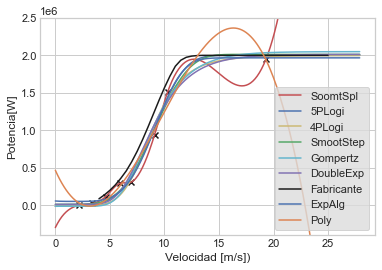

In [138]:
fontsize = 13
labelFontSize = 13
tickFontSize = 12
markerSize = 100
fontNameLabel = {'fontname':'Times New Roman'}
fontNameCluster = {'fontname':'Arial'}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
        size=labelFontSize, weight='normal', stretch='normal')   

#subcentroides limpios
sc_clean_x= idx_centroids_sc_clean.vViento.values
sc_clean_y= idx_centroids_sc_clean.Pw.values
sc_clean_x=np.delete(sc_clean_x,7)
sc_clean_y=np.delete(sc_clean_y,7)

#NOTA ES UN AJUSTE TEMPORAL, NO ESTA BIEN HECO
#eliminando el subcluster outlier

plt.figure(116)
#plt.plot(x, y, '.', xp, polyf(xp), '-')
plt.plot(xs, ys,'r',label='SoomtSpl')#smothing spline
plt.plot(vviento, y_pred_logi5_vv,linestyle='-',c='b',label='5PLogi')
plt.plot(vviento, y_pred_logi4_vv,linestyle='-',c='y',label='4PLogi')
plt.plot(vviento, y_pred_smooStep_vv,linestyle='-',c='g',label='SmootStep')
plt.plot(vviento, y_pred_gompertz_vv,linestyle='-',c='c',label='Gompertz')
plt.plot(vviento, y_pred_dbExp_vv,linestyle='-',c='m',label='DoubleExp')
plt.plot(dfCPot.index,dfCPot.pw,c='k',linestyle='-',label='Fabricante')
plt.plot(vviento, y_pred_alg_vv,linestyle='-',label='ExpAlg')
_ = plt.plot(xp, polyf(xp), '-',label='Poly')
plt.ylim(-4E5,2.5E6)


#plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.scatter(sc_clean_x,sc_clean_y,c='k',marker='x')
plt.xlabel('Velocidad [m/s])')
plt.ylabel('Potencia[W]')
plt.legend(frameon=True,facecolor='gainsboro')
if flagsaveim:
    plt.savefig('adjfuncplot.png')
plt.show()



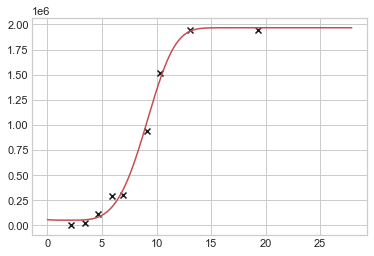

In [139]:
#una sola grafica vs potfab vs cent

plt.figure(117)
#plt.plot(xs, ys,'r')#smothing spline
#plt.plot(x, y, '.', xp, polyf(xp), '-')
plt.plot(vviento, y_pred_alg_vv,linestyle='-',c='r')
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')


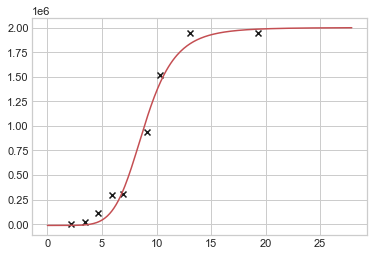

In [140]:
#una sola grafica vs potfab vs cent

plt.figure(118)
#plt.plot(xs, ys,'r')#smothing spline
#plt.plot(x, y, '.', xp, polyf(xp), '-')
plt.plot(vviento, y_pred_logi4_vv,linestyle='-',c='r')
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')

In [141]:
# dfVecVel_NCl: datos filtrados y sin clusters pasados a datos normales
dfVecVel_NCl,dataVP_NCl = clust2data(dvv,dvp)

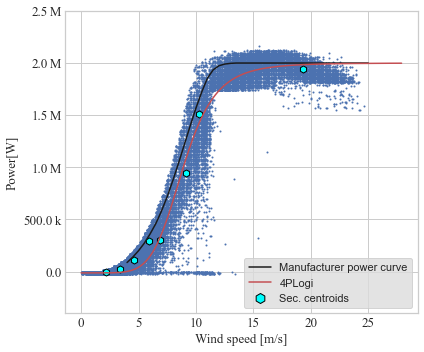

In [142]:
#plot filtrado con solo la mejor funcion de ajuste
plt.figure(212,figsize=(6,5))
plt.scatter(dataVP_NCl.vViento,dataVP_NCl.Pw,s=1, label='_nolegend_')
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
ax1=plt.gca()
#ax1.set_ylabel('Potencia [W]')
#ax1.set_xlabel('Vel. de viento [m/s]')
ax1.yaxis.set_major_formatter(formatter1)
plt.plot(dfCPot.index,dfCPot.pw,c='k',linestyle='-',label='Manufacturer power curve' ) 

plt.plot(vviento, y_pred_logi4_vv,linestyle='-',c='r',label='4PLogi')

plt.ylim(-4E5,2.5E6)

for label in plt.gca().get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in plt.gca().get_yticklabels():
    label.set_fontproperties(ticks_font)
#plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.scatter(sc_clean_x,sc_clean_y,c='aqua',marker='h',s=50,lw=1,edgecolor='black')
plt.xlabel('Wind speed [m/s]',fontsize=13,fontname ='Times New Roman')
plt.ylabel('Power[W]',fontsize=13,fontname ='Times New Roman')
#obtnener las leyendas individuales
handles, labels = plt.gca().get_legend_handles_labels()
#crear una sola leyenda para los centroides secundarios
legSecCentroids = mlines.Line2D([], [], color='aqua', marker='h', linestyle='None',
                          markersize=10, label='Sec. centroids',markeredgecolor='black',markeredgewidth=1)
#añadir los centroides secundarios a la leyenda 
handles.append(legSecCentroids)
plt.legend(handles=handles,frameon=True,facecolor='gainsboro',loc='best')
plt.tight_layout()
if flagsaveim:
    plt.savefig('powerc_best_adjfunc.png')
plt.savefig('powerc_best_adjfunc.png')

plt.show()



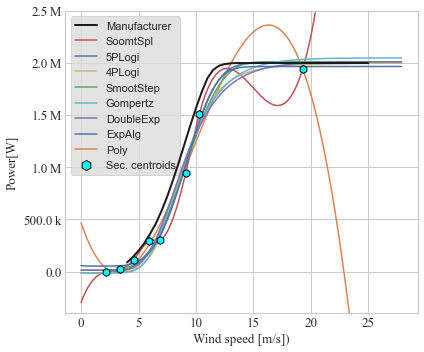

In [143]:
fontsize = 13
labelFontSize = 13
tickFontSize = 12
markerSize = 100
fontNameLabel = {'fontname':'Times New Roman'}
fontNameCluster = {'fontname':'Arial'}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
        size=labelFontSize, weight='normal', stretch='normal')   
#plot filtrado con todas las funciones de ajuste
plt.figure(213,figsize=(6,5))
#plt.scatter(dataVP_NCl.vViento,dataVP_NCl.Pw,s=1)
formatter1 = EngFormatter(places=1, sep="\N{THIN SPACE}")  # U+2009
ax1=plt.gca()
ax1.yaxis.set_major_formatter(formatter1)

plt.plot(dfCPot.index,dfCPot.pw,c='k',linestyle='-',label='Manufacturer',zorder=9,lw=2)
plt.plot(xs, ys,'r',label='SoomtSpl',zorder=2)#smothing spline
plt.plot(vviento, y_pred_logi5_vv,linestyle='-',c='b',label='5PLogi',zorder=3)
plt.plot(vviento, y_pred_logi4_vv,linestyle='-',c='y',label='4PLogi',zorder=4)
plt.plot(vviento, y_pred_smooStep_vv,linestyle='-',c='g',label='SmootStep',zorder=5)
plt.plot(vviento, y_pred_gompertz_vv,linestyle='-',c='c',label='Gompertz',zorder=6)
plt.plot(vviento, y_pred_dbExp_vv,linestyle='-',c='m',label='DoubleExp',zorder=7)
plt.plot(vviento, y_pred_alg_vv,linestyle='-',label='ExpAlg',zorder=8)
_ = plt.plot(xp, polyf(xp), '-',label='Poly',zorder=1)
plt.ylim(-4E5,2.5E6)

for label in plt.gca().get_xticklabels():
    label.set_fontproperties(ticks_font)
for label in plt.gca().get_yticklabels():
    label.set_fontproperties(ticks_font)

#plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.xlabel('Wind speed [m/s])',fontsize=13,**fontNameLabel )
plt.ylabel('Power[W]',fontsize=13,**fontNameLabel )
plt.scatter(sc_clean_x,sc_clean_y,c='aqua',marker='h',edgecolor='black',s=60,lw=1,zorder=10)
#obtnener las leyendas individuales
handles, labels = plt.gca().get_legend_handles_labels()
#crear una sola leyenda para los centroides secundarios
legSecCentroids = mlines.Line2D([], [], color='aqua', marker='h', linestyle='None',
                          markersize=10, label='Sec. centroids',markeredgecolor='black',markeredgewidth=1)
#añadir los centroides secundarios a la leyenda 
handles.append(legSecCentroids)
plt.legend(handles=handles,frameon=True,facecolor='gainsboro',loc='upper left')

plt.tight_layout()
if flagsaveim:
    plt.savefig('adjfuncplot.png')
plt.savefig('adjfuncplot.png')
    
plt.show()


#  Diferencia entre curva calculada filtrada y sin filtrar (estados no, pero límite de Betz sí) (no tiene caso, el grupo 11 mueve toda la curva y no sirve para nada)

In [144]:
sc_clean_x

array([ 2.2,  4.6,  3.4,  5.9,  6.9,  9.1, 10.3, 19.3])

## No filtrado

In [145]:
#calculo de la potencia maxima  a partir del limite de betz
A=np.pi*45**2
Cp = 0.59 #limite de Betz
rho = 1.1349
vvento = np.unique(dataVP.vViento.values)
PMaxViento = 1/2*rho*A*vvento**3*Cp

In [146]:
#sin filtrar datos
#eliminando valores que superen el limite de betz
dataVP_no_filt = dataVP.copy()#copia de dataVP hecha para eliminar valores que superen el limited betz
dfVecVel_no_filt = dfVecVel.copy()
for i in range(len(vvento)):
    idxd =dataVP[(dataVP.vViento==vvento[i])&(dataVP.Pw>PMaxViento[i])].index
    dataVP_no_filt.drop(idxd,inplace=True)
    dfVecVel_no_filt.drop(idxd,inplace=True)

# #eliminando valores de potencia negativos menores a 30kW
mask = dataVP[dataVP.Pw<-30E3].index
dataVP_no_filt.drop(mask,inplace=True)
dfVecVel_no_filt.drop(mask,inplace=True)

#subclusters
clsclord=('viento','potencia') #orden de clusterizado
# crear los dataframes agrupados en clusters
dfclvv_nf, dfclpw_nf, dfclvp_nf, cl_ord_nf,cl_cent_nf,idx_centroids_nf,scl_ord_nf,scl_cent_nf,idx_centroids_sc_nf = cluster2DataFrame(
    dfVecVel_no_filt, dataVP_no_filt, n_clusters=5,n_subclu = 3,clusters=clsclord[0],subclusters=clsclord[1])



13.7-1997581.6887850699
1.6--12723.450247038661
3.5-0.0
19.8-1883070.636561722
8.4-547108.3606226625
Saved in VVVPCl5SCl3_13-12-2021_02_40_31_226053.png


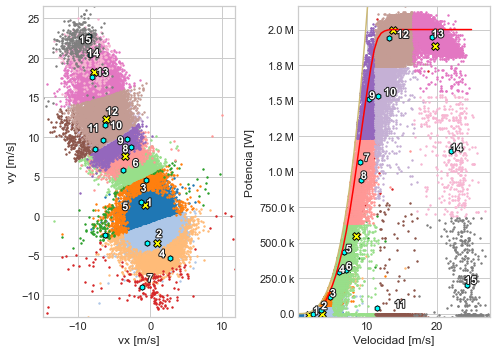

In [147]:
ploti_no_filt = plotSubClusterInt()
ploti_no_filt.createPlot(dfclvv_nf, dfclvp_nf, dataVP, figsize=(
    7, 5), cl_scl_order=clsclord, idx_centroids=idx_centroids_nf,idx_centroids_sc=idx_centroids_sc_nf,fign=92)

In [148]:
# dfVecVel_NCl: datos filtrados y sin clusters pasados a datos normales
dfVecVel_no_filt_NCl,dataVP_no_filt_NCl = clust2data(dfclvv_nf,dfclvp_nf)

[ 1.95052437e-05 -7.88785844e+00 -2.98070892e-01  1.80000000e+06]


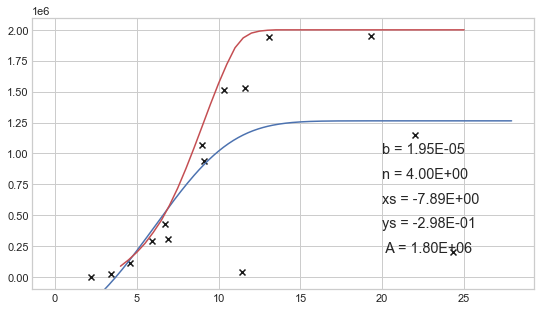

In [149]:
#Hacer una lista de centroides de subclusters
lcent=[]
for i in range(len(idx_centroids_sc_nf)):
    lcent.append([idx_centroids_sc_nf.iloc[i].vViento,idx_centroids_sc_nf.iloc[i].Pw])
lcent= np.array(lcent)
#ordenando centroides
lcent= lcent[lcent[:,0].argsort()]

#calculo de parametros
x_data = lcent[:,0]
y_data =lcent[:,1]

def test_func(vviento, b, xs,ys,A):
    n=4
    return A*((1.0+ys)-np.exp(-b * (vviento-xs)**n))

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[0.0001, 0.001,0,1.8e6],
                                               bounds=((-np.inf,-np.inf,-np.inf,1.8e6),(np.inf,np.inf,np.inf,2.0e6))                                              )


print(params)

n=4
b= params[0]
xs= params[1]
ys= params[2]
A = params[3]
p =plt.figure(400,figsize=(9,5))
vviento = np.arange(0, 28, 0.1)
y_pred_alg_vv=A*((1.0+ys)-np.exp(-b * (vviento-xs)**n))# xshift yshift

plt.plot(vviento, y_pred_alg_vv)
plt.scatter(lcent[:,0],lcent[:,1],c='k',marker='x')
plt.plot(dfCPot.index,dfCPot.pw,c='r')

plt.ylim(-1E5, 2.1E6)
plt.text(20,100E4,'b = %.2E'%b,size='x-large')
plt.text(20,80E4,'n = %.2E'%n,size='x-large')
plt.text(20,60E4,'xs = %.2E'%xs,size='x-large')
plt.text(20,40E4,'ys = %.2E'%ys ,size='x-large')
plt.text(20,20E4,' A = %.2E'% A,size='x-large')
plt.show()
y_pred_alg =test_func(x_data, params[0],params[1],params[2],params[3])


# En terminos de potencia

In [150]:
dfcltodf = dfcltodf.dropna()
#potencia total producida (sumando tambien los negativos ) 
a = dvp.copy()
#Quitar multiindex
a.columns = a.columns.map(''.join)
a.reset_index(inplace=True)
a.drop(a.columns[0], axis=1,inplace=True)
a.drop(a.columns[0::2], axis=1,inplace=True)
pottotclus =int(pd.DataFrame(a.sum()).sum()) #suma de las potencias de los clusters
potreal = dataVP.Pw.sum() #suma de la columna de potencia de los datos del excel

#potencia segun la regresion
potReg =(dfcltodf.dropna().vViento).sum() # b se obtuvo pasando del dataframe dividido en clusters a dataframe sin division

print('Potencia total contenida en los clusters: %.2E' % pottotclus)
print('Potencia real producida: %.2E' % potreal)
print('Diferencia real menos clusters: %.2E' % (potreal-pottotclus))
print('Potencia regresion: %.2E' % potReg)
print('Diferencia real menos regresion: %.2E' % (potreal-potReg))
print('Diferencia clusters menos regresion: %.2E' % (pottotclus-potReg))
dfsincico_delcl =dfcltodf[(dfcltodf.vViento>=cutin_speed) &(dfcltodf.vViento<=cutoff_speed)] #dataframe sin cutin speed ni cutof
dfsincico_original =dataVP[(dataVP.vViento>=cutin_speed) &(dataVP.vViento<=cutoff_speed)] #dataframe sin cutin speed ni cutof
pd.DataFrame(a.sum())#suma de las potencias de los clusters



NameError: name 'dfcltodf' is not defined

In [151]:
a = 6105.835-5945.16

160.67500000000018

In [155]:
b =(a*100)/5945.16
b

0.03468957493794807

In [157]:
5945.16*b

206.23507333809133

In [158]:
2.703/100

0.02703

In [159]:
5945.16*0.02703

160.6976748